# Key Project Strategy Simulator - ZTF Events

The essential procedure for this simulation follows that outlined in kp_simulator.ipynb and kp_simulator_gaia.ipynb, for Gaia events.  Here the simulator is updated with ZTF specific information, such as visibility data. 

In [77]:
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import healpy as hp
import random
import matplotlib.pyplot as plt
import csv
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels
from pyLIMA import microlmagnification
from pyLIMA import microlsimulator
from pyLIMA import microltoolbox
from pyLIMA import microloutputs
import jplhorizons_utils
import visibility_utils
import healpixel_functions
from scipy import interpolate, optimize
import h5py
from os import path

## ZTF Event Sky Locations

Rodriguez et al. 2022 2022ApJ...927..150R published a list of 60 microlensing events identified between 2018 and 2020 in the ZTF Data Release catalog.  

This list was input to the skymap_events code to convert this into an approximate map of event rate per year per HEALpixel (see code skymap_events.py).  

In [3]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
hp.nside2resol(NSIDE, arcmin = True)/60.0

0.9161297098179749

In [4]:
map_file_path = 'ztf/ztf_event_rate.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

coords = SkyCoord(data_table['RA'], data_table['Dec'], frame='icrs', unit=(u.hourangle, u.deg))

ztf_event_rate_table = Table([
                            Column(name="HP", data=data_table['hp_index'], dtype='int'),
                            Column(name="RA", data=data_table['RA'], dtype='str'),
                            Column(name="Dec", data=data_table['Dec'], dtype='str'),
                            Column(name="field_centre", data=coords),
                            Column(name="Gamma", data=data_table['gamma'], dtype='float'),
                            ])
ztf_event_rate_table

HP,RA,Dec,field_centre,Gamma
int64,str12,str12,object,float64
1,03:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (45., 89.26902778)>",0.0
2,09:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (135., 89.26902778)>",0.0
3,15:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (225., 89.26902778)>",0.0
4,21:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (315., 89.26902778)>",0.0
5,01:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (22.5, 88.53802778)>",0.0
6,04:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (67.5, 88.53802778)>",0.0
...,...,...,...,...
0,16:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (247.5, -88.53802778)>",0.0
0,19:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (292.5, -88.53802778)>",0.0


We need a smoother distribution function for events in RA, Dec.  We achieve this by downsampling the HEALpix map, then returning the map sampling to NSIDE=64. 

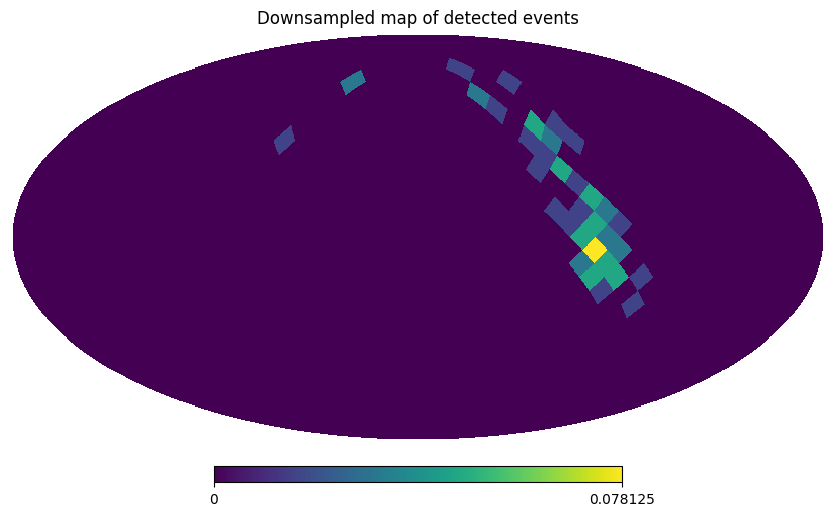

In [9]:
true_event_map = np.zeros(NPIX)
true_event_hp = np.where(ztf_event_rate_table['Gamma'] != 0.0)
true_event_map[true_event_hp] += 1.0

lores_true_event_map = hp.ud_grade(true_event_map, 8)
hp.mollview(lores_true_event_map, title='Downsampled map of detected events')
smooth_true_event_map = hp.ud_grade(lores_true_event_map, 64)

We want to draw a random sample of events, using this data to generate a realistic sample of where these targets will be located.  This should generate a list of HEALpixels where the simulated events are deemed to be located. 

In [10]:
n_samples = 1000
sim_event_hp = random.choices(np.arange(0,NPIX,1), weights=smooth_true_event_map, k=n_samples)

Now plot the original map of actual detected event positions and overplot the on-sky positions of the simulated event sample.

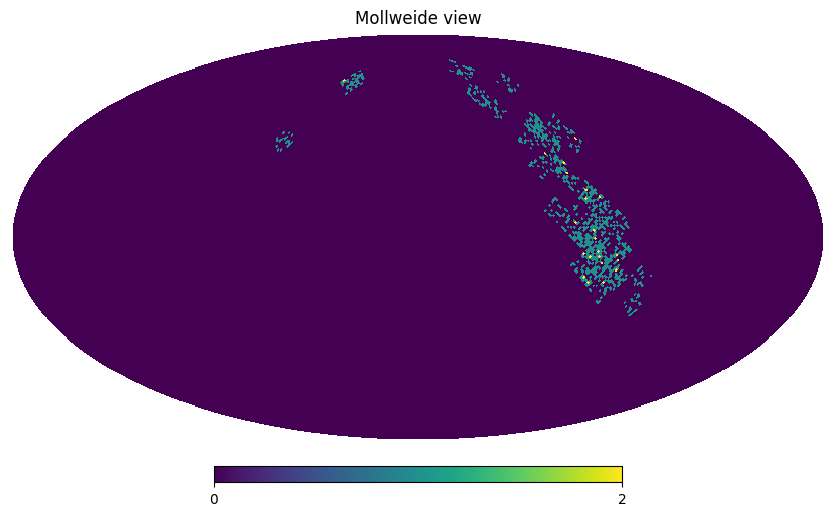

In [11]:
sim_event_map = np.zeros(NPIX)
sim_event_map[sim_event_hp] += 1.0

map_events = sim_event_map + true_event_map
hp.mollview(map_events)

Now convert the HEALpixel positions simulated for the sample of events to RA, Dec locations, assuming that the events are located at the HEALpixel centroids.  

In [12]:
sim_event_coords = ztf_event_rate_table['field_centre'][sim_event_hp]
sim_event_coords

"<SkyCoord (ICRS): (ra, dec) in deg\n (280.546875, 18.20995556)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (281.953125, -9.59406667)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (288.984375, 16.95776111)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (286.875, -0.59684167)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (298.125, 41.01449722)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (291.796875, 38.68218611)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (303.046875, 41.81031389)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (275.625, -16.33482222)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (286.171875, -12.02469722)>"
...
"<SkyCoord (ICRS): (ra, dec) in deg\n (295.3125, 39.45089444)>"


## ZTF Event Baseline Magnitudes

Next we need to simulate the lightcurve data that ZTF would produce for these events.  

The first quantity we need is the baseline magnitude of the events.  Though the ZTF description paper does not seem to  offer a histogram of the number of stars per magnitude bin, it does state that the field of view is 47sq.deg, and the magnitude range in SDSS-r band is 8 - 21.0.  

Instead, we query the ZTF Data Release 15 archive (https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-dd) for a representative sample of detections, which we can download in ASCII format. 

In [46]:
def read_ztf_catalog(file_path):
    file_lines = open(file_path, 'r').readlines()
    data = []
    filterdata = []
    for line in file_lines[0:100]:
        if '/' not in line[0:1] and '|' not in line[0:1] and '\\' not in line[0:1]:
            entries = line.replace('\n','').split()
            row = []
            for x in entries:
                try:
                    row.append(float(x))
                except ValueError:
                    filterdata.append(x)
            data.append(row)
    data = np.array(data)
    
    columns = ['oid', 'ra', 'dec', 'field', 'ccdid', 'qid', 'ngoodobs', 'ngoodobsrel', 'nobs', 'nobsrel',
               'refmag', 'refmagerr', 'astrometricrms', 'chisq', 'magrms', 'maxmag', 'medianabsdev', 'medianmag', 
               'medmagerr', 'minmag', 'dist', 'angle']
    
    table_columns = []
    for i,col in enumerate(columns):
        table_columns.append(Column(name=col, data=data[:,i], dtype=float))
    table_columns.append(Column(name='filtercode', data=filterdata, dtype='str'))
    
    return Table(table_columns)

In [47]:
ztf_catalog_file = './ztf/ztf.ztf_objects_dr15_20188.tbl'
ztf_catalog = read_ztf_catalog(ztf_catalog_file)
ztf_catalog

oid,ra,dec,field,ccdid,qid,ngoodobs,ngoodobsrel,nobs,nobsrel,refmag,refmagerr,astrometricrms,chisq,magrms,maxmag,medianabsdev,medianmag,medmagerr,minmag,dist,angle,filtercode
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2
764204100004272.0,269.841766,45.354709,764.0,4.0,1.0,1143.0,1123.0,1209.0,1189.0,13.507,0.026,3.368616e-07,5.821794,0.05893348,13.69313,0.04128742,13.53447,0.01051441,13.36732,0.893531,148.223608,zr
764104100002941.0,269.8417783,45.3547074,764.0,4.0,1.0,1041.0,1029.0,1144.0,1132.0,14.336,0.01,2.903239e-07,6.287887,0.07182106,14.55145,0.05274963,14.34262,0.01243766,14.17182,0.915113,146.757169,zg
764304100005149.0,269.8417737,45.3547005,764.0,4.0,1.0,146.0,75.0,172.0,97.0,13.215,0.035,4.42677e-07,4.858943,0.06207819,13.34283,0.05088663,13.18402,0.01552694,13.05626,0.929804,148.196157,zi
1763209200008664.0,269.8417838,45.3547012,1763.0,9.0,2.0,56.0,56.0,58.0,58.0,13.554,0.024,3.892876e-07,7.810446,0.0593996,13.62613,0.05332756,13.52777,0.01012278,13.42431,0.941411,146.793604,zr
1763109200005299.0,269.8417887,45.3546935,1763.0,9.0,2.0,44.0,25.0,51.0,30.0,14.31,0.022,5.048048e-07,10.29805,0.06933714,14.4146,0.07483768,14.31047,0.0107743,14.21071,0.971404,147.077268,zg
1763209200047878.0,269.8399777,45.3568871,1763.0,9.0,2.0,0.0,0.0,0.0,0.0,22.026,0.213,0.0,nan,0.0,0.0,0.0,0.0,nan,0.0,8.159555,330.214417,zr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764204100037543.0,269.838482,45.3502772,764.0,4.0,1.0,18.0,18.0,18.0,18.0,22.417,0.322,5.396213e-06,1.839967,0.3860276,21.90929,0.2913923,21.50599,0.2347968,20.58989,18.460431,205.123847,zr
1763109200005325.0,269.8472827,45.3516467,1763.0,9.0,2.0,0.0,0.0,0.0,0.0,22.255,0.265,0.0,nan,0.0,0.0,0.0,0.0,nan,0.0,18.627824,129.239855,zg


Text(0, 0.5, 'Number of stars')

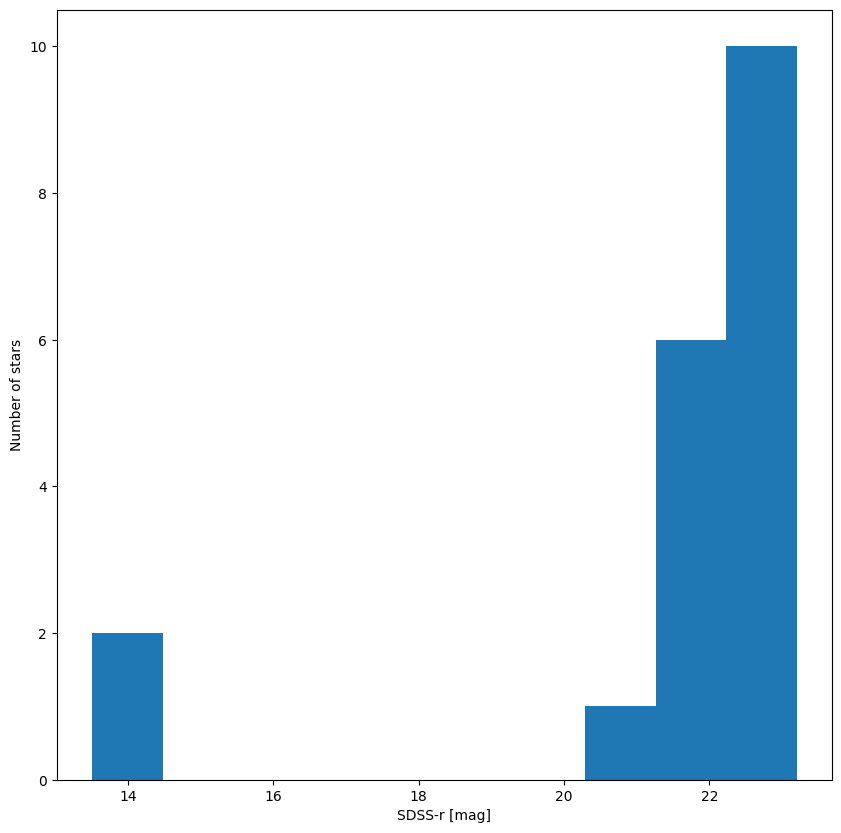

In [52]:
rdata = np.where(ztf_catalog['filtercode'] == 'zr')[0]
mags = ztf_catalog[rdata]['refmag']

fig = plt.figure(1,(10,10))
plt.hist(mags)
plt.xlabel('SDSS-r [mag]')
plt.ylabel('Number of stars')

Text(0.5, 1.0, 'Distribution of reference magnitudes of ZTF Detections')

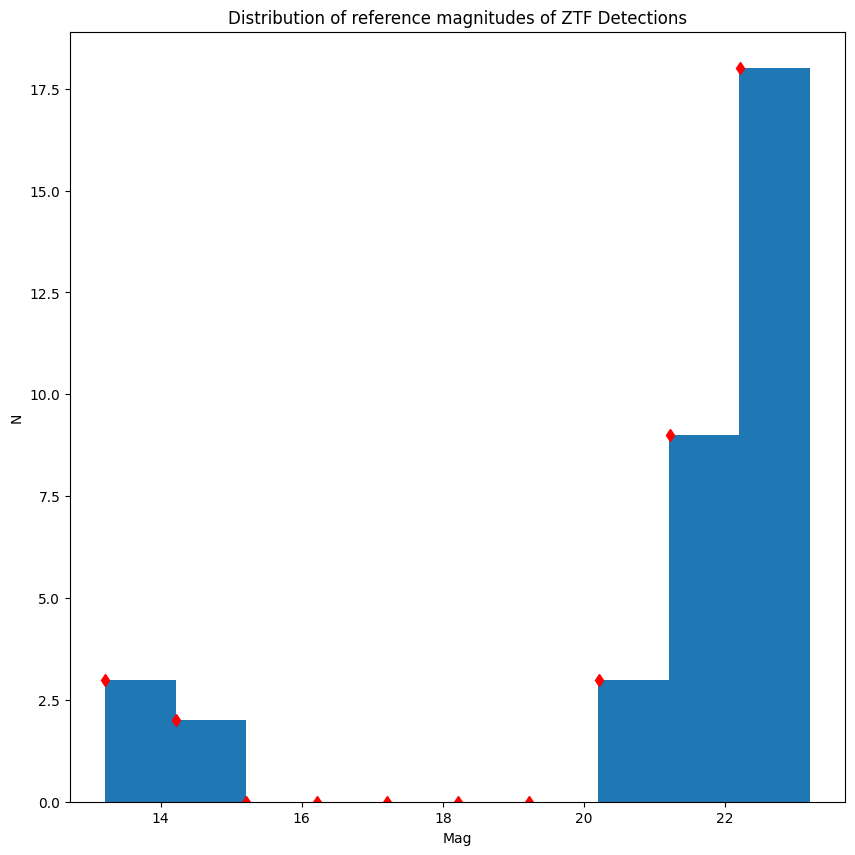

In [57]:
idx = np.where(ztf_catalog['refmag'] > 0.0)
mag_min = ztf_catalog['refmag'][idx].min()
mag_max = ztf_catalog['refmag'][idx].max() + 1.0
(mag_dist, mag_bins) = np.histogram(ztf_catalog['refmag'][idx], bins=np.arange(mag_min, mag_max, 1.0))


fig = plt.figure(1,(10,10))
plt.hist(ztf_catalog['refmag'][idx])
plt.plot(mag_bins[0:-1], mag_dist, 'rd')
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of reference magnitudes of ZTF Detections')

Now we can use this distribution to simulate a realistic range of baseline magnitudes for ZTF detections

Text(0.5, 1.0, 'Distribution of simulated ZTF detections')

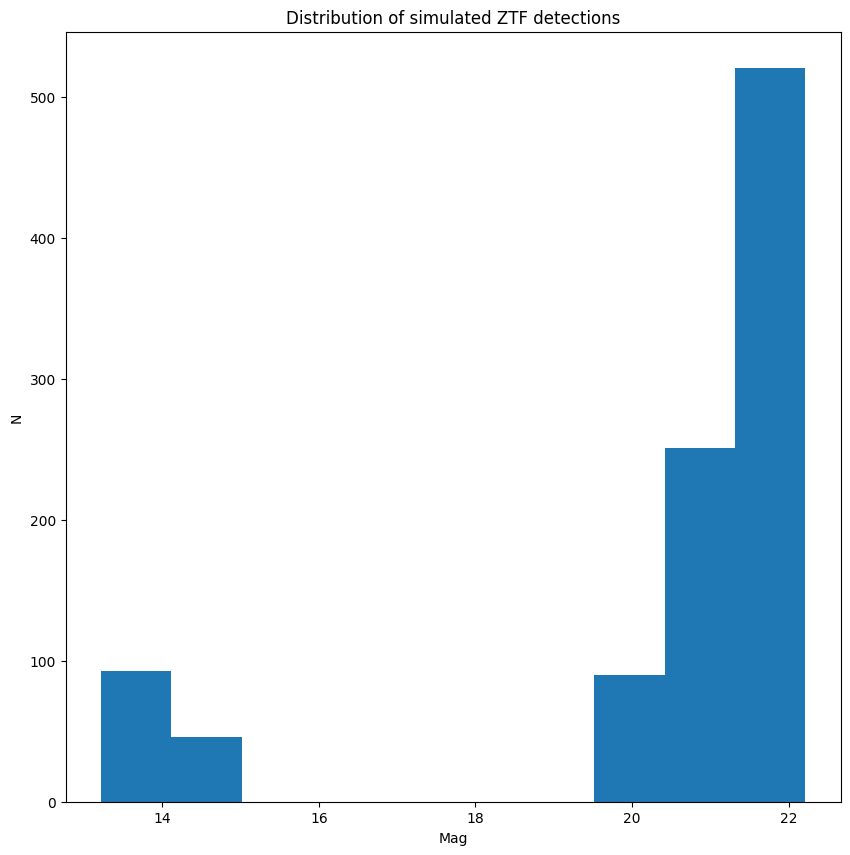

In [58]:
sim_event_mag = random.choices(mag_bins[0:-1], weights=mag_dist, k=n_samples)
fig = plt.figure(1,(10,10))
plt.hist(sim_event_mag)
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of simulated ZTF detections')

## ZTF Event Lensing Parameters

Next, we simulate a realistic range of microlensing event parameters.  We generate a timestamps array first, as the simulated events are constrained to have t0 within the range of the Key Project:

In [59]:
# Time stamps are in Julian Date
start_date = 2460157.50000
end_date = 2461252.50000

In [60]:
def simulate_event_parameters(start_date, end_date, n_sample):
    """Based on code by Markus Hundertmark, adapted to simulate stellar and stellar remnant PSPL events
    within ranges likely to be detected by Gaia
    """
    event_parameters = []
    for i in range(0,n_sample, 1):
        t0 = np.random.uniform(start_date, end_date)
        u0 = np.random.normal(0.141993,0.312678)
        if u0>1:
            u0 = 1
        if  u0<-1:
            u0 = -1
        te = 10.**np.random.normal(1.455351,0.379810)
        rho = abs(np.random.normal(0.008303,0.013883))
        piEN = np.random.normal(0.164267,0.749409)
        piEE = np.random.normal(0.044996,0.259390)
        event_parameters.append([t0,u0,te,rho,piEN,piEE])
    event_parameters = np.array(event_parameters)
    
    return event_parameters

In [61]:
event_parameters = simulate_event_parameters(start_date, end_date, n_samples)
params_list = ['t0','u0','te','rho','piEN','piEE']

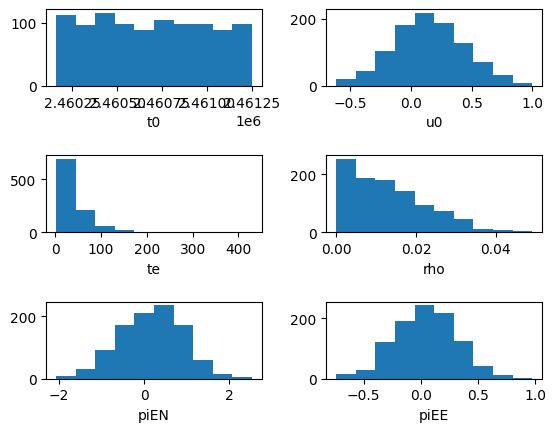

In [62]:
fig, axs = plt.subplots(3, 2)
plt.subplots_adjust(wspace=0.3,hspace=0.9)
idx = 0
for irow in range(0,3,1):
    for icol in range(0,2,1):
        axs[irow, icol].hist(event_parameters[:,idx])
        axs[irow, icol].set_xlabel(params_list[idx])
        idx += 1

For ease of handling, let's combine these data into a single events table

In [65]:
def roundID(num):
    num = str(num)
    while (len(num) < 5):
        num = '0'+num
    return num

sim_event_names = []
for x in range(1,len(sim_event_hp)+1,1):
    sim_event_names.append('ZTFSim'+roundID(x))

In [66]:
events_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name="te", data=event_parameters[:,2], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        ])
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits
str11,int64,object,str32,float64,float64,float64,float64,float64,float64,float64
ZTFSim00001,16967,"<SkyCoord (ICRS): (ra, dec) in deg\n (280.546875, 18.20995556)>",22.215,2460852.804932032,-0.04362528802792487,30.73562907010169,0.006461730522983497,-0.6019977131533791,0.22107949113646858,0.0
ZTFSim00002,28744,"<SkyCoord (ICRS): (ra, dec) in deg\n (281.953125, -9.59406667)>",20.215,2460186.9910481106,-0.04384046345148229,67.98983048232418,0.008356276844566047,0.805462657807752,0.2873231461637078,0.0
ZTFSim00003,17485,"<SkyCoord (ICRS): (ra, dec) in deg\n (288.984375, 16.95776111)>",20.215,2460539.235038167,0.03157626760794652,19.419931160111908,0.011357011207274142,-0.03534340341202449,0.1564595019468876,0.0
ZTFSim00004,24908,"<SkyCoord (ICRS): (ra, dec) in deg\n (286.875, -0.59684167)>",21.215,2460498.9730158546,0.45690083257699854,56.8735422806095,0.02439147438349773,1.2989541864483325,-0.26660727972125403,0.0
ZTFSim00005,8532,"<SkyCoord (ICRS): (ra, dec) in deg\n (298.125, 41.01449722)>",22.215,2460609.6118143955,0.355535098846073,39.26779396669031,0.0077274474835158065,-0.377721816634451,-0.06324711347722956,0.0
ZTFSim00006,9295,"<SkyCoord (ICRS): (ra, dec) in deg\n (291.796875, 38.68218611)>",21.215,2460314.774001841,0.11821319264370739,41.22639267242481,0.04102832316238817,-0.5792982747650068,0.05826864055758906,0.0
...,...,...,...,...,...,...,...,...,...,...
ZTFSim00994,24390,"<SkyCoord (ICRS): (ra, dec) in deg\n (278.4375, 0.59684167)>",22.215,2460603.0924241254,0.053631354794297675,10.408963175968083,0.0010172992055062953,1.2644289026179396,0.27913803965022976,0.0
ZTFSim00995,23371,"<SkyCoord (ICRS): (ra, dec) in deg\n (285.46875, 2.98550556)>",20.215,2461193.6887526987,0.08956305078248092,114.6817655417601,0.003471825461425368,0.42916385723194833,-0.2781787068207768,0.0


### Blending

Note that we implicitly assume zero blending from background stars in the photometry for ZTF events.  Analysis offline has shown that this is a reasonable approximation for events outside the galactic centre, which are the majority of ZTF events. 


## ZTF Event Lightcurve sampling

In order to generate realistic ZTF lightcurves, we used the sampling of ZTF lightcurves from ZTF Data Release 14 to map the number of visits the survey made to each HEALpixel on the sky in the notebook ztf_survey_cadence.  This includes the total number of visits by ZTF between MJD=58194.0 to 59830.0, or 4.4 yrs.  Since this is a longer period than the Key Project, we scale the expected total numbers of visits per filter accordingly.  

In [162]:
ztf14_duration = 59830.0 - 58194.0
kp_duration = 365.24*3.0
scale_factor = kp_duration / ztf14_duration
scale_factor

0.6697555012224939

In [164]:
map_file_path = 'ztf/ztf_nvisits_healpix_table.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

ztf_nvisits = Table([
                        Column(name="HPid", data=data_table['HPid'], dtype='int'),
                        Column(name="Nvisits_all", data=data_table['Nvisits_all']*scale_factor, dtype='int'),
                        Column(name="Nvisits_g", data=data_table['Nvisits_g']*scale_factor, dtype='int'),
                        Column(name="Nvisits_r", data=data_table['Nvisits_r']*scale_factor, dtype='int'),
                        Column(name="Nvisits_i", data=data_table['Nvisits_i']*scale_factor, dtype='int'),
                        ])
ztf_nvisits

HPid,Nvisits_all,Nvisits_g,Nvisits_r,Nvisits_i
int64,int64,int64,int64,int64
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
5,71,32,39,0
6,0,0,0,0
...,...,...,...,...
49146,0,0,0,0
49147,0,0,0,0


Assign the numbers of visits to each simulated event, based on the HEALpixel where it was detected, and add this to the events_table.  

In [165]:
events_table['nvisits_g'] = ztf_nvisits['Nvisits_g'][events_table['HP']-1]  # Off-by-one to match Python's number-from-zero
events_table['nvisits_r'] = ztf_nvisits['Nvisits_r'][events_table['HP']-1]  # Off-by-one to match Python's number-from-zero
events_table['nvisits_i'] = ztf_nvisits['Nvisits_i'][events_table['HP']-1]  # Off-by-one to match Python's number-from-zero
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits,nvisits_g,nvisits_r,nvisits_i
str11,int64,object,str32,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
ZTFSim00001,16967,"<SkyCoord (ICRS): (ra, dec) in deg\n (280.546875, 18.20995556)>",22.215,2460852.804932032,-0.04362528802792487,30.73562907010169,0.006461730522983497,-0.6019977131533791,0.22107949113646858,1201,236,551,16
ZTFSim00002,28744,"<SkyCoord (ICRS): (ra, dec) in deg\n (281.953125, -9.59406667)>",20.215,2460186.9910481106,-0.04384046345148229,67.98983048232418,0.008356276844566047,0.805462657807752,0.2873231461637078,1786,207,837,151
ZTFSim00003,17485,"<SkyCoord (ICRS): (ra, dec) in deg\n (288.984375, 16.95776111)>",20.215,2460539.235038167,0.03157626760794652,19.419931160111908,0.011357011207274142,-0.03534340341202449,0.1564595019468876,1969,443,760,115
ZTFSim00004,24908,"<SkyCoord (ICRS): (ra, dec) in deg\n (286.875, -0.59684167)>",21.215,2460498.9730158546,0.45690083257699854,56.8735422806095,0.02439147438349773,1.2989541864483325,-0.26660727972125403,1533,224,675,126
ZTFSim00005,8532,"<SkyCoord (ICRS): (ra, dec) in deg\n (298.125, 41.01449722)>",22.215,2460609.6118143955,0.355535098846073,39.26779396669031,0.0077274474835158065,-0.377721816634451,-0.06324711347722956,1573,356,685,11
ZTFSim00006,9295,"<SkyCoord (ICRS): (ra, dec) in deg\n (291.796875, 38.68218611)>",21.215,2460314.774001841,0.11821319264370739,41.22639267242481,0.04102832316238817,-0.5792982747650068,0.05826864055758906,1459,310,655,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFSim00994,24390,"<SkyCoord (ICRS): (ra, dec) in deg\n (278.4375, 0.59684167)>",22.215,2460603.0924241254,0.053631354794297675,10.408963175968083,0.0010172992055062953,1.2644289026179396,0.27913803965022976,997,194,472,0
ZTFSim00995,23371,"<SkyCoord (ICRS): (ra, dec) in deg\n (285.46875, 2.98550556)>",20.215,2461193.6887526987,0.08956305078248092,114.6817655417601,0.003471825461425368,0.42916385723194833,-0.2781787068207768,2888,558,1168,207


Store the table of simulated event parameters

In [166]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))
column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='nvisits_g', array=events_table['nvisits_g'], format='I5'))
column_list.append(fits.Column(name='nvisits_r', array=events_table['nvisits_r'], format='I5'))
column_list.append(fits.Column(name='nvisits_i', array=events_table['nvisits_i'], format='I5'))
hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_ztf_events_table.fits', overwrite=True)


## ZTF Event Lightcurves

Now we can simulate the lightcurves that ZTF would produce for these simulated events.  We assume that ZTF's survey strategy for the public Galactic Plane survey is roughly consistent with its previous strategy, and approximate the distribution of visits in the different filters as uniform.  

Firstly though, we need to establish a photometric noise function for the magnitude uncertainties in the lightcurve. This we can do using the photometry derived from the ZTF catalog above to derive noise model coefficients for the three bandpasses.  

In [167]:
gdata = np.where(ztf_catalog['filtercode']=='zg')[0]
rdata = np.where(ztf_catalog['filtercode']=='zr')[0]
idata = np.where(ztf_catalog['filtercode']=='zi')[0]

gmags = np.zeros((len(gdata),2))
rmags = np.zeros((len(rdata),2))
imags = np.zeros((len(idata),2))
gmags[:,0] = ztf_catalog[gdata]['refmag']
gmags[:,1] = np.log10(ztf_catalog[gdata]['refmagerr'])
rmags[:,0] = ztf_catalog[rdata]['refmag']
rmags[:,1] = np.log10(ztf_catalog[rdata]['refmagerr'])
imags[:,0] = ztf_catalog[idata]['refmag']
imags[:,1] = np.log10(ztf_catalog[idata]['refmagerr'])

In [168]:
def straight_line(x, a, b):
    return a + b*x

In [169]:
(gparam, gcov) = optimize.curve_fit(straight_line, gmags[:,0], gmags[:,1])
(rparam, rcov) = optimize.curve_fit(straight_line, rmags[:,0], rmags[:,1])
(iparam, icov) = optimize.curve_fit(straight_line, imags[:,0], imags[:,1])

Text(0, 0.5, 'Mag err')

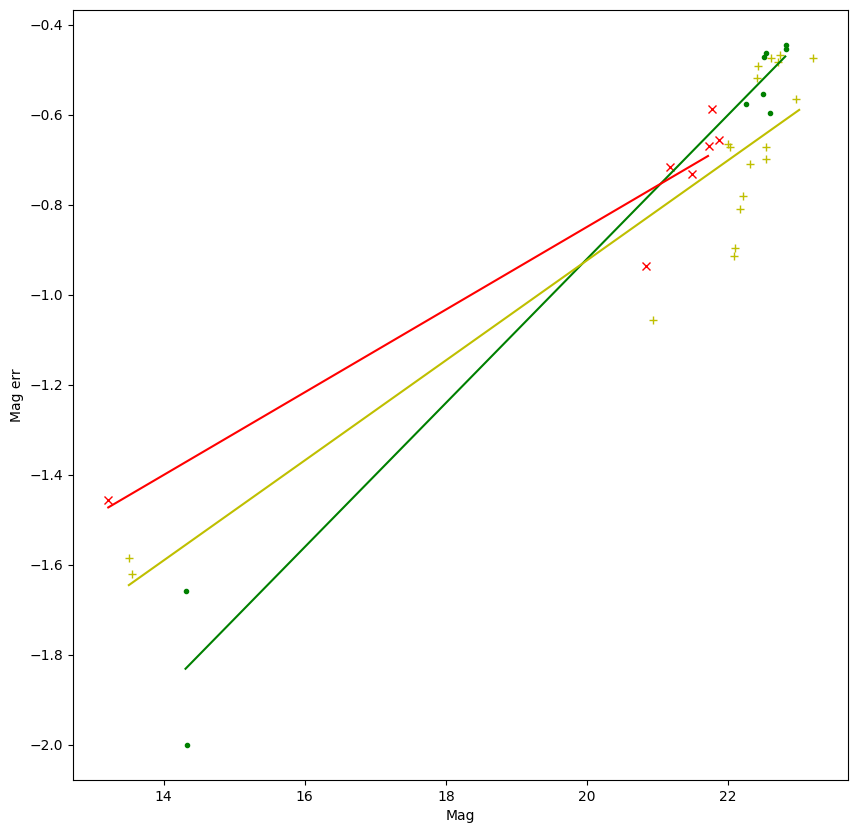

In [170]:
fig = plt.figure(2,(10,10))
plt.plot(gmags[:,0], gmags[:,1], 'g.', label='ZTF-g')
plt.plot(rmags[:,0], rmags[:,1], 'y+', label='ZTF-r')
plt.plot(imags[:,0], imags[:,1], 'rx', label='ZTF-i')

xdata = np.arange(gmags[:,0].min(), gmags[:,0].max(), 0.25)
ydata = straight_line(xdata, gparam[0], gparam[1])
plt.plot(xdata, ydata, 'g-')

xdata = np.arange(rmags[:,0].min(), rmags[:,0].max(), 0.25)
ydata = straight_line(xdata, rparam[0], rparam[1])
plt.plot(xdata, ydata, 'y-')

xdata = np.arange(imags[:,0].min(), imags[:,0].max(), 0.25)
ydata = straight_line(xdata, iparam[0], iparam[1])
plt.plot(xdata, ydata, 'r-')

plt.xlabel('Mag')
plt.ylabel('Mag err')

In [171]:
noise_model = {'g': gparam, 'r': rparam, 'i': iparam}

In [172]:
def simulate_event_ztf(event_params, noise_model, start_date, end_date, parallax=True):
    """Expects parameters from an entry in the events_table above.
    """
    
    # Loop over all three filters and simulate the event separately in the different passbands
    # to ensure the proper noise properties and sampling are handled correctly.  
    sim_events = {}
    for f in ['g', 'r', 'i']:
    
        # Simulate timestamps in this filter
        cadence = (end_date - start_date) / event_params['nvisits_'+f]
        timestamps = np.arange(start_date, end_date, cadence)
    
        # Create a PyLIMA event object
        sim_event = event.Event()
        sim_event.name = event_params['EventID']
        sim_event.ra = float(event_params['location'].ra.deg)
        sim_event.dec = float(event_params['location'].dec.deg)

        # Generate a constant lightcurve at the event's baseline magnitude (neglecting differences due to color), 
        # with fixed photometric uncertainties, since these will be replaced later
        lc = np.zeros((len(timestamps),3))
        lc[:,0] = timestamps
        lc[:,1] = [float(event_params['baseline_mag'])] * len(timestamps)
        lc[:,2] = [0.01] * len(timestamps)
        print(float(event_params['baseline_mag']), np.median(lc[:,1]))
    
        # Add a PyLIMA telescope object to the event with this lightcurve, and add it to the event
        tel = telescopes.Telescope(name='ZTF', camera_filter=f,
                                         light_curve_magnitude=lc,
                                         location='Earth',
                                         light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                         clean_the_lightcurve=False)

        sim_event.telescopes.append(tel)
        sim_event.find_survey('ZTF')
    
        # Add a PyLIMA model to the event, using the simulated parameters
        if parallax:
            sim_model = microlmodels.create_model('FSPL', sim_event,
                                              parallax=['Full',float(event_params['t0'])])
            lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                                  float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]

        else:
            sim_model = microlmodels.create_model('FSPL', sim_event)
            lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho'])]

        sim_model.define_model_parameters()
    
        if parallax:
            sim_model.event.compute_parallax_all_telescopes(sim_model.parallax_model)
        
        tel = sim_model.event.telescopes[0]
    
        pylima_parameters = sim_model.compute_pyLIMA_parameters(lensing_parameters)
        #print(event_params)
    
        # Use the PyLIMA model to add a lensing event into the lightcurve
        magnification = sim_model.model_magnification(tel, pylima_parameters)
        A = sim_model.model_magnification(tel,pylima_parameters)
        lightcurve = sim_event.telescopes[0].lightcurve_magnitude
        lightcurve[:,1] = lightcurve[:,1] + -2.5*np.log10(A)
        log_errors = straight_line(lightcurve[:,1], noise_model[f][0], noise_model[f][1])
        lightcurve[:,2] = 10**(log_errors)
        sim_event.telescopes[0].lightcurve_magnitude = lightcurve
        print(float(event_params['baseline_mag']), np.median(lightcurve[:,1]))
        
        sim_events[f] = sim_event
        
    # Microlensing lightcurves are independent of color to first order.  In the interests of re-using
    # code below, we combine the simulated lightcurve in different colors into a single array
    # for convenience
    
    ztf_event = event.Event()
    ztf_event.name = event_params['EventID']
    ztf_event.ra = float(event_params['location'].ra.deg)
    ztf_event.dec = float(event_params['location'].dec.deg)
    
    lightcurve = np.concatenate((sim_events['g'].telescopes[0].lightcurve_magnitude, 
                                 sim_events['r'].telescopes[0].lightcurve_magnitude))
    lightcurve = np.concatenate((lightcurve, 
                                 sim_events['i'].telescopes[0].lightcurve_magnitude))
    
    tel = telescopes.Telescope(name='ZTF', camera_filter=f,
                                     light_curve_magnitude=lightcurve,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    ztf_event.telescopes.append(tel)
    ztf_event.find_survey('ZTF')
    
    if parallax:
        ztf_model = microlmodels.create_model('FSPL', ztf_event,
                                          parallax=['Full',float(event_params['t0'])])
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]

    else:
        ztf_model = microlmodels.create_model('FSPL', ztf_event)
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                          float(event_params['rho'])]

    ztf_model.define_model_parameters()

    if parallax:
        ztf_model.event.compute_parallax_all_telescopes(ztf_model.parallax_model)

    pylima_parameters = ztf_model.compute_pyLIMA_parameters(lensing_parameters)

    return ztf_event, ztf_model, lensing_parameters

Parallax for ZTF events is predominately the annual parallax signature caused by the motion of the Earth during an event, which PyLIMA can calculate internally.  

In [173]:
# Pick a bright event as a test case:
event_number = 0
while (float(events_table[event_number]['baseline_mag']) > 18.0):
    event_number += 1
print('Picked bright event: ',event_number,' baseline_mag=',events_table[event_number]['baseline_mag'],'mag')

ztf_lens, ztf_lens_model, lens_model_pars = simulate_event_ztf(events_table[event_number], noise_model, start_date, end_date, parallax=True)



Picked bright event:  6  baseline_mag= 13.215 mag
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.19679092999522
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.196816916284478
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.196862292430344
Parallax(Full) estimated for the telescope ZTF: SUCCESS


  EventID    HP                               location                              baseline_mag         t0                 u0                 te                 rho                 piEN                piEE         nvisits nvisits_g nvisits_r nvisits_i
----------- ---- ------------------------------------------------------------------ ------------ ----------------- ------------------- ------------------ -------------------- ------------------ -------------------- ------- --------- --------- ---------
ZTFSim00007 8279 <SkyCoord (ICRS): (ra, dec) in deg\n    (303.046875, 41.81031389)>       13.215 2460643.663053141 -0.0491053053809197 128.95956985808448 0.013899165053976384 0.2161940104053539 0.013712628248460215    1888       482       665       116


Text(0.5, 1.0, 'Simulated event ZTFSim00007')

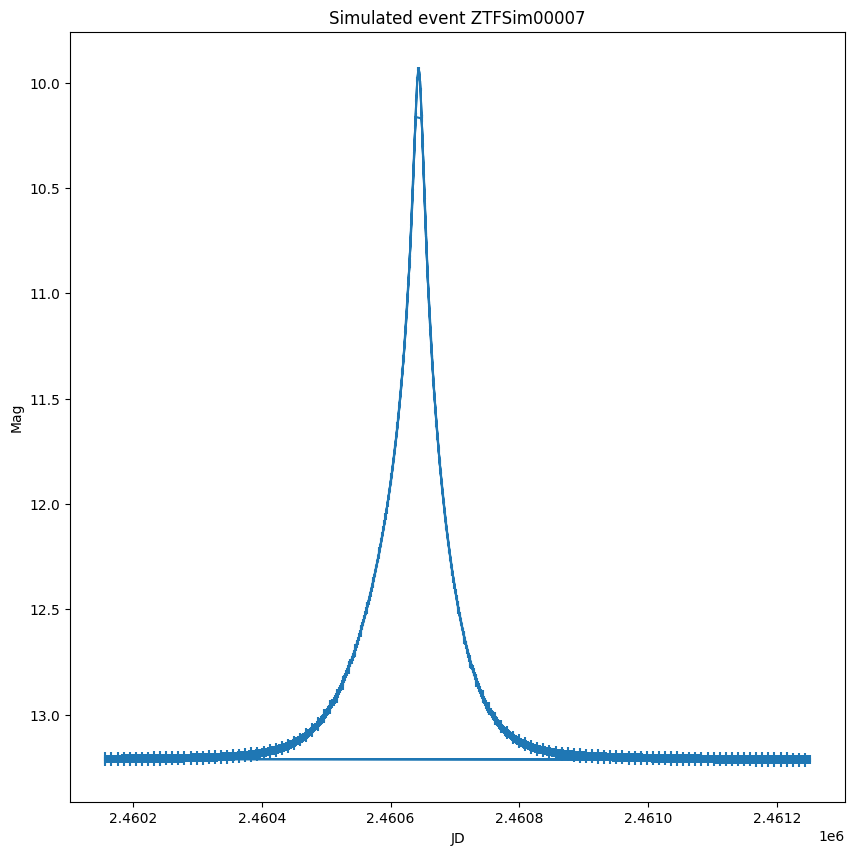

In [174]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc = ztf_lens.telescopes[0].lightcurve_magnitude
plt.errorbar(lc[:,0], lc[:,1], yerr=lc[:,2])
[xmin, xmax, ymin, ymax] = plt.axis()
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.title('Simulated event '+events_table[event_number]['EventID'])

Simulate all events

In [175]:
sim_ztf_lenses = []
sim_ztf_lens_models = []
sim_model_params = []

for ievent in range(0,len(events_table),1):
    (ztf_lens, ztf_lens_model, lens_model_pars) = simulate_event_ztf(events_table[ievent], noise_model, start_date, end_date, parallax=True)
    sim_ztf_lenses.append(ztf_lens)
    sim_ztf_lens_models.append(ztf_lens_model)
    sim_model_params.append(lens_model_pars)
    print(ievent, sim_model_params[-1])

22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214842704011545
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214842634834955
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214843083622384
Parallax(Full) estimated for the telescope ZTF: SUCCESS
0 [2460852.804932032, -0.04362528802792487, 30.73562907010169, 0.006461730522983497, -0.6019977131533791, 0.22107949113646858]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214885820391853
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214888274405997
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214884584406963
Parallax(Full) estimated for the telescope ZTF: SUCCESS
1 [2460186.9910481106, -0.04384046345148229, 67.98983048232418, 0.008356276844566047, 0.805462657807752, 0.2873231461637078]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21496195508305
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214961578072575
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214959231795568
Parallax(Full) estimated for the telescope ZTF: SUCCESS
19 [2460936.2922139135, -0.16375331530257822, 20.470264460748083, 0.008585777925617735, 0.45352843263565584, 0.25181532871138235]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214990740326378
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.21498954658188
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214994701801992
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20 [2461055.703691911, 0.20012872116434632, 13.50276316962876, 0.0346119233561302, 0.7420642759460174, 0.70855883361078]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
36 [2460440.9167771633, 0.02810624122303633, 91.63217407115508, 0.01963869801180472, 0.5355620331401041, -0.07482116521191284]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214985394307178
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214985639190072
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214986088691212
Parallax(Full) estimated for the telescope ZTF: SUCCESS
37 [2461091.2609503404, 0.01647820664299357, 19.36270274779222, 0.02157253564300962, 1.141134281867651, -0.08019228979026438]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214981286125703
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214981185828613
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214981496466226
Parallax(Full) estimated for the telescope ZTF: SUCCESS
38 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.212095677202704
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21217612038847
Parallax(Full) estimated for the telescope ZTF: SUCCESS
55 [2461212.323099116, 0.2894486665820881, 234.9325431813396, 0.01134602046410637, 0.6006159740056605, -0.05287895973583016]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21335299883812
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213367121538276
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.127161756939703
Parallax(Full) estimated for the telescope ZTF: SUCCESS
56 [2460324.930392563, -0.14643791759297767, 115.81555832743277, 0.04727557180423959, 0.5172682588319615, -0.3424826110668434]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21327464623282
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
73 [2461081.683772374, 0.5121752208935376, 37.66110628697815, 0.02738001439007324, 0.00013758391575247053, -0.30297936330130193]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999998960034
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999998962895
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999998998724
Parallax(Full) estimated for the telescope ZTF: SUCCESS
74 [2460769.0146582047, 0.45954546796741624, 1.2571071614868767, 0.021411642058335033, 0.5966596211200188, 0.38273942111830267]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.2149828447573
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214982421306892
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214983200588726
Parallax(Full) estimated for the telescope ZTF: SUCCESS
7

Parallax(Full) estimated for the telescope ZTF: SUCCESS
91 [2460868.167469224, 0.37659677988264195, 39.50262268137709, 0.02692123465358407, -0.585250848343446, -0.07621800581927726]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214643069698653
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214645393658692
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21463584058722
Parallax(Full) estimated for the telescope ZTF: SUCCESS
92 [2460328.2116069477, -0.016278491740857687, 63.29151644469481, 0.004698001126117306, -0.9252640825960017, -0.07874473950830949]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214804469492726
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21480757428171
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21498719271399
Parallax(Full) estimated for the telescope ZTF: SUCCESS
93

Parallax(Full) estimated for the telescope ZTF: SUCCESS
109 [2460918.3819402508, -0.2685487673364917, 20.641706334593035, 0.02859817085436396, -0.15730514013627173, -0.023520830432741967]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214650511760393
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214652354124894
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214671773106524
Parallax(Full) estimated for the telescope ZTF: SUCCESS
110 [2460447.003642864, -0.11237793477147243, 30.753795436640534, 0.009682204523895796, -0.41614329840331205, -0.32771674285623]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214994723932953
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214994688024934
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499471897919
Parallax(Full) estimated for the telescope ZTF: SUCC

Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21498270675439
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21498287996101
Parallax(Full) estimated for the telescope ZTF: SUCCESS
128 [2460300.020790778, -0.03553615816112429, 22.19751964590233, 0.015938193692162005, -0.42301388332437834, -0.06816074876388462]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21166031511266
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.211707125796615
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.211751677873863
Parallax(Full) estimated for the telescope ZTF: SUCCESS
129 [2460958.1381164026, 0.24622148284132966, 55.182440061578845, 0.011880106390469493, -0.0713349548146813, 0.057663378834948126]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21498871710881
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCES

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214747648597513
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214801736384267
Parallax(Full) estimated for the telescope ZTF: SUCCESS
147 [2460983.0375625715, -0.191095188888701, 26.782848707138296, 0.009031127706967628, 0.11418133704251472, 0.4205134584156092]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21492733419509
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214927193176628
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214927291063773
Parallax(Full) estimated for the telescope ZTF: SUCCESS
148 [2460768.17125811, -0.11000987431897816, 15.88770054270955, 0.003103291071475755, 1.1523745673428913, -0.1278637188522127]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214600317859741
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499971071365
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499971408209
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214999707377473
Parallax(Full) estimated for the telescope ZTF: SUCCESS
165 [2460376.3529281174, -0.0770944853347896, 6.4868965233964415, 0.029770736497265055, -0.8959950202637748, -0.05982654268616006]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214941269417018
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21494127639251
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21494214978266
Parallax(Full) estimated for the telescope ZTF: SUCCESS
166 [2460486.6133623314, 0.050121538795827245, 20.226384760729598, 0.023260814166110158, -0.32124746939231064, -0.021276894285755264]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUC

Parallax(Full) estimated for the telescope ZTF: SUCCESS
183 [2461014.226429113, 0.6473083607419013, 28.796740653468646, 0.003986286207640617, 0.514608734502662, -0.15214870671465588]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214474056394792
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21447469063962
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214466549692897
Parallax(Full) estimated for the telescope ZTF: SUCCESS
184 [2460780.6663171407, 0.291520091931271, 35.02851855016566, 0.03930445779438793, -0.4072732264801638, -0.25419838779569354]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214997625160965
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214997664783091
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.157486923976393
Parallax(Full) estimated for the telescope ZTF: SUCCESS
185

Parallax(Full) estimated for the telescope ZTF: SUCCESS
201 [2460762.8661914957, -0.14732130049753325, 34.03774411660193, 0.02750806360889218, 0.5157981503397303, 0.31301322475931703]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214992518191387
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499247935361
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214994095270587
Parallax(Full) estimated for the telescope ZTF: SUCCESS
202 [2461105.4718657797, -0.09442849983764454, 22.428679101267644, 0.009709039876093156, -0.5769656620902419, -0.6175618332489846]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999597947692
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499960143806
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999588903314
Parallax(Full) estimated for the telescope ZTF: SUCCESS

Parallax(Full) estimated for the telescope ZTF: SUCCESS
219 [2460196.8036308056, 0.34257924235720355, 29.172923300913304, 0.01794013547809003, -0.8425460402791141, -0.1312892697005601]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21493388449116
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21493388760679
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21493168690942
Parallax(Full) estimated for the telescope ZTF: SUCCESS
220 [2460467.157544691, 0.29856225543302406, 18.584988334062032, 0.006288817758580435, 0.2656329512071271, -0.2072749925078389]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214988057867647
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214987924988336
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214988099501042
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22

Parallax(Full) estimated for the telescope ZTF: SUCCESS
237 [2460538.9494636687, -0.18001676616532877, 23.489583221334197, 0.00038420016434983703, 0.19999887410206194, 0.01973060694031685]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999372957386
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999380763615
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999159489228
Parallax(Full) estimated for the telescope ZTF: SUCCESS
238 [2460299.1066040713, 0.07324103737949476, 9.889217017054385, 0.028111742785511006, 0.21699714712539792, -0.34640346085940965]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.213415762252474
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.213403185231485
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21398531599167
Parallax(Full) estimated for the telescope ZTF: SU

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214720817775614
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214523577200094
Parallax(Full) estimated for the telescope ZTF: SUCCESS
255 [2460355.5457083164, 0.444908060042295, 31.385298492622177, 0.016458307804886756, 0.3224270760253618, 0.15131308649057038]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214432862165804
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.2144205611067
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214420561106648
Parallax(Full) estimated for the telescope ZTF: SUCCESS
256 [2461089.9211821486, 0.009809742227438273, 48.810929826125324, 0.030379369332685528, 0.496683730900409, -0.11233097780080711]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214989050437666
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
273 [2460893.112338384, 0.2681215795178359, 37.82281650953939, 0.017974362814254307, 0.6090881764563334, -0.24616778703927847]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.195329362289687
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.19522357821782
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 21.99024214774382
Parallax(Full) estimated for the telescope ZTF: SUCCESS
274 [2460753.1559019256, 0.05468245423654611, 63.52945054128029, 0.014090275993449213, 0.5026667278927905, 0.24741936511923768]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21156739482626
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.211587852488293
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.210800525325485
Parallax(Full) estimated for the telescope ZTF: SUCCESS
275 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214248301067784
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214517418950484
Parallax(Full) estimated for the telescope ZTF: SUCCESS
291 [2461164.194983408, 0.4770846111097379, 157.54346567828028, 0.018023119008961176, -0.6330450178996474, 0.4245109645547776]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214948556187753
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.2149485588458
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21494947511029
Parallax(Full) estimated for the telescope ZTF: SUCCESS
292 [2460503.1068407786, 0.447143432729492, 16.391319361217302, 0.017001871326657404, 0.029944521725651818, -0.44416578446211585]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21493344193328
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214960133664874
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21496046455229
Parallax(Full) estimated for the telescope ZTF: SUCCESS
310 [2460420.5252500228, 0.09274921136221467, 22.750946188341974, 0.009175034392901604, -0.47417347140690297, 0.21773280528104946]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21440396731769
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21441055032455
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214382325870467
Parallax(Full) estimated for the telescope ZTF: SUCCESS
311 [2460381.4470157735, -0.44490165983127994, 49.41764103391753, 0.012545833222939434, -0.3965996292319422, -0.020581092328804042]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.212402429994642
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCC

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214967005261467
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214967002580096
Parallax(Full) estimated for the telescope ZTF: SUCCESS
328 [2460666.782793037, -0.15086717484544285, 18.407604024984025, 0.02530121516196312, 0.5666874201594951, -0.14410284343316587]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214997867019854
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.2149978673647
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214995346322972
Parallax(Full) estimated for the telescope ZTF: SUCCESS
329 [2460873.8610130954, 0.4593440957016427, 8.918639523157742, 0.024730577411285072, 0.43961609968933096, 0.09422622201188233]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21403825707933
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.2149319560288
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214931957321994
Parallax(Full) estimated for the telescope ZTF: SUCCESS
346 [2460648.546191781, 0.04140874783283503, 21.368001082437136, 0.009436957188166775, 0.14751578580180208, 0.10211791278807884]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214857039580355
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214855900157797
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21485481767848
Parallax(Full) estimated for the telescope ZTF: SUCCESS
347 [2461062.860058903, -0.32513164598144617, 34.632613333948036, 0.025350541510197902, 0.13524614984008704, -0.004736215278031045]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214418428535685
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCES

Parallax(Full) estimated for the telescope ZTF: SUCCESS
365 [2460970.8280116203, 0.21118932480471322, 34.5010393870049, 0.011409912119778936, -0.7589228046362062, 0.027918444637877193]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214755728338208
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214752852685436
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214988308685548
Parallax(Full) estimated for the telescope ZTF: SUCCESS
366 [2461180.5168655994, 0.19386152228209336, 45.411172777172325, 0.023238733840569206, -0.4289186902629329, -0.25319551863922174]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.211489028488373
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.211500056849687
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.211481586700025
Parallax(Full) estimated for the telescope ZTF: SUCC

Parallax(Full) estimated for the telescope ZTF: SUCCESS
383 [2460183.903137817, 0.10855358844343646, 63.55881383245989, 0.02586447934309659, 1.3313715118790763, -0.019534194808970416]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.207709152049892
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.207708444829455
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.207709587424866
Parallax(Full) estimated for the telescope ZTF: SUCCESS
384 [2460648.609328864, 0.05845723682909963, 132.93848555115804, 0.006488304302896696, 0.6415969404697746, 0.13553745012896914]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214713971367097
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214704719298588
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21469612300542
Parallax(Full) estimated for the telescope ZTF: SUCCESS
3

Parallax(Full) estimated for the telescope ZTF: SUCCESS
401 [2460314.991325041, 0.13231129714283887, 112.81733827031297, 0.03982881562713818, 0.014319201061915393, -0.011586206756906685]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499600981671
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.2149959640549
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499601157438
Parallax(Full) estimated for the telescope ZTF: SUCCESS
402 [2460320.380385736, 0.3757108244824427, 13.595392755797985, 0.004742111730058299, -0.10062732183746614, 0.2022456497584536]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214985752086687
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214985804365593
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21498538855311
Parallax(Full) estimated for the telescope ZTF: SUCCESS
40

Parallax(Full) estimated for the telescope ZTF: SUCCESS
419 [2460455.023857068, 0.3226520298002111, 54.07423165602458, 0.013267330384735892, 0.7999328890968018, -0.12150106210108375]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214915906339186
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214918222938216
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214997511732662
Parallax(Full) estimated for the telescope ZTF: SUCCESS
420 [2460836.463628722, -0.03727809358996198, 27.629123254295557, 0.0020538265891649763, -0.5753436791725519, 0.405404326480853]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214993834074583
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214993780535952
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499372661988
Parallax(Full) estimated for the telescope ZTF: SUCCESS
4

Parallax(Full) estimated for the telescope ZTF: SUCCESS
437 [2460570.322657785, 0.1450613958574208, 24.15867331200734, 0.002733491815490832, -0.13038557175976184, 0.07960211780077901]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21469717887192
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21469768337696
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21471114392786
Parallax(Full) estimated for the telescope ZTF: SUCCESS
438 [2460806.30085249, -0.49768793207051654, 43.71967276130153, 0.014259100797882906, -0.9714143668037012, 0.06796441958360375]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214968989354468
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214969191145506
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214984046787393
Parallax(Full) estimated for the telescope ZTF: SUCCESS
439

Parallax(Full) estimated for the telescope ZTF: SUCCESS
455 [2460976.742147276, 0.2976634705207629, 17.23477048208903, 0.0028220822780124274, 0.06205448395962912, 0.34551337845330937]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214953401616597
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21495403254339
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21495435624263
Parallax(Full) estimated for the telescope ZTF: SUCCESS
456 [2460584.470543909, 1.0, 18.22793531384741, 0.00219662740816815, -0.5130345763625082, 0.4457966075313541]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214382190890397
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214381741828532
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214522192175785
Parallax(Full) estimated for the telescope ZTF: SUCCESS
457 [2460957.8465307

Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.193150316038018
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.192961749101002
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.192474409452053
Parallax(Full) estimated for the telescope ZTF: SUCCESS
474 [2460803.262456497, -0.10782978944971175, 84.51232492350562, 0.0011248552732494345, -0.0023110011873377356, -0.15880591161686658]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214351200427096
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21433055650747
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214331928955914
Parallax(Full) estimated for the telescope ZTF: SUCCESS
475 [2460798.0215870943, 0.19342451165082475, 40.900893631824616, 0.0006118459312822802, -0.31503015464764167, 0.11418069919993237]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF:

Parallax(Full) estimated for the telescope ZTF: SUCCESS
491 [2460192.7169801607, 0.2952566864906243, 18.975228522613953, 0.007683804477906125, 0.06830554432804624, -0.09084315162562304]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214998466679834
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214998472645796
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214998360819592
Parallax(Full) estimated for the telescope ZTF: SUCCESS
492 [2460545.8510641297, -0.14571388154214668, 7.81811388604924, 0.0027264922655001207, -0.12790494332568786, -0.01724307773046535]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214980426040253
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214980209912646
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21498108924443
Parallax(Full) estimated for the telescope ZTF: SUC

Parallax(Full) estimated for the telescope ZTF: SUCCESS
510 [2460282.440723424, -0.08707030293467827, 20.354569890130453, 0.01646086274519603, -1.1588003630635522, 0.11084978669462148]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213772496326712
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213793771955988
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.211362650167253
Parallax(Full) estimated for the telescope ZTF: SUCCESS
511 [2460354.041926676, 0.14585214546808267, 70.29909263326144, 0.007109655158920835, -0.7440133851027457, 0.8696220578667236]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214998150467196
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214998175273376
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499806823053
Parallax(Full) estimated for the telescope ZTF: SUCCESS
5

Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.213569865880196
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.2135707892251
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21356456894522
Parallax(Full) estimated for the telescope ZTF: SUCCESS
528 [2460781.7460397305, 0.23963685921455252, 65.22405913734995, 0.011507968218041337, -0.6952997380774542, -0.6142923354770442]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.197619154440368
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.197623555488974
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.197718200962086
Parallax(Full) estimated for the telescope ZTF: SUCCESS
529 [2460604.946696196, 0.6545171174862987, 97.623369089617, 0.02949394090254199, -0.47738079894509927, -0.22741604266035606]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
545 [2460892.7527566026, 0.5797976097673431, 11.788028527024707, 0.002798969991694689, -0.034662017383874144, 0.2629584997344008]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499458609382
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499460629953
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214994445449044
Parallax(Full) estimated for the telescope ZTF: SUCCESS
546 [2460158.0862392606, 0.05214272173236152, 24.086544754664693, 0.00528516313853895, 0.10881012455063357, 0.24796441092401883]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214980259076947
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214981555650901
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214256410744376
Parallax(Full) estimated for the telescope ZTF: SUCCESS

Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999968810229
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999969013997
Parallax(Full) estimated for the telescope ZTF: SUCCESS
563 [2460363.6480838475, -0.24150521145944678, 3.603592731580496, 0.013958137209632272, 0.7289254985923801, 0.6524253453851321]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214996066621083
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499615555231
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214970156241762
Parallax(Full) estimated for the telescope ZTF: SUCCESS
564 [2460358.3333180672, -0.03582653408606229, 13.474784688355193, 0.0012011377047010073, -1.08320085311982, 0.10229681166071236]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21498330575596
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
580 [2460898.801825112, 0.029187416329682594, 162.95178946552954, 0.001952354188262605, 1.2982607287319343, 0.36707448999247017]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.211244181566325
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.2114829672499
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.137066637608054
Parallax(Full) estimated for the telescope ZTF: SUCCESS
581 [2460327.56355966, 0.10274214116992539, 86.64265211340819, 0.004412897073370647, 0.41581983308516013, -0.03004491530445306]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214988758947857
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21498872265287
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214987192788556
Parallax(Full) estimated for the telescope ZTF: SUCCESS
58

Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214942602682182
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214943757955533
Parallax(Full) estimated for the telescope ZTF: SUCCESS
598 [2460754.869572962, -0.02457579678118485, 17.509384892096016, 0.028447501102547755, 1.1328119035025896, 0.037619157781196344]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.20201869119603
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.201961809543395
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.202079547915766
Parallax(Full) estimated for the telescope ZTF: SUCCESS
599 [2460576.4228902836, 0.6523920127669035, 62.29645739256558, 0.010389569286887454, -0.9257434513545633, 0.10399317326616495]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214239442963397
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS

Parallax(Full) estimated for the telescope ZTF: SUCCESS
616 [2460342.7907654545, -0.1222634235629563, 11.650930946269623, 0.0006845165345078352, 0.7941672220323381, -0.12479996950463848]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21416952974894
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214170456691505
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21417548428144
Parallax(Full) estimated for the telescope ZTF: SUCCESS
617 [2460253.304219766, 0.2973786771131023, 152.917331099089, 0.0036181559332240567, 0.6688215150100627, -0.09627502454545162]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214746934353684
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214745668373638
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21476274944302
Parallax(Full) estimated for the telescope ZTF: SUCCESS
6

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.093770162383482
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.0930208811264
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.104663208099105
Parallax(Full) estimated for the telescope ZTF: SUCCESS
635 [2461204.3571611578, 0.3267592625466812, 429.5586098244451, 0.0014252384105026888, 0.08311652731884435, 0.3608741894717038]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214997821088218
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214997845059095
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214997803402152
Parallax(Full) estimated for the telescope ZTF: SUCCESS
636 [2460386.1679857974, 0.44163413768163884, 10.80658892952632, 0.0013073723676947447, -0.9231106875505517, -0.3623978733350427]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.209884167183432
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.209890621500215
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.209798999140986
Parallax(Full) estimated for the telescope ZTF: SUCCESS
653 [2460215.7400371353, -0.32672118024028174, 114.768591411978, 0.01333051384412109, 0.13302792638926247, -0.274792779568848]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.213628328151977
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.213628684765595
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214552825020682
Parallax(Full) estimated for the telescope ZTF: SUCCESS
654 [2460533.965448616, -0.21491303495910638, 51.95948074052258, 0.02166115221878127, 0.20871812766012646, 0.08643516130731073]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214771582215505
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214767358024822
Parallax(Full) estimated for the telescope ZTF: SUCCESS
671 [2460438.3815724053, 0.030556314175681346, 45.81444033053228, 0.004402067678450309, -1.0291760053222936, 0.20377763087095563]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214954481561836
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214954157345232
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214955487397457
Parallax(Full) estimated for the telescope ZTF: SUCCESS
672 [2461082.98253161, -0.4889944821641723, 36.901497533452506, 0.017577993661458985, -0.858892486276851, -0.45382711443867235]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.18294325944345
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS

Parallax(Full) estimated for the telescope ZTF: SUCCESS
688 [2460897.1718914015, 0.22316434279879305, 16.56203448612368, 0.0023114529831501866, -1.083976704786564, 0.15106117527225046]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21320774331916
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213197537019262
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213211437857392
Parallax(Full) estimated for the telescope ZTF: SUCCESS
689 [2460972.0295659094, 0.08462666711216968, 41.79871976657212, 0.009647444723729791, -1.6102982320639627, 0.30230313716228285]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21484759762406
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214846761107978
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214859949597486
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
706 [2460554.910084432, 0.2863389872391759, 50.24552187463842, 0.012892957329519138, 0.3535098426803467, -0.07530418177949166]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999994986933
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999994986826
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999990573496
Parallax(Full) estimated for the telescope ZTF: SUCCESS
707 [2460501.7403902407, 0.13874619018527212, 1.9279469379687217, 0.0026682770655955595, 0.5829137417405609, 0.3193469478154963]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214997763540005
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214997743238403
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499841153515
Parallax(Full) estimated for the telescope ZTF: SUCCESS
7

Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214886048749936
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214882916378556
Parallax(Full) estimated for the telescope ZTF: SUCCESS
724 [2460392.4855340114, 0.5799911517648356, 40.11729683385939, 0.006672519076817948, -1.743794171570236, 0.5757065962119337]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.20740276447023
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.207444906631075
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.211949818530254
Parallax(Full) estimated for the telescope ZTF: SUCCESS
725 [2460519.326197887, 0.3828923550462997, 87.17513596178463, 0.008595434544570783, -0.5629488057707617, 0.06810835299866994]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214994355275046
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
742 [2460187.960829243, -0.2630004542737009, 40.84566601763128, 0.018159208709641543, 0.7733528756375132, -0.08787568232012927]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214999708700068
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214999703534039
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214999708836679
Parallax(Full) estimated for the telescope ZTF: SUCCESS
743 [2461065.355586356, 0.20220870915014125, 6.805569371808946, 0.0107410009260059, 0.31900657841227653, 0.17613578424737295]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214905129705194
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214904538367175
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214922162673496
Parallax(Full) estimated for the telescope ZTF: SUCCESS
74

Parallax(Full) estimated for the telescope ZTF: SUCCESS
760 [2460756.0760509865, 0.5308558085380105, 23.60455493099201, 0.0023483072786555067, 0.6244652665302834, -0.05882315236677884]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.2147567848942
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214757131760706
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21460482622957
Parallax(Full) estimated for the telescope ZTF: SUCCESS
761 [2460197.7935789926, 0.9151634909522123, 55.20070645356904, 0.0175070939512575, 0.07064109566877243, -0.0039137281530955]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999711957006
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499971710575
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999705925567
Parallax(Full) estimated for the telescope ZTF: SUCCESS
762 [

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499812508734
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499817769892
Parallax(Full) estimated for the telescope ZTF: SUCCESS
779 [2461165.400685911, 0.051683955737975476, 14.824756936132196, 0.02572578884907644, -0.6102096746378627, 0.22305610196094397]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21398528577075
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21397454895894
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.213982244511346
Parallax(Full) estimated for the telescope ZTF: SUCCESS
780 [2460624.434556611, 0.30878180240535025, 38.06229303585451, 0.016122960348403884, 0.04132455613979999, 0.19689516496130324]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214130698769285
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
796 [2461195.057996899, 0.0793811515080569, 40.359734675647786, 0.01630696458304198, 0.16436139445129427, 0.0842129697544624]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214651326747568
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21465294673823
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214626598154823
Parallax(Full) estimated for the telescope ZTF: SUCCESS
797 [2460276.3767593796, -0.15046562527175186, 36.506093585226736, 0.007305976046673482, 0.11358934846616033, -0.5458040950219956]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214915825227703
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214915219505908
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214916740004025
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
814 [2461034.4793316857, 0.21623630248877734, 38.74624794133679, 0.0006176458506287359, 0.2099328725817931, -0.35952467968987534]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21495083093864
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214950943812145
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214950202584852
Parallax(Full) estimated for the telescope ZTF: SUCCESS
815 [2460247.4323266074, 0.2672606682491867, 43.912645768857104, 0.03178557299756953, 0.87395510221481, 0.34517239569334596]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21488238105325
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214889101727287
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214187287423865
Parallax(Full) estimated for the telescope ZTF: SUCCESS
816

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214736302538483
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214732790555747
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214988357866016
Parallax(Full) estimated for the telescope ZTF: SUCCESS
832 [2460753.568433138, -0.04850027146298294, 29.080556086960122, 0.015240470850677932, -0.404526900238701, 0.26994463015554937]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214929629687987
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21492885099503
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214996959111943
Parallax(Full) estimated for the telescope ZTF: SUCCESS
833 [2461248.5010812865, 0.2140604938036934, 45.513976823366896, 0.011797864840630315, -1.1573104077076284, 0.14024482294874302]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.139442093741124
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.13915157866056
Parallax(Full) estimated for the telescope ZTF: SUCCESS
850 [2460550.3710321793, 0.18554955550961683, 139.31522183055478, 0.009941688494168165, 0.08512047534455484, -0.08447365694114536]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21496759782589
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214967342780646
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214967927609475
Parallax(Full) estimated for the telescope ZTF: SUCCESS
851 [2461116.1395467194, 0.014546482449805775, 26.327156710493128, 0.0030681675319768776, -0.3774693804120976, 0.31383384989001434]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.198338127587412
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUC

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.2146721654283
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21495285237341
Parallax(Full) estimated for the telescope ZTF: SUCCESS
868 [2461026.541524256, 0.280560960382345, 30.235440491937545, 0.046365981878409686, -0.4028471680669125, 0.30824538022468145]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214860739961145
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214865032654167
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214857157225525
Parallax(Full) estimated for the telescope ZTF: SUCCESS
869 [2460384.318188923, 0.14391106796644598, 28.248169134209906, 0.008113687775399963, -0.23892189142049025, 0.19971735286369702]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.212742848095367
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499896069479
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214998960285318
Parallax(Full) estimated for the telescope ZTF: SUCCESS
886 [2460617.2561370544, 0.00888971086381099, 7.114285454857935, 0.00937960302293019, -0.30568422970512565, -0.030207884090129845]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.21499702642737
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214997060488221
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214993679432258
Parallax(Full) estimated for the telescope ZTF: SUCCESS
887 [2460389.438961657, 0.45841344716782617, 11.1287338962159, 0.010575533446987383, -0.18416776268356677, -0.002865940859535447]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.2149999848262
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS

Parallax(Full) estimated for the telescope ZTF: SUCCESS
904 [2461215.095031519, 0.23469161249385317, 9.682129398902521, 0.0017260998633177108, 1.1529340151448828, -0.16768895195773528]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.2149304632786
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21493122126401
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214907185119202
Parallax(Full) estimated for the telescope ZTF: SUCCESS
905 [2460270.282474835, 0.5191575161322156, 30.50033850131211, 0.023350551359116768, -0.40274713351620867, 0.07098025392612826]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214985045099162
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214984960967918
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214985032382398
Parallax(Full) estimated for the telescope ZTF: SUCCESS
90

Parallax(Full) estimated for the telescope ZTF: SUCCESS
922 [2460878.260984718, 0.0779115959465913, 84.8460142015905, 0.0066735450220531695, -0.5077852156186049, 0.37728819451381]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.189997663358056
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.190015344614096
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.190047725881335
Parallax(Full) estimated for the telescope ZTF: SUCCESS
923 [2460495.7143299007, 0.17205570667676812, 104.3893413693004, 0.01967569660944679, 0.4935477077300912, -0.1024776786297697]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214923609067757
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21492461155927
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21485257780916
Parallax(Full) estimated for the telescope ZTF: SUCCESS
924 [24

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21495606358979
Parallax(Full) estimated for the telescope ZTF: SUCCESS
941 [2460188.013962523, -0.0714184292001773, 30.370909551335846, 0.01143160373086483, -0.5766605351706939, -0.1848410136049462]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.03387454579187
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.033674891110188
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.03891291094755
Parallax(Full) estimated for the telescope ZTF: SUCCESS
942 [2461093.5936514414, 0.04027756496487961, 187.1202512783267, 0.0008015737363415683, 0.3088500225312709, 0.39982738740936097]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214994131220127
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214994060676755
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14

Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214997101735943
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214997106185814
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.21499341837951
Parallax(Full) estimated for the telescope ZTF: SUCCESS
959 [2460198.62295839, -0.0746123212474013, 17.292135069114867, 0.011221852865574394, 0.6721771724332521, -0.30918279183211106]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21464233693002
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214647339400706
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21463620849576
Parallax(Full) estimated for the telescope ZTF: SUCCESS
960 [2460334.7196985073, 0.0012287528603155684, 50.47508293559689, 0.0034765500867563193, 0.2753606545208517, -0.2642855304238093]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
976 [2460533.46889337, 0.5979188003485348, 44.46614919346012, 0.0008470655822852922, 0.5193524858742955, 0.5775144148084882]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21479477428353
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21479626195466
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214797324914812
Parallax(Full) estimated for the telescope ZTF: SUCCESS
977 [2460402.515117069, 0.1554744955306081, 33.06729243110137, 0.020082147675643876, -0.2641325482522592, 0.3073204553905528]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.2148952186485
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214890513197922
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214889284348196
Parallax(Full) estimated for the telescope ZTF: SUCCESS
978 [2460

Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.203789355564965
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.204064109891167
Parallax(Full) estimated for the telescope ZTF: SUCCESS
994 [2461193.6887526987, 0.08956305078248092, 114.6817655417601, 0.003471825461425368, 0.42916385723194833, -0.2781787068207768]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214984882276365
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214985277375952
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 19.77164907970955
Parallax(Full) estimated for the telescope ZTF: SUCCESS
995 [2460160.3592303065, 0.8149979767354664, 24.816226454777947, 0.024127300594169038, -0.06451522714131175, -0.32916704330443575]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214868729106005
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCE

Store the simulated ZTF lightcurves

In [176]:
file_path = 'simulated_ztf_lightcurves.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(sim_ztf_lenses),1):
        lc = sim_ztf_lenses[ievent].telescopes[0].lightcurve_magnitude
        
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

## LCO Event Lightcurves

The next step is to simulate LCO observations for the same events, implementing the observing strategy, but also factoring in visibility of the targets from the LCO 1m network of telescopes, realistic weather loses, etc.  

The first step is to create a realistic model for the photometric uncertainties achievable from the 1m telescopes. 

In [177]:
def add_lco_noise(mag):
    
    # Configuration:
    gain = 1.0 # e- / ADU
    read_noise = 8.0 # e-
    ZP = 25.0
    tel_aperture = 1.0 # m
    phot_aperture_pixels = 10.0
    
    # Convert the lightcurve magnitudes to fluxes
    flux = ( 10**( (mag-ZP)/-2.5 ) ) * gain
    
    # Estimate photometric uncertainties:
    aperradius = phot_aperture_pixels/2.0
    npix_aper = np.pi*aperradius*aperradius
    read_noise = np.sqrt(read_noise*read_noise*npix_aper)
    possion_noise = np.sqrt(flux)
    sig_flux = np.sqrt(read_noise*read_noise + possion_noise*possion_noise )
    
    # Convert back to magnitudes:
    f = flux / gain
    idx = np.where(flux <= 0.0)
    flux[idx] = 0.0
    sig_flux[idx] = 0.0
    idx = np.where(flux > 0.0)
    mag_err = np.zeros(len(mag))
    
    mag_err[idx] = (2.5/np.log(10.0))*sig_flux[idx]/f[idx]

    return mag_err
    

Text(0, 0.5, 'log_10(Mag error)')

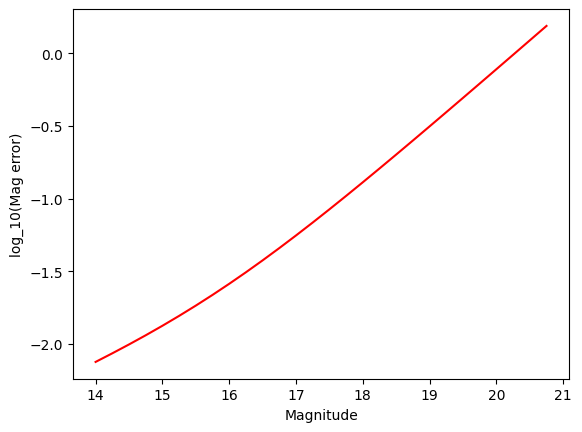

In [178]:
mag = np.arange(14.0, 21.0, 0.25)
mag_err = add_lco_noise(mag)

plt.plot(mag, np.log10(mag_err), 'r-')
plt.xlabel('Magnitude')
plt.ylabel('log_10(Mag error)')

The next step is to simulate what observations LCO could deliver for a given event.  
This naturally includes the visibility of that target from all network sites as a function of 
time, but this is computationally expensive, so we use a pre-calculated table.  This table is created from the notebook visibility_calculations.ipynb in this repository - see that notebook for full details. 

In [179]:
file_path = './lco_1m_network_visibility.hdf5'
visibility_data = visibility_utils.read_visibility_data(file_path)

The function below applies the pre-calculated visibility data to work out which simulated LCO datapoints would be viable observations and returns only those points. 

In [180]:
 def boundaries_check(times, interp_boundaries):
    idx = np.where(times < interp_boundaries[0])
    times[idx] = interp_boundaries[0]
    idx = np.where(times > interp_boundaries[1])
    times[idx] = interp_boundaries[1]
    return times

In [181]:
def observable_dates(input_ts, pixel_vis_func, interp_boundaries):
    """Function to determine whether or not a target is visible from the LCO 1m network 
    at the time stamps given, and return an array of timestamps with datapoints filtered 
    out if the target is not visible.  
    
    Note that this function is intended for multi-day arrays of timestamps, not intra-day.  
    
    While the input array of timestamps to interpolate for should be JD Time objects, 
    note that this is converted within the function into decimalyear, since this seasonal 
    visibility pattern can then be applied to any date.  
    """
        
    # Estimate the hours of visibility per timestamp.  
    ts = np.array([Time(t, format='jd') for t in input_ts])
    ts2 = np.array([(t.decimalyear-int(t.decimalyear)) for t in ts])
    ts2 = boundaries_check(ts2, interp_boundaries)
    hrs_visible = pixel_vis_func(ts2)
    
    # Filter out timestamps where the target isn't visible at all
    idx = np.where(hrs_visible > 0.0)
    
    return input_ts[idx]

The next function takes the simulated ZTF events, and generates a realistic set of LCO observations for that event, if it would be selected for observation using the Key Project strategy. 

In [182]:
def simulate_lco_observations(ztf_event, ztf_model, ztf_model_params, visibility_data, 
                              parallax=True):
    """Function to simulate LCO's observations of a given event.
    
    Observing strategy simulated:
    * Observe events only when brighter than 17.5mag
    * Cadence depends on event timescale:
    - tE <= 90d: cadence = once a day while  1.0tE <= |t-t0| <= 0.2tE, hourly 0.2tE <= |t-t0|
    - tE > 90d: cadence = once every two days
    * Declinations <= +10deg, simulate continuous cadence from 3 sites (24/7), modulo 10% random datapoints removed for weather
    * Declinations > +10deg, simulate continuous cadence from 1 site (8hrs out of 24), modulo weather
    """
    
    # First check whether the event ever gets bright enough for LCO 1-m observations. 
    # If observations are not viable, no additional lightcurve is added to the event
    ztf_lc = ztf_lens.telescopes[0].lightcurve_magnitude
    if len(ztf_lc) == 0:
        return ztf_event
    
    mag_threshold = 17.5
    bright_data = np.where(ztf_lc[:,1] <= mag_threshold)[0]
    if len(bright_data) == 0:
        print('Faint event, min '+str(ztf_lc[:,1].min())+' no LCO observations')
        return ztf_event
    
    # Unpack the lens model parameters:
    if parallax:
        [to, uo, te, rho, piEN, piEE] = ztf_model_params
        print('Event model parameters: ', to, uo, te, rho, piEN, piEE)
    else:
        [to, uo, te, rho] = ztf_model_params
    
    # Determine how many hours per day LCO can observe the target.  We use NSIDE=32 here, 
    # since this is the resolution of the pre-calculated visibility data, but note that 
    # the data is extracted using the Python array index ipix rather than the HP index.
    # This returns the HEALpixel's visibility as a function of date, which is used to create
    # an interpolation function.
    s = SkyCoord(ztf_event.ra, ztf_event.dec, frame='icrs', unit=(u.deg, u.deg))
    hpindex = healpixel_functions.skycoord_to_HPindex(s, 32, radius=2.0)
    ipix = hpindex[0]
    
    pixel_visibility = visibility_data['total_hrs_visible'][ipix,:]
    
    interp_boundaries = (visibility_data['decimalyear'].min(), visibility_data['decimalyear'].max())
    pixel_vis_func = interpolate.interp1d(visibility_data['decimalyear'], pixel_visibility)
    
    # Determine timestamps of LCO observations, with a cadence which depends on the event tE
    start_jd = ztf_lc[:,0].min()
    end_jd = ztf_lc[:,0].max()
    
    # Long timescale events
    if te > 90.0:
        cadence = 2.0
        ts = np.arange(start_jd, end_jd, cadence)
    
    # Short timescale events
    else:
        # Peak observations are defined as those between +/- 0.2tE of t0
        deltat = (ztf_lc[:,0] - to)/te
        
        # Pre-peak observations:
        # Figure out the timestamps when the event is in the pre-peak phase, taking LCO 
        # network visibility into account
        idx1 = np.where(deltat <= -0.2)[0]
        idx2 = np.where(deltat > -1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            pre_peak_start = ztf_lc[idx,0].min()
            pre_peak_end = ztf_lc[idx,0].max()
            cadence = 1.0 # days
            ts1 = np.arange(pre_peak_start, pre_peak_end, cadence)
            ts1 = observable_dates(ts1, pixel_vis_func, interp_boundaries)
        else:
            ts1 = np.array([])
            pre_peak_start = ztf_lc[:,0].min()
            pre_peak_end = ztf_lc[:,0].min()
            
        # Post-peak observations:
        idx1 = np.where(deltat >= 0.2)[0]
        idx2 = np.where(deltat < 1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            post_peak_start = ztf_lc[idx,0].min()
            post_peak_end = ztf_lc[idx,0].max()
            cadence = 1.0 # days
            ts3 = np.arange(post_peak_start, post_peak_end, cadence)
            ts3 = observable_dates(ts3, pixel_vis_func, interp_boundaries)
        else:
            ts3 = np.array([])
            post_peak_start = ztf_lc[:,0].max()
            post_peak_end = ztf_lc[:,0].max()
            
        # Peak observations
        cadence = 1.0/24.0
        ts2 = []
        day = pre_peak_end
        while (day < post_peak_start):
            # Estimate the number of hours that LCO can observe this target for
            t = Time(day, format='jd')
            t = t.decimalyear-int(t.decimalyear)
            t = boundaries_check(np.array([t]), interp_boundaries)[0]
            hours_per_night = pixel_vis_func(t)
            
            if hours_per_night > 0.0:
                # Simulate the timestamps of observations for one 24hr period, taking into account the numbers of 
                # hours that LCO can observe this target for:
                t = np.arange(day, day+(hours_per_night/24.0), cadence)
                ts2 += t.tolist()
                
            day += 1.0 # Increment the day number
        ts2 = np.array(ts2)
        
        ts = np.concatenate((ts1,ts2,ts3))
    
    # Randomly remove a certain fraction of points to simulate data losses due to weather:
    bad_weather_fraction = 0.1
    weathered_idx = np.random.randint(0, high=len(ts), size=int(len(ts)*bad_weather_fraction))
    ts = np.delete(ts, weathered_idx)
    
    # Its possible by now that we have no viable LCO observations.  If so, return the event without an 
    # LCO lightcurve attached
    if len(ts) == 0:
        print('No viable times for LCO observations')
        return ztf_event
    
    # Simulate the LCO photometry for these timestamps, assuming the same baseline magnitude as for ZTF
    lc = np.zeros((len(ts),3))
    lc[:,0] = ts
    lc[:,1] = [np.median(ztf_lc[:,1])] * len(ts)
    lc[:,2] = [0.01] * len(ts)
    tel = telescopes.Telescope(name='LCO', camera_filter='r',
                                     light_curve_magnitude=lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)
    ztf_event.telescopes.append(tel)
    
    if parallax:
        ztf_model.event.compute_parallax_all_telescopes(ztf_model.parallax_model)
        
    tel = ztf_model.event.telescopes[-1]
    
    # Use the PyLIMA model to add a lensing event into the lightcurve
    pylima_parameters = ztf_model.compute_pyLIMA_parameters(ztf_model_params)
    magnification = ztf_model.model_magnification(tel, pylima_parameters)
    A = ztf_model.model_magnification(tel,pylima_parameters)
    lc[:,1] = lc[:,1] + -2.5*np.log10(A)
    
    # Remove any LCO observations for datapoints below the brightness threshold
    idx = np.where(lc[:,1] > mag_threshold)
    lc = np.delete(lc, idx, axis=0)
    
    # Predict the photometric scatter for each datapoint, based on its magnitude
    phot_scatter = add_lco_noise(lc[:,1])
    lc[:,1] += phot_scatter * np.random.randn(len(lc))
        
    # Calculate the photometric uncertainties
    lc[:,2] = add_lco_noise(lc[:,1])
    
    # Store the resulting lightcurve
    tel.lightcurve_magnitude = lc
    ztf_event.telescopes[1] = tel
    
    return ztf_event


As a test example, we apply the LCO data simulator to one of the simulated events.  This returns an updated version of the simulated event object, with the LCO lightcurve appended to the associated list of datasets. 

In [183]:
ztf_lens = sim_ztf_lenses[event_number]
ztf_lens_model = sim_ztf_lens_models[event_number]
lens_model_pars = sim_model_params[event_number]

updated_ztf_event = simulate_lco_observations(ztf_lens, ztf_lens_model, lens_model_pars, visibility_data)

Event model parameters:  2460643.663053141 -0.0491053053809197 128.95956985808448 0.013899165053976384 0.2161940104053539 0.013712628248460215
Parallax(Full) estimated for the telescope LCO: SUCCESS


  EventID    HP                               location                              baseline_mag         t0                 u0                 te                 rho                 piEN                piEE         nvisits nvisits_g nvisits_r nvisits_i
----------- ---- ------------------------------------------------------------------ ------------ ----------------- ------------------- ------------------ -------------------- ------------------ -------------------- ------- --------- --------- ---------
ZTFSim00007 8279 <SkyCoord (ICRS): (ra, dec) in deg\n    (303.046875, 41.81031389)>       13.215 2460643.663053141 -0.0491053053809197 128.95956985808448 0.013899165053976384 0.2161940104053539 0.013712628248460215    1888       482       665       116


Text(0.5, 1.0, 'Simulated event ZTFSim00007')

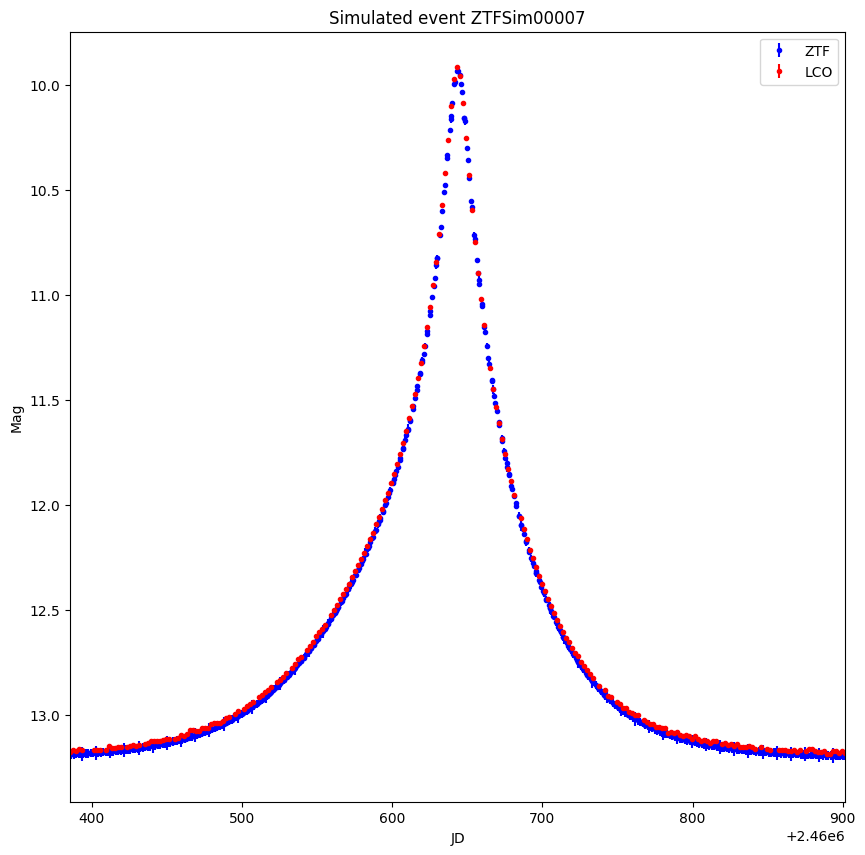

In [184]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc1 = updated_ztf_event.telescopes[0].lightcurve_magnitude
plt.errorbar(lc1[:,0], lc1[:,1], yerr=lc1[:,2], label='ZTF', fmt='b.')
lc2 = updated_ztf_event.telescopes[1].lightcurve_magnitude
plt.errorbar(lc2[:,0], lc2[:,1], yerr=lc2[:,2], label='LCO', fmt='r.')
[xmin, xmax, ymin, ymax] = plt.axis()
xmin = lens_model_pars[0] - 2.0*lens_model_pars[2]
xmax = lens_model_pars[0] + 2.0*lens_model_pars[2]
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.legend()
plt.title('Simulated event '+events_table[event_number]['EventID'])

We can now simulate LCO observations for the full set of simulated ZTF events

In [185]:
simulated_events_list = []

for ievent in range(0,len(events_table),1):
    updated_ztf_event = simulate_lco_observations(sim_ztf_lenses[ievent], 
                                                   sim_ztf_lens_models[ievent], 
                                                   sim_model_params[ievent], 
                                                   visibility_data)
    simulated_events_list.append(updated_ztf_event)

Event model parameters:  2460852.804932032 -0.04362528802792487 30.73562907010169 0.006461730522983497 -0.6019977131533791 0.22107949113646858
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460186.9910481106 -0.04384046345148229 67.98983048232418 0.008356276844566047 0.805462657807752 0.2873231461637078
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460539.235038167 0.03157626760794652 19.419931160111908 0.011357011207274142 -0.03534340341202449 0.1564595019468876
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460498.9730158546 0.45690083257699854 56.8735422806095 0.02439147438349773 1.2989541864483325 -0.26660727972125403
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460609.6118143955 0.355535098846073 39.26779396669031 0.0077274474835158065 -0.377721816634451 -0.06324711347722956
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event mode

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460242.6144550415 0.6030400996951801 21.366950651517442 0.0012197690853555368 1.0335541645163302 0.21711984437385948
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460512.4163682265 0.29052584858026953 18.24337406072415 0.013849336424048118 1.136167441260331 0.11846790233217169
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461236.4149362496 0.5364420914280075 2.0133916978347477 0.005711569869515749 0.1353488651990999 0.19972086954738663
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460797.2908497807 0.037870096290789995 9.53896434830124 0.02935378562204473 -0.4266471512659636 0.10250404019025444
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460393.633761881 0.08403969202778108 37.78387897454288 0.01628499369532828 -0.02026986477182971 0.1522313999152679
Parallax(Fu

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460158.026927854 0.24379830012118414 215.6635768027232 0.014937263680019403 -0.02540134108400874 -0.11172281849200502
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460868.167469224 0.37659677988264195 39.50262268137709 0.02692123465358407 -0.585250848343446 -0.07621800581927726
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460328.2116069477 -0.016278491740857687 63.29151644469481 0.004698001126117306 -0.9252640825960017 -0.07874473950830949
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460692.8394145407 0.14920099597207684 22.97558838165083 0.01846674836051146 0.5917725729907728 0.29095675145160965
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460486.3742677723 0.08084696454765662 4.676672439712111 0.024563734555717233 0.34051320761481446 -0.18907586230634693
Para

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461063.217994177 0.2738130954229325 147.0675779978315 0.012315981561359072 0.5366366021751688 -0.007291995401796959
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460541.4903521417 -0.09577516625077143 88.76698367124175 0.013973576008445638 0.2633937467750373 -0.37230749593188583
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460323.7810526546 0.07769112250966738 20.72925235491884 0.00010239490914353 0.6166959472482861 -0.33940900039594407
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460452.980789584 0.28953095329309364 28.591062558593304 0.0027178129936461515 0.5427434757096145 0.08281298465944581
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460408.588117535 0.21327437590241394 16.808038493881703 0.003883424949699547 0.2625897219342656 0.20504949835576186
Paralla

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461014.0514640384 0.2679571254627481 29.724968576522013 0.009362152997986156 0.7331395652186423 0.00428141283696197
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461019.296093944 -0.2735131608150849 57.422829537097556 0.009835233827911637 1.5243894843898196 0.17420329156699416
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460163.114996082 -0.05984698451553025 2.93833597705576 0.014617319291760234 0.514975053585677 0.351997452735075
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461014.226429113 0.6473083607419013 28.796740653468646 0.003986286207640617 0.514608734502662 -0.15214870671465588
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460780.6663171407 0.291520091931271 35.02851855016566 0.03930445779438793 -0.4072732264801638 -0.25419838779569354
Parallax(Full) e

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460747.5841885745 0.5217711589330766 53.169464449338356 0.02553865015609827 1.0080962280307055 0.07215273877882497
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460622.987270003 0.25056547709295596 15.268951172393809 0.009308792047547613 -0.8102950843563681 0.11570986389905152
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460961.847659427 0.2980330471009206 17.66355064354345 0.00776814072538113 0.705660933241983 -0.14355240036226638
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460700.85390292 0.11310973682194286 19.015985044386632 0.008710578380117929 0.4240628975561365 0.05422754705201889
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460206.1234107437 -0.33848406851890345 9.688385403083162 0.0010570913679937653 1.666787250332705 0.09770321471169022
Parallax(Full

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460482.9583227327 -0.03120545226767102 72.21545799428493 2.7026215615974167e-05 -0.8554869540996868 0.24567191146074277
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460742.3048792426 -0.23820593618244065 16.07425737998471 0.010921242072990504 -0.17140712277197245 0.02485241636146809
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460893.112338384 0.2681215795178359 37.82281650953939 0.017974362814254307 0.6090881764563334 -0.24616778703927847
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460753.1559019256 0.05468245423654611 63.52945054128029 0.014090275993449213 0.5026667278927905 0.24741936511923768
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460390.7782678 0.14636281575142354 58.94854165903652 0.014385933140803773 0.13575755110418036 0.01450501384854826
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461094.628739148 0.30009755849421843 36.208455186882404 0.014900786113622057 1.0804824541103288 -0.6947877694288778
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460322.7001752285 0.5038957135847303 15.103268148522673 0.007840376770237583 -0.14453274228883872 -0.15440988867900526
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460450.057267638 0.11083758075350356 39.08903078066539 0.0014983770394636862 0.4574394828143582 -0.22164806908868454
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461237.185805832 -0.5584952107604935 52.50147131065921 0.008984166581510666 -0.0728468098710987 -0.2470537307582358
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461231.5383713543 0.42854965964059577 39.79369933513773 0.0007231975044775067 0.8329612119951142 -0.22264749581335738
Para

Event model parameters:  2460380.173135961 -0.3947204490464101 10.297567352454372 0.01610730438949236 0.2608050075165901 -0.1587182203984766
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460577.03891172 0.6882784641599086 15.13690486612443 0.025966867719698687 0.6008316687840121 0.11056647019086654
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461244.1709218416 0.06073610432808679 20.910356004871616 0.005878082519734169 1.7862227890147477 0.249831888187928
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460734.3081357717 0.19385448551518009 9.089193571662488 0.014757165733653073 -1.3562277679722103 0.06420699985303069
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461208.878636837 -0.028114433848067444 26.63740683428817 0.029478316695979084 -0.13558366223461393 -0.13231006030747391
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event mode

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460451.3971826113 0.7309265278748612 81.9478803486567 0.016831745155045527 -0.01015171129421552 0.040303920510144545
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460314.991325041 0.13231129714283887 112.81733827031297 0.03982881562713818 0.014319201061915393 -0.011586206756906685
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460320.380385736 0.3757108244824427 13.595392755797985 0.004742111730058299 -0.10062732183746614 0.2022456497584536
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460180.1171658644 0.3147142048398823 27.513780194297254 0.015008925096273306 0.24479324292038446 -0.0466001427036189
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460462.4979857276 0.022786864318449895 93.06473014254307 0.0005813309679951386 0.388611019423446 -0.5489627642077306
Para

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460721.0896466663 0.401236268589504 35.8126034510862 0.028570740947602376 -0.10893038079930428 0.036132643645603355
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461175.063301626 0.31286530427713694 22.795884200655426 0.005869577304139015 1.0830805213213277 0.20709306561348975
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460436.9163810546 -0.26422833396231804 164.11135067157667 0.027417493218797363 0.9567199850240282 0.1817528461827971
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460514.870719293 -0.6059086275454881 14.409451416998326 0.021252664882111676 -0.6231455594817004 0.17892980695110008
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460685.206054836 -0.07299678455828276 5.295522245942499 0.0016876199338564934 0.5989907529116144 -0.1309253424755131
Paralla

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460192.7169801607 0.2952566864906243 18.975228522613953 0.007683804477906125 0.06830554432804624 -0.09084315162562304
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460545.8510641297 -0.14571388154214668 7.81811388604924 0.0027264922655001207 -0.12790494332568786 -0.01724307773046535
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461155.470266865 0.20697871922053987 22.249524920929744 0.016438709765778638 1.1574042763259402 0.04594914997448922
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461142.7864755355 0.009953197600311076 12.838093171875606 0.0019228888090124744 0.7762540606277311 -0.06035101916362904
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460287.6383447647 0.06414312804309101 60.3580468778886 0.017570497334075216 0.9422548755597313 -0.48242012802197803


Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461243.8812604886 -0.5059758666282714 32.9833719037463 0.003969352832546047 0.4885344318351511 -0.01214708868113508
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460727.4467497747 0.4526254374342573 24.97050790386056 0.0010153766492298419 -0.9429918697226682 0.10528645719504887
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460223.522273558 -0.09017259567106609 119.60173381168846 0.0006751278420208534 0.2533685994467796 0.06408466247374915
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460377.403109445 0.17081602542665145 28.035656836159802 0.004212637711177099 0.9099922868379617 -0.08663090025392142
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460531.9882315085 -0.3287309735274181 41.83604480722492 0.01979791761601333 0.5002696959460915 -0.12807263078237807
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460731.2768802033 0.053180590519014984 14.941211533091538 0.01080049899393785 -0.9634083078121392 0.06504953483111776
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461007.107928097 0.2534622840613974 77.04488197093892 0.00828336894167358 -0.4935560270419585 0.10702130931805302
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460441.9167737127 0.5631225692426655 11.969943239446536 0.011990437555980836 0.861533279519864 -0.018728930626904165
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460336.875290978 -0.4340154745281819 72.27414131643545 0.0006560402327323578 0.11716288137264788 0.4016547991558539
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460334.9606007948 0.23874564251974786 20.44050651388349 0.0006036238434855047 0.19123008773914157 -0.286727029509907
Parallax

Event model parameters:  2460591.054307033 0.423202511584708 18.322222875615612 0.008244070084754977 -0.08051334113943343 -0.11416567355895207
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460262.419952151 0.27878204014775954 56.80553426598068 0.01703356013631975 0.422203167941226 0.1597362322648307
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460910.279050389 0.07338573678573608 51.74380039976573 0.04098717452948622 -0.6103809316770794 -0.13352554409892048
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460537.6430054624 -0.3969214870379537 23.96288716254174 0.02520544829840682 -0.17360960351937338 0.2753381422137909
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461119.2131740097 -0.2812870656449684 28.777265511217976 0.009758710683210737 -0.809781251484468 0.501646318303708
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model pa

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460544.267595427 -0.20600289660029789 97.51205434278363 0.0033314386417669407 -0.4382045324646517 -0.3275453622665287
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460408.1970462855 0.13868049653153428 6.4929623793696685 0.009788240751276744 0.5962585248332717 0.41487422231725424
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460438.3815724053 0.030556314175681346 45.81444033053228 0.004402067678450309 -1.0291760053222936 0.20377763087095563
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461082.98253161 -0.4889944821641723 36.901497533452506 0.017577993661458985 -0.858892486276851 -0.45382711443867235
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460786.636351655 -0.10487145876026083 73.77814923214937 0.008485983477270314 1.301579574650312 -0.043859796756484194
Para

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461234.4355842825 -0.21573242134981366 121.57834195323846 0.03018813020091638 0.5537338373221565 -0.2646493808956054
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461252.1934670866 -0.5314949307623427 47.19105310108427 0.001886418823792443 -0.24242326747001414 0.38850361013413454
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460413.781588428 0.34503763409621635 10.019766041233757 0.02194908238981597 1.419280464689767 0.21762832381472735
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460727.747618333 -0.3273250623252376 57.52781209856685 0.011561005095537391 -1.1831420845965364 0.14529249992891985
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460297.994451437 0.2776349304078177 35.378640157570096 0.0024260297259239456 0.5309595692520752 -0.06340930938919692
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460908.4889077744 0.42007922067963943 26.19082998380906 0.0017995893841750961 0.46452718191890113 0.2560312523235188
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460238.839883431 0.011984645274735223 80.15413710791461 0.0031948831846184645 0.9669695977739516 0.6794204955626486
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460455.666347301 0.4000190815518665 24.258885582720403 0.0013571733601157078 -0.5816358718842352 0.04968321759690723
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461056.820169786 0.24261249508549054 88.2688957992365 0.0026654960753788003 -0.8624476397870873 0.14389192503860934
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460904.9205070203 0.1628840757826943 19.36899623458871 0.020635397163233985 0.5009245522303869 -0.2538700036904714
Parallax(

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460869.7806076813 0.6198831662255992 38.82938760396856 0.0275869542417206 -0.23760644874571485 0.6823889381254759
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460160.000667785 0.02082490869383377 76.18532116066325 0.003626474405939044 -0.04174600943637202 -0.4916289631960183
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460649.846129782 -0.0019261960107570253 43.59182949187299 0.021056443230870598 -0.89199543114369 0.22014033822218904
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460172.9092387715 -0.47815856326665584 47.92671008876659 0.013210263811126183 1.2862023236976357 -0.08510784655492351
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461034.4793316857 0.21623630248877734 38.74624794133679 0.0006176458506287359 0.2099328725817931 -0.35952467968987534
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460497.7981152367 0.29556601520459813 24.239373935252306 0.012012684984034589 -0.8529305688825286 0.31400935899656934
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460196.8661517017 0.6820710120628012 23.477256519010332 0.0021746892606542903 -0.07988978355811038 0.5720577492940797
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461029.525805549 0.17410792569491423 47.98967570084558 0.024564768830879657 0.7137515144537112 0.12567473869971285
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460655.539011126 0.5724421991607234 51.16485595290688 0.029846087733724075 -0.8995662344762223 0.08815463897961114
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460894.988568381 0.10477180094791266 20.186232215974112 0.01456119948186314 0.9763359511100371 -0.0880191678032276
Parallax(

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460875.571856243 -0.25347763562942427 39.41601097834528 0.005303350926309252 1.3400985734834259 0.24888039477314136
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460712.162991977 -0.43980281278517286 19.17050044974803 0.0006723680818004106 0.27464727259186816 0.40241560873111804
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460401.2700260724 -0.050981993501119566 15.958486882363559 8.673678076838269e-05 -0.5861758346650718 0.3194220672691243
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460667.6087101144 0.3282626084808849 37.901349433376865 0.0014360906372640463 0.6060496396155364 -0.19850305174398236
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460808.0228573093 0.5182107335011699 42.73337622457086 0.016850301171031604 -1.082893824247382 0.24286968642043222
Par

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461093.5936514414 0.04027756496487961 187.1202512783267 0.0008015737363415683 0.3088500225312709 0.39982738740936097
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460434.7148039946 -0.17283924700449646 11.758373178810288 0.004104957159939118 -0.502191439156169 0.12623185573134982
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461172.2171188896 0.4304333507266913 6.430825888434965 0.009100276770144253 0.06137155019385346 -0.13574103235020432
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461224.0737337996 0.0929615834355785 12.694370892002818 0.0031215309041978025 -0.5712816360497299 0.15299134321085886
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460920.6552450415 0.26802761476902004 24.633467832558267 0.010957781619957668 0.41901467962476086 0.12963572790581
Paral

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461040.621225988 0.026301090722787926 75.9610574615949 0.016134662548176665 0.2882035949901434 0.15236317648653303
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460899.5925146793 0.15449508253152536 17.50305276830573 0.02327107937835854 1.2483991251915965 0.02484326355989761
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460566.884368918 0.419819047860434 18.493554071730976 0.012954059402305013 -0.5109221303908436 0.2643230689994666
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460603.0924241254 0.053631354794297675 10.408963175968083 0.0010172992055062953 1.2644289026179396 0.27913803965022976
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461193.6887526987 0.08956305078248092 114.6817655417601 0.003471825461425368 0.42916385723194833 -0.2781787068207768
Parallax(F

In [186]:
file_path = 'simulated_lco_lightcurves_ztf_events.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(simulated_events_list),1):
        if len(simulated_events_list[ievent].telescopes) == 2:
            lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        else:
            lc = np.array([])
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

## Evalulating how well we can characterize events

A key test of the observing strategy is how well we can constraint the event parameters as a result of the lightcurves produced.  

In order to evaluate this, we fit a microlensing model to the two lightcurves for each simulated event, as we would with real data, and then evaluate the fitted parameters of that model in comparison with the input simulated event parameters, as well as evaluating the uncertainties on the parameters key to measuring the mass of the events. 

In [187]:
class FitParams():
    """Object containing the fitted parameters and errors of a model fitted
    to a microlensing lightcurve"""
    
    def __init__(self):
        
        self.to = None
        self.toerr = None
        self.delta_to = None
        self.prop_delta_to = None
        self.to_within_range = None
        self.uo = None
        self.uoerr = None
        self.delta_uo = None
        self.prop_delta_uo = None
        self.uo_within_range = None
        self.tE= None
        self.tEerr = None
        self.delta_tE = None
        self.prop_delta_tE = None
        self.tE_within_range = None
        self.rho = None
        self.rhoerr = None
        self.piEN = None
        self.piENerr = None
        self.delta_piEN = None
        self.prop_delta_piEN = None
        self.piEN_within_range = None
        self.piEE= None
        self.piEEerr = None
        self.delta_piEE = None
        self.prop_delta_piEE = None
        self.piEE_within_range = None
        self.s = None
        self.serr = None
        self.q = None
        self.qerr = None
        self.logs = None
        self.logserr = None
        self.logq = None
        self.logqerr = None
        self.alpha = None
        self.alphaerr = None
        self.chichi = None
        self.bic = None
        self.nparam = 0
        self.type = None
        self.teerr_ok = None
        self.piEN_constrained = None
        self.piEE_constrained = None
    
    def extract_parameters_from_fit(self, fit, tel_list):
        fit_params = microloutputs.parameters_result(fit)
        fit_errors = microloutputs.fit_errors(fit)
    
        self.to = fit_params.to
        self.toerr = fit_errors.err_to
        self.tE = fit_params.tE
        self.tEerr = fit_errors.err_tE
        self.rho = fit_params.rho
        self.rhoerr = fit_errors.err_rho
        self.uo = fit_params.uo
        self.uoerr = fit_errors.err_uo
        self.piEN = fit_params.piEN
        self.piENerr = fit_errors.err_piEN
        self.piEE= fit_params.piEE
        self.piEEerr = fit_errors.err_piEE
        
        for tel in tel_list:
            fs = getattr(fit_params, 'fs_'+tel)
            fserr = getattr(fit_errors, 'err_fs_'+tel)
            setattr(self,'fs_'+tel, fs)
            setattr(self,'fs_'+tel+'_err', fserr)
            fb = getattr(fit_params, 'fb_'+tel)
            fberr = getattr(fit_errors, 'err_fb_'+tel)
            setattr(self,'fb_'+tel, fb)
            setattr(self,'fb_'+tel+'_err', fberr)
        
        self.chichi = fit_params.chichi

    def compare_parameters(self, event_params, params={'to':'t0','tE':'te','uo':'u0','piEN':'piEN','piEE':'piEE'}):
        
        result = ''
        
        for par_fit,par_expect in params.items():
            fitted_value = getattr(self,par_fit)
            fitted_error = getattr(self,par_fit+'err')
            fitted_range = [fitted_value - fitted_error, fitted_value + fitted_error]
            expected_value = event_params[par_expect]
            
            result += par_expect+': Fitted value='+str(fitted_value)+'+/-'+str(fitted_error)\
                    +' expected value='+str(expected_value)+'\n'
            
            delta = abs(expected_value - fitted_value)
            prop_delta = (delta/expected_value)*100.0
            if expected_value >= fitted_range[0] and expected_value <= fitted_range[1]:
                within_range = True
            else:
                within_range = False
        
            result += par_expect+': delta='+str(delta)\
                        +' prop_delta='+str(prop_delta)\
                        +'% within_range? '+repr(within_range)+'\n'
        
            setattr(self, 'delta_'+par_fit, delta)
            setattr(self, 'prop_delta_'+par_fit, prop_delta)
            setattr(self, par_fit+'_within_range', within_range)
            
        # Require that the tE be well constrained, meaning that the uncertainty is less than 25% of the value
        if (self.tEerr/event_params['te'])<0.25:
            teerr_ok = True
        else:
            teerr_ok = False
        result += 'tE constrained='+repr(teerr_ok)
        self.teerr_ok = teerr_ok
        
        # Require that the fitted uncertainties on the parallax parameters are smaller
        # than the measured values, i.e. are constrained
        piE_ok = []
        for par in ['piEE', 'piEN']:
            fitted_value = getattr(self,par)
            fitted_error = getattr(self,par+'err')
            
            if (np.abs(fitted_value) - 2.0*fitted_error > 0):
                piE_ok.append(True)
            else:
                piE_ok.append(False)
            result += ' '+par+' constrained='+repr(piE_ok[-1])
            
            setattr(self, par+'_constrained', piE_ok[-1])
            
        print(result)
        
    def summary(self, tel_list):
        
        line = 'tE = '+str(self.tE)+'+/-'+str(self.tEerr)+'\n'+\
                'to = '+str(self.to)+'+/-'+str(self.toerr)+'\n'+\
                'uo = '+str(self.uo)+'+/-'+str(self.uoerr)+'\n'+\
                'rho = '+str(self.rho)+'+/-'+str(self.rhoerr)+'\n'+\
                'piEN = '+str(self.piEN)+'+/-'+str(self.piENerr)+'\n'+\
                'piEE = '+str(self.piEE)+'+/-'+str(self.piEEerr)+'\n'
        
        for tel in tel_list:
            fs = getattr(self,'fs_'+tel)
            fserr = getattr(self,'fs_'+tel+'_err')
            fb = getattr(self,'fb_'+tel)
            fberr = getattr(self,'fb_'+tel+'_err')
            
            line += 'fs_'+tel+' = '+str(fs)+'+/-'+str(fserr)+'\n'
            line += 'fb_'+tel+' = '+str(fb)+'+/-'+str(fberr)+'\n'
        
        line += 'chi^2 = '+str(self.chichi)
        
        return line


In [188]:
def fit_event_model(event_params, model_type, ztf_lc, lco_lc):
    
    e = event.Event()
    e.name = event_params['EventID']
    e.ra = float(event_params['location'].ra.deg)
    e.dec = float(event_params['location'].dec.deg)

    # Add a PyLIMA telescope object to the event with the ZTF lightcurve
    tel1 = telescopes.Telescope(name='ZTF', camera_filter='r',
                                     light_curve_magnitude=ztf_lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    e.telescopes.append(tel1)
    
    
    # Add a PyLIMA telescope object to the event with the LCO lightcurve
    tel2 = telescopes.Telescope(name='LCO', camera_filter='r',
                                     light_curve_magnitude=lco_lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    e.telescopes.append(tel2)
    
    # Identify which dataset to use as the baseline:
    e.find_survey('ZTF')
    e.check_event()

    fit_method = 'LM'
    fit_method = 'DE'

    # Create a model object with parallax
    model = microlmodels.create_model(model_type, e, 
                                          parallax=['Full', event_params['t0']], 
                                          blend_flux_ratio=False)
    model.define_model_parameters()
    
    # Give the model initial guess values somewhere near their actual values so that the fit doesn't take all day
    lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]
        
    model.parameters_guess = lensing_parameters 
    for idx in range(6):    
        model.parameters_boundaries[idx]= [lensing_parameters[idx]-3e-4,
                                             lensing_parameters[idx]+3e-4]
    model.event.compute_parallax_all_telescopes(model.parallax_model)
    
    # Fit the model to the data:
    e.fit(model,fit_method)
    fit_flag = e.fits[-1].check_fit()
    print('Fit flag: '+repr(fit_flag))
    print('Telescopes: '+str(len(e.telescopes)))
    print('Fit results: '+repr(e.fits[-1].fit_results))
    
    # Compare the fitted model with the input event parameters
    tel_list = ['ZTF', 'LCO']
    fit = FitParams()
    fit.extract_parameters_from_fit(e.fits[-1], tel_list)
   
    fit.compare_parameters(event_params)
    
    return fit, e


Using our example simulated event, we fit an event model and demonstrate the comparision between the input and fitted parameters

In [189]:
ztf_lc = updated_ztf_event.telescopes[0].lightcurve_magnitude
lco_lc = updated_ztf_event.telescopes[1].lightcurve_magnitude
model_type = 'FSPL'

print(events_table[event_number])
(fit_params, e) = fit_event_model(events_table[event_number], model_type, ztf_lc, lco_lc)

  EventID    HP                               location                              baseline_mag         t0                 u0                 te                 rho                 piEN                piEE         nvisits nvisits_g nvisits_r nvisits_i
----------- ---- ------------------------------------------------------------------ ------------ ----------------- ------------------- ------------------ -------------------- ------------------ -------------------- ------- --------- --------- ---------
ZTFSim00007 8279 <SkyCoord (ICRS): (ra, dec) in deg\n    (303.046875, 41.81031389)>       13.215 2460643.663053141 -0.0491053053809197 128.95956985808448 0.013899165053976384 0.2161940104053539 0.013712628248460215    1888       482       665       116
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00007, with model FSPL and method DE
check_eve

Now we can model all of the events in the simulation, storing the model fitted parameters and the comparison information

In [190]:
modeling_results = []
model_type = 'FSPL'

for ievent in range(0,len(events_table),1):
    print('\nModeling event '+str(ievent)+' number of lightcurves '+str(len(simulated_events_list[ievent].telescopes)))
    if len(simulated_events_list[ievent].telescopes) == 2:
        ztf_lc = simulated_events_list[ievent].telescopes[0].lightcurve_magnitude
        lco_lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude

        (fit_params, e) = fit_event_model(events_table[ievent], model_type, ztf_lc, lco_lc)
    else:
        fit_params = FitParams()
        print('No LCO lightcurve so not fitted')
        
    modeling_results.append(fit_params)
    


Modeling event 0 number of lightcurves 2
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00001, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 313.776
differential_evolution step 2: f(x)= 313.769
differential_evolution step 3: f(x)= 313.597
differential_evolution step 4: f(x)= 313.589
differential_evolution step 5: f(x)= 313.589
differential_evolution step 6: f(x)= 313.589
differential_evolution step 7: f(x)= 313.589
differential_evolution step 8: f(x)= 313.589
differential_evolution step 9: f(x)= 313.589
differential_evolution step 10: f(x)= 313.589
differential_evolution step 11: f(x)= 313.589
differential_evolution step 12: f(x)= 313.589
differential_evolution step 13: f(x)= 313.589
DE converge to objective function : f(x) =  313.5549719079325
DE converge 

differential_evolution step 1: f(x)= 601.442
DE converge to objective function : f(x) =  601.3517481332254
DE converge to parameters : =  ['2460498.9727158546' '0.45720083257699856' '56.873242280609496'
 '0.024091474383497728' '1.2986541864483325' '-0.266307279721254']
trust_region_reflective  : TRF fit SUCCESS
[2460498.972715865, 0.45720083257699345, 56.873242280609546, 0.024091474383516633, 1.2986541864483334, -0.2663072797212544, 298.07436543686737, -0.22531526522369563, 480604.6141656677, -588.2112471841144, 601.3517490501924]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460498.972715865, 0.45720083257699345, 56.873242280609546, 0.024091474383516633, 1.2986541864483334, -0.2663072797212544, 298.07436543686737, -0.22531526522369563, 480604.6141656677, -588.2112471841144, 601.3517490501924]
t0: Fitted value=2460498.972715865+/-0.009911282091454574 expected value=2460498.9730158546
t0: delta=0.0002999897114932537 prop_d

differential_evolution step 1: f(x)= 194.827
DE converge to objective function : f(x) =  194.7994634978642
DE converge to parameters : =  ['2460496.5863613593' '0.26912576645172814' '10.431652878720566'
 '0.024985517770928348' '-0.47696343543580155' '-0.06638212802147986']
trust_region_reflective  : TRF fit SUCCESS
[2460496.586363446, 0.2691290975829442, 10.431478546217573, 0.02498551777095026, -0.4768952906523631, -0.06638212802221508, 118.6689117034562, -0.09243035318035595, 480745.0978752033, -1611.188276077058, 194.80062820074173]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460496.586363446, 0.2691290975829442, 10.431478546217573, 0.02498551777095026, -0.4768952906523631, -0.06638212802221508, 118.6689117034562, -0.09243035318035595, 480745.0978752033, -1611.188276077058, 194.80062820074173]
t0: Fitted value=2460496.586363446+/-0.0009702103908962964 expected value=2460496.5866613593
t0: delta=0.0002979133278131485 p

DE converge to objective function : f(x) =  117.51528430920999
DE converge to parameters : =  ['2461101.041473633' '0.12412943593205929' '13.93859695327807'
 '0.005122897157612901' '0.5417027713928848' '0.20458001199391218']
trust_region_reflective  : TRF fit SUCCESS
[2461101.0414736336, 0.1241247091977475, 13.938598590321234, 0.004640334955291769, 0.5417027713928847, 0.2045800119939125, 118.61363097203943, -0.03703989331317942, 480066.86511200154, 249.01424557613436, 117.50747197807667]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461101.0414736336, 0.1241247091977475, 13.938598590321234, 0.004640334955291769, 0.5417027713928847, 0.2045800119939125, 118.61363097203943, -0.03703989331317942, 480066.86511200154, 249.01424557613436, 117.50747197807667]
t0: Fitted value=2461101.0414736336+/-0.00039480906906087766 expected value=2461101.041773633
t0: delta=0.00029999949038028717 prop_delta=1.2189645418381018e-08% within_rang

differential_evolution step 1: f(x)= 217.952
differential_evolution step 2: f(x)= 217.952
differential_evolution step 3: f(x)= 217.952
differential_evolution step 4: f(x)= 217.952
differential_evolution step 5: f(x)= 217.952
differential_evolution step 6: f(x)= 217.952
differential_evolution step 7: f(x)= 217.952
differential_evolution step 8: f(x)= 217.952
differential_evolution step 9: f(x)= 217.952
differential_evolution step 10: f(x)= 217.952
differential_evolution step 11: f(x)= 217.932
differential_evolution step 12: f(x)= 217.932
DE converge to objective function : f(x) =  217.90287876947522
DE converge to parameters : =  ['2460519.518963557' '0.034219279985267845' '20.21576781861815'
 '0.014008711753185483' '1.0751332800286446' '-0.21536233684917727']
trust_region_reflective  : TRF fit SUCCESS
[2460519.5189626883, 0.03423059445838942, 20.21624066927704, 0.014121430918141414, 1.0753207640759939, -0.2151574939707205, 748.1211690303203, 0.04895995794844096, 479911.9026745014, 830.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00019, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 110.943
DE converge to objective function : f(x) =  110.93885325685086
DE converge to parameters : =  ['2460428.0670668203' '0.4200550841124964' '5.646617436449227'
 '0.01618019569434636' '0.9771209797276261' '0.5215454475072668']
trust_region_reflective  : TRF fit SUCCESS
[2460428.0669904654, 0.42005508419426113, 5.646620906097493, 0.016181595368130568, 0.9771209796277295, 0.5215454474077821, 297.661767997673, 0.19028338946528356, 478386.7598962214, 2939.9266010225742, 110.95017888309886]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460428.0669904654, 0.42005508419426113, 5.646620906097493, 0.016181595368130568, 0.9771209796277295, 0.5215454474077821, 297.

differential_evolution step 1: f(x)= 337.061
differential_evolution step 2: f(x)= 336.6
differential_evolution step 3: f(x)= 336.6
differential_evolution step 4: f(x)= 336.6
differential_evolution step 5: f(x)= 336.6
differential_evolution step 6: f(x)= 336.6
differential_evolution step 7: f(x)= 336.6
differential_evolution step 8: f(x)= 336.6
differential_evolution step 9: f(x)= 336.6
differential_evolution step 10: f(x)= 336.6
differential_evolution step 11: f(x)= 336.6
DE converge to objective function : f(x) =  336.5917554427172
DE converge to parameters : =  ['2460286.5302259857' '0.049899401750212735' '74.71777469410726'
 '0.0005907225424644466' '1.0099981424060698' '-0.07341047015582507']
trust_region_reflective  : TRF fit SUCCESS
[2460286.530419245, 0.049899401750212735, 74.71777469410726, 0.0005907225424644466, 1.0099981424060698, -0.07341047015582507, 748.0516245889886, 0.11834727838977546, 479941.1706702262, 417.77328397615025, 336.63380635235563]
differential_evolution  : D

differential_evolution step 1: f(x)= 173.459
differential_evolution step 2: f(x)= 173.459
differential_evolution step 3: f(x)= 173.459
differential_evolution step 4: f(x)= 173.374
differential_evolution step 5: f(x)= 173.374
DE converge to objective function : f(x) =  173.16700017734908
DE converge to parameters : =  ['2461147.0756949494' '-0.10666615169916811' '14.575348452078122'
 '0.023523569202355814' '0.39638665952988145' '-0.1936826922156574']
trust_region_reflective  : TRF fit SUCCESS
[2461147.07569495, -0.10668824845040589, 14.575348452078108, 0.02391113340146089, 0.3963866595298818, -0.19368269221565731, 118.54600415125694, 0.0311130985416038, 479886.4009727622, 235.853918382501, 173.16520500487331]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461147.07569495, -0.10668824845040589, 14.575348452078108, 0.02391113340146089, 0.3963866595298818, -0.19368269221565731, 118.54600415125694, 0.0311130985416038, 479886.40

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00032, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 523.619
differential_evolution step 2: f(x)= 523.619
differential_evolution step 3: f(x)= 523.615
DE converge to objective function : f(x) =  523.5428155179276
DE converge to parameters : =  ['2460519.25969943' '0.1837434676994331' '48.747144014654474'
 '0.0134421265855582' '0.22454941268535908' '0.30722750898866236']
trust_region_reflective  : TRF fit SUCCESS
[2460519.2596994294, 0.18374521514287204, 48.74711754627772, 0.013481814676184974, 0.2245494126853591, 0.3072275089886623, 297.78177001228227, 0.07242012362925632, 479728.8809961083, 895.7860542688885, 523.5427908478057]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460519.2596994294, 0.183745215142872

DE converge to objective function : f(x) =  23.391318458620972
DE converge to parameters : =  ['2461068.5731674153' '0.7122905749117008' '7.113196727339829'
 '0.001527290764492005' '0.21488879900678645' '0.14117722640396008']
trust_region_reflective  : TRF fit SUCCESS
[2461068.573164536, 0.712290574826955, 7.113196726641858, 0.001527290764492005, 0.2148887989068919, 0.14117722630435373, 118.64178934226811, -0.06502203368067332, 475608.6757474296, 7230.200028346238, 23.391647287304046]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461068.573164536, 0.712290574826955, 7.113196726641858, 0.001527290764492005, 0.2148887989068919, 0.14117722630435373, 118.64178934226811, -0.06502203368067332, 475608.6757474296, 7230.200028346238, 23.391647287304046]
t0: Fitted value=2461068.573164536+/-0.011686892505577185 expected value=2461068.5728674154
t0: delta=0.0002971207723021507 

differential_evolution step 1: f(x)= 156.384
DE converge to objective function : f(x) =  156.38288232378875
DE converge to parameters : =  ['2460874.550171124' '0.5659008037588871' '15.353725732653453'
 '0.01866498337196819' '0.44046894329617303' '-0.010277565358626778']
trust_region_reflective  : TRF fit SUCCESS
[2460874.5501711243, 0.5658992678033193, 15.353725732653455, 0.018570062352369462, 0.4404689432961731, -0.01027756535862678, 748.2422037398428, -0.07271753567921979, 478886.2862048386, 2680.079906010638, 156.38287192168403]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460874.5501711243, 0.5658992678033193, 15.353725732653455, 0.018570062352369462, 0.4404689432961731, -0.01027756535862678, 748.2422037398428, -0.07271753567921979, 478886.2862048386, 2680.079906010638, 156.38287192168403]
t0: Fitted value=2460874.5501711243+/-0.005229044006230405 expected value=2460874.550471124
t0: delta=0.00029999949038028717 pro

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00043, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 449.82
DE converge to objective function : f(x) =  449.7726378520868
DE converge to parameters : =  ['2460254.901617049' '0.25041158232212773' '173.2675086681984'
 '0.00606421294370671' '0.921070408703457' '0.010201777464862253']
trust_region_reflective  : TRF fit SUCCESS
[2460254.9015918584, 0.2504140729767605, 173.26741018110218, 0.006582241109516104, 0.9210667724984601, 0.010201777464820391, 118.59615765254848, -0.01918270462728001, 479826.4061239368, 264.5042339419888, 449.77128469377783]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460254.9015918584, 0.2504140729767605, 173.26741018110218, 0.006582241109516104, 0.9210667724984601, 0.010201777464820391, 118.59615765254848, -0.01918270462728001, 479826.406123

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00047, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 16348.3
DE converge to objective function : f(x) =  16348.257296331878
DE converge to parameters : =  ['2461236.4146362497' '0.5367420914280074' '2.013691697834748'
 '0.006011569869515749' '0.13564886519909988' '0.19942086954738664']
trust_region_reflective  : TRF fit SUCCESS
[2461236.414673724, 0.5367420913521178, 2.013691697657742, 0.006011569769580502, 0.13564884551294606, 0.19942086964738467, 118.63834465308722, -0.06152741433875025, 481101.15048460546, -1058.3375925924558, 16348.300325027416]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461236.414673724, 0.5367420913521178, 2.013691697657742, 0.006011569769580502, 0.13564884551294606, 0.199420869647384

differential_evolution step 1: f(x)= 238.978
differential_evolution step 2: f(x)= 238.978
differential_evolution step 3: f(x)= 238.849
differential_evolution step 4: f(x)= 238.849
differential_evolution step 5: f(x)= 238.841
differential_evolution step 6: f(x)= 238.841
differential_evolution step 7: f(x)= 238.841
differential_evolution step 8: f(x)= 238.841
differential_evolution step 9: f(x)= 238.841
differential_evolution step 10: f(x)= 238.831
differential_evolution step 11: f(x)= 238.831
DE converge to objective function : f(x) =  238.78019430235338
DE converge to parameters : =  ['2460249.898423953' '-0.05335408933291532' '30.230788722962927'
 '0.020703046338380656' '0.7131683695273281' '-0.02150230910414712']
trust_region_reflective  : TRF fit SUCCESS
[2460249.8984242375, -0.053354082909086345, 30.230788722962682, 0.020703027949731216, 0.7131683695273268, -0.021502289222102212, 118.57394366416227, 0.0029792063401451875, 479960.35226022097, -166.2123762294383, 238.78019622525187]


Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00055, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 482.194
DE converge to objective function : f(x) =  482.18535910567374
DE converge to parameters : =  ['2460158.840849073' '0.5576023843742663' '129.57314456339276'
 '0.029618085231787515' '0.961099907685536' '0.32820747655252885']
trust_region_reflective  : TRF fit SUCCESS
[2460158.8408474205, 0.5576023843759013, 129.5731445633948, 0.02961808523028386, 0.9610999076854247, 0.32820747655239096, 297.6461114184527, 0.20730564585828073, 480712.4679423776, -522.56315355975, 482.18536121805823]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460158.8408474205, 0.5576023843759013, 129.5731445633948, 0.02961808523028386, 0.9610999076854247, 0.32820747655239096, 297.64

differential_evolution step 1: f(x)= 322.927
DE converge to objective function : f(x) =  322.86694792403154
DE converge to parameters : =  ['2460951.796014863' '0.2016060356637498' '37.853523216612366'
 '0.028135887302080408' '0.19357937343813522' '0.020018563476871774']
trust_region_reflective  : TRF fit SUCCESS
[2460951.7960201856, 0.2016131257582924, 37.853523216617965, 0.028332215268114223, 0.19357937343814235, 0.020018563476871785, 118.53069397501218, 0.04700616058483524, 479656.1681426966, 473.8037660893945, 322.86708527323]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460951.7960201856, 0.2016131257582924, 37.853523216617965, 0.028332215268114223, 0.19357937343814235, 0.020018563476871785, 118.53069397501218, 0.04700616058483524, 479656.1681426966, 473.8037660893945, 322.86708527323]
t0: Fitted value=2460951.7960201856+/-0.0014335875233646104 expected value=2460951.796215851
t0: delta=0.00019566528499126434 prop_d

differential_evolution step 1: f(x)= 241.825
differential_evolution step 2: f(x)= 239.47
differential_evolution step 3: f(x)= 232.436
differential_evolution step 4: f(x)= 232.436
differential_evolution step 5: f(x)= 232.428
differential_evolution step 6: f(x)= 232.428
differential_evolution step 7: f(x)= 232.428
differential_evolution step 8: f(x)= 232.428
differential_evolution step 9: f(x)= 232.428
differential_evolution step 10: f(x)= 232.428
differential_evolution step 11: f(x)= 232.426
differential_evolution step 12: f(x)= 232.291
differential_evolution step 13: f(x)= 232.048
differential_evolution step 14: f(x)= 232.048
differential_evolution step 15: f(x)= 232.048
differential_evolution step 16: f(x)= 232.048
differential_evolution step 17: f(x)= 232.048
differential_evolution step 18: f(x)= 232.048
differential_evolution step 19: f(x)= 232.048
differential_evolution step 20: f(x)= 232.048
differential_evolution step 21: f(x)= 232.048
differential_evolution step 22: f(x)= 232.03

differential_evolution step 2: f(x)= 200.626
differential_evolution step 3: f(x)= 200.626
differential_evolution step 4: f(x)= 200.626
differential_evolution step 5: f(x)= 198.341
differential_evolution step 6: f(x)= 198.341
differential_evolution step 7: f(x)= 197.62
differential_evolution step 8: f(x)= 197.572
differential_evolution step 9: f(x)= 195.822
differential_evolution step 10: f(x)= 195.822
differential_evolution step 11: f(x)= 194.864
differential_evolution step 12: f(x)= 194.794
differential_evolution step 13: f(x)= 194.683
differential_evolution step 14: f(x)= 194.683
differential_evolution step 15: f(x)= 194.683
differential_evolution step 16: f(x)= 194.683
differential_evolution step 17: f(x)= 194.683
differential_evolution step 18: f(x)= 194.683
differential_evolution step 19: f(x)= 194.683
differential_evolution step 20: f(x)= 194.683
differential_evolution step 21: f(x)= 194.683
differential_evolution step 22: f(x)= 194.683
differential_evolution step 23: f(x)= 194.6

differential_evolution step 1: f(x)= 224.432
DE converge to objective function : f(x) =  224.423037710659
DE converge to parameters : =  ['2460721.844422091' '0.8072127198592394' '61.26747540312708'
 '0.013817173178577313' '0.4997311454366053' '-0.22950740820852705']
trust_region_reflective  : TRF fit SUCCESS
[2460721.8444220885, 0.8072127198592396, 61.26747540312716, 0.013817173178577594, 0.49973114543661723, -0.22950740820852703, 118.52364128178722, 0.05501415487464149, 478237.0840457398, 2642.5800767638366, 224.42303773625258]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460721.8444220885, 0.8072127198592396, 61.26747540312716, 0.013817173178577594, 0.49973114543661723, -0.22950740820852703, 118.52364128178722, 0.05501415487464149, 478237.0840457398, 2642.5800767638366, 224.42303773625258]
t0: Fitted value=2460721.8444220885+/-0.059171348234901416 expected value=2460721.844122091
t0: delta=0.00029999762773513794 prop_

differential_evolution step 7: f(x)= 190.022
differential_evolution step 8: f(x)= 190.022
differential_evolution step 9: f(x)= 190.022
differential_evolution step 10: f(x)= 190.022
differential_evolution step 11: f(x)= 190.022
DE converge to objective function : f(x) =  189.93266923943378
DE converge to parameters : =  ['2460281.6933332607' '0.042974309414273576' '44.817577976305735'
 '0.0010624332527202135' '-0.9149535907060384' '-0.20113223983034703']
trust_region_reflective  : TRF fit SUCCESS
[2460281.6933332607, 0.042974309414273576, 44.817577976305735, 0.0010624332527202135, -0.9149535906060384, -0.20113223983034703, 118.57213762840952, 0.004044522367550182, 480039.53192211344, 142.3387876734871, 189.9326692604623]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460281.6933332607, 0.042974309414273576, 44.817577976305735, 0.0010624332527202135, -0.9149535906060384, -0.20113223983034703, 118.57213762840952, 0.0040445223

differential_evolution step 1: f(x)= 20.8473
DE converge to objective function : f(x) =  20.833785697914433
DE converge to parameters : =  ['2460284.424542544' '-0.5771258102662072' '19.60650961513259'
 '0.029637068502795183' '-0.13208639998370816' '-0.09448705204404068']
trust_region_reflective  : TRF fit SUCCESS
[2460284.4245426925, -0.5771258102662007, 19.60650961513113, 0.029637068502795478, -0.13208639998379088, -0.09448705204402126, 118.65209832696209, -0.07557567953843762, 479606.2739261306, 995.3191280415853, 20.83379400302263]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460284.4245426925, -0.5771258102662007, 19.60650961513113, 0.029637068502795478, -0.13208639998379088, -0.09448705204402126, 118.65209832696209, -0.07557567953843762, 479606.2739261306, 995.3191280415853, 20.83379400302263]
t0: Fitted value=2460284.4245426925+/-0.011854474472645262 expected value=2460284.424842544
t0: delta=0.0002998514100909233

differential_evolution step 1: f(x)= 42.052
DE converge to objective function : f(x) =  42.04307313576882
DE converge to parameters : =  ['2461127.314208185' '0.39245630292236294' '9.572001382055493'
 '0.023649979202714645' '0.813153019537443' '0.0351430173099001']
trust_region_reflective  : TRF fit SUCCESS
[2461127.3141972125, 0.3924563028737537, 9.572001381118934, 0.023649979302333986, 0.8131530194382589, 0.03514301721074977, 118.66419307238995, -0.08762681376253408, 481128.75936998776, -1684.315954564969, 42.0453520195301]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461127.3141972125, 0.3924563028737537, 9.572001381118934, 0.023649979302333986, 0.8131530194382589, 0.03514301721074977, 118.66419307238995, -0.08762681376253408, 481128.75936998776, -1684.315954564969, 42.0453520195301]
t0: Fitted value=2461127.3141972125+/-0.002204284684416809 expected value=2461127.313908185
t0: delta=0.0002890275791287422 prop_delta=1

differential_evolution step 33: f(x)= 136.272
differential_evolution step 34: f(x)= 136.272
differential_evolution step 35: f(x)= 136.272
differential_evolution step 36: f(x)= 136.272
differential_evolution step 37: f(x)= 136.272
differential_evolution step 38: f(x)= 136.272
differential_evolution step 39: f(x)= 136.272
DE converge to objective function : f(x) =  136.15418188836455
DE converge to parameters : =  ['2460625.0243034125' '-0.0025527151544322904' '19.03421548914645'
 '0.010280247006734541' '1.2580017128241254' '0.14377895208675526']
trust_region_reflective  : TRF fit SUCCESS
[2460625.0243033473, -0.002552665707963449, 19.03431468009792, 0.010280200614451908, 1.2580017128241239, 0.14377895208675515, 118.60541624493229, -0.029118460252807513, 480140.0968894122, -599.7223829779357, 136.15381522883402]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460625.0243033473, -0.002552665707963449, 19.03431468009792, 0.0102

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00088, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 130.833
DE converge to objective function : f(x) =  130.8040762840456
DE converge to parameters : =  ['2461060.6687334953' '0.21925514719098757' '69.10806682128072'
 '0.027514609232663946' '0.3567339014582671' '-0.10477390413296564']
trust_region_reflective  : TRF fit SUCCESS
[2461060.668733361, 0.21925640966025098, 69.1077211493439, 0.02751460923249941, 0.3567339014582809, -0.1047739041333384, 118.63037262113606, -0.056653189566012174, 480518.12486903847, -685.1653303216278, 130.8040696101621]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461060.668733361, 0.21925640966025098, 69.1077211493439, 0.02751460923249941, 0.3567339014582809, -0.1047739041333384, 1

differential_evolution step 1: f(x)= 97.7273
DE converge to objective function : f(x) =  97.6674634598826
DE converge to parameters : =  ['2460868.167769224' '0.37629677988264193' '39.50232268137709'
 '0.027221234653584073' '-0.585550848343446' '-0.07591800581927727']
trust_region_reflective  : TRF fit SUCCESS
[2460868.1677680705, 0.37629677988264215, 39.502322681377095, 0.027221234653583826, -0.5855508483434458, -0.07591800581927889, 297.62163634233787, 0.23294535691546694, 479762.75718062534, 552.8634049034467, 97.66747549665055]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460868.1677680705, 0.37629677988264215, 39.502322681377095, 0.027221234653583826, -0.5855508483434458, -0.07591800581927889, 297.62163634233787, 0.23294535691546694, 479762.75718062534, 552.8634049034467, 97.66747549665055]
t0: Fitted value=2460868.1677680705+/-0.006890882953669731 expected value=2460868.167469224
t0: delta=0.0002988465130329132 pro

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00096, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 488.949
DE converge to objective function : f(x) =  488.9081577359122
DE converge to parameters : =  ['2460984.964568782' '0.23208676148823834' '92.379533188785'
 '0.0033412613698109053' '0.4920281033056161' '0.22509904195398756']
trust_region_reflective  : TRF fit SUCCESS
[2460984.964568773, 0.23208795503035803, 92.37927269051842, 0.0034023259210426517, 0.4920281033056141, 0.22509932698141927, 297.75427667434064, 0.10553894186082723, 480563.92481513764, -566.0309280568413, 488.9078934178876]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460984.964568773, 0.23208795503035803, 92.37927269051842, 0.0034023259210426517, 0.4920281033056141, 0.22509932698141927, 297.75427667434064, 0.10553894186082723, 480563.92481513

differential_evolution step 1: f(x)= 484.731
DE converge to objective function : f(x) =  484.59174827451073
DE converge to parameters : =  ['2460536.946995715' '0.6057698892180051' '90.01108010885227'
 '0.02532110495404545' '0.6728504447907884' '0.023047827477862843']
trust_region_reflective  : TRF fit SUCCESS
[2460536.946995699, 0.6057698892180109, 90.01108010885281, 0.02532110495403985, 0.6728504447907824, 0.023047827477860255, 297.6654288478361, 0.19094499373801901, 480080.7758987988, -195.17465382047578, 484.59174867265216]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460536.946995699, 0.6057698892180109, 90.01108010885281, 0.02532110495403985, 0.6728504447907824, 0.023047827477860255, 297.6654288478361, 0.19094499373801901, 480080.7758987988, -195.17465382047578, 484.59174867265216]
t0: Fitted value=2460536.946995699+/-0.1349874132108346 expected value=2460536.946695715
t0: delta=0.0002999836578965187 prop_delta=1.2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00104, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 91.0406
DE converge to objective function : f(x) =  90.93493465061646
DE converge to parameters : =  ['2460537.6967946584' '0.43404512698595993' '9.764343878487862'
 '0.026641323854817718' '0.08448154434766315' '0.03114129502362533']
trust_region_reflective  : TRF fit SUCCESS
[2460537.696794658, 0.4340451269859599, 9.76434387848786, 0.02664132385481772, 0.08448154434766314, 0.03114129502362532, 748.6868243207305, -0.5190912547486703, 481249.4000373469, -1906.538550909202, 90.93493492430937]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460537.696794658, 0.4340451269859599, 9.76434387848786, 0.02664132385481772, 0.08448154434766314, 0.03114129502362532, 748.6

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00108, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 157.227
DE converge to objective function : f(x) =  157.1796745898209
DE converge to parameters : =  ['2460164.9401251418' '0.4837097139626652' '14.61495559815878'
 '0.030849680660533667' '-0.5169747178301558' '-0.04080999435398382']
trust_region_reflective  : TRF fit SUCCESS
[2460164.9401251455, 0.4837097139626642, 14.614955598158774, 0.030849680660534912, -0.516974717830155, -0.0408099943539838, 748.7148072707604, -0.5465156522709508, 479812.88304560375, 850.6981059009188, 157.17967529336786]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460164.9401251455, 0.4837097139626642, 14.614955598158774, 0.030849680660534912, -0.516974717830155, -0.0408099943539838

differential_evolution step 1: f(x)= 141.945
DE converge to objective function : f(x) =  141.94352673151104
DE converge to parameters : =  ['2460592.5729179196' '0.30824126652544653' '12.003513402964616'
 '0.02978265569361195' '0.6244426771405616' '-0.021259232522676474']
trust_region_reflective  : TRF fit SUCCESS
[2460592.5729145403, 0.3082508809956085, 12.0034348167521, 0.030087391026018376, 0.6244426771405356, -0.021259232522680967, 298.07404170881256, -0.22340229151539134, 480986.6758873005, -1783.2275601088465, 141.94353846760205]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460592.5729145403, 0.3082508809956085, 12.0034348167521, 0.030087391026018376, 0.6244426771405356, -0.021259232522680967, 298.07404170881256, -0.22340229151539134, 480986.6758873005, -1783.2275601088465, 141.94353846760205]
t0: Fitted value=2460592.5729145403+/-0.0010868052711650153 expected value=2460592.572771068
t0: delta=0.000143472105264663

differential_evolution step 1: f(x)= 27.0152
DE converge to objective function : f(x) =  26.98776061740905
DE converge to parameters : =  ['2461057.5359820575' '-0.17488979863146265' '6.661824631488925'
 '0.007477298805767549' '0.468866995691625' '-0.33520008321132927']
trust_region_reflective  : TRF fit SUCCESS
[2461057.535982058, -0.17488863954643474, 6.661836739487714, 0.007353307864596865, 0.46886699569162504, -0.33528318630631215, 297.87398225706306, -0.022313075945159182, 480064.3652604048, 447.27065649067066, 26.9878828648445]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461057.535982058, -0.17488863954643474, 6.661836739487714, 0.007353307864596865, 0.46886699569162504, -0.33528318630631215, 297.87398225706306, -0.022313075945159182, 480064.3652604048, 447.27065649067066, 26.9878828648445]
t0: Fitted value=2461057.535982058+/-0.0003117647115313339 expected value=2461057.5362820574
t0: delta=0.00029999949038028717

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00120, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 60.3895
DE converge to objective function : f(x) =  60.24273511110318
DE converge to parameters : =  ['2460335.569194628' '0.2222362387739549' '20.912337053000485'
 '0.008054075361936648' '-0.10585764363793879' '-0.2782687833156149']
trust_region_reflective  : TRF fit SUCCESS
[2460335.5691946275, 0.22223623877395488, 20.91233705300048, 0.008054075361936652, -0.10585764363793877, -0.27826878331561494, 748.8636703043738, -0.7017373458303755, 480923.5710977001, -1284.2569496197805, 60.2427352771696]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460335.5691946275, 0.22223623877395488, 20.91233705300048, 0.008054075361936652, -0.10585764363793877, -0.27826878331561494, 748.8636703043738, -0.7017373458303755, 480923.57

differential_evolution step 1: f(x)= 463.136
differential_evolution step 2: f(x)= 463.136
differential_evolution step 3: f(x)= 463.136
differential_evolution step 4: f(x)= 462.324
differential_evolution step 5: f(x)= 462.324
differential_evolution step 6: f(x)= 461.91
differential_evolution step 7: f(x)= 461.91
differential_evolution step 8: f(x)= 461.91
differential_evolution step 9: f(x)= 461.755
differential_evolution step 10: f(x)= 461.755
differential_evolution step 11: f(x)= 461.621
differential_evolution step 12: f(x)= 461.621
differential_evolution step 13: f(x)= 461.621
differential_evolution step 14: f(x)= 461.621
DE converge to objective function : f(x) =  461.53871442355097
DE converge to parameters : =  ['2460798.2598250727' '0.07474036145045211' '179.94711020019548'
 '0.02038144554407837' '0.9360867358672962' '-0.5441512584597541']
trust_region_reflective  : TRF fit SUCCESS
[2460798.2598246806, 0.07474064248963773, 179.94651377782932, 0.02038144554407784, 0.93608981865944

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00128, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 175.039
DE converge to objective function : f(x) =  174.8727665511841
DE converge to parameters : =  ['2460369.1169761275' '-0.3400762677217641' '25.17347405226324'
 '0.02550142747488971' '0.02450114295016558' '-0.15708351079697613']
trust_region_reflective  : TRF fit SUCCESS
[2460369.1169761242, -0.3400762677217642, 25.173474052263266, 0.02550142747488965, 0.024501142950167608, -0.15708351079697935, 118.48569805903519, 0.09209681606937634, 479908.6354276493, -248.40578738468426, 174.87276880494065]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460369.1169761242, -0.3400762677217642, 25.173474052263266, 0.02550142747488965, 0.024501142950167608, -0.157083510

differential_evolution step 1: f(x)= 100.672
DE converge to objective function : f(x) =  100.65314443446265
DE converge to parameters : =  ['2460784.374371522' '0.5837545479170888' '6.325211313291726'
 '0.010967089255048402' '0.23424458061276568' '0.3234396569026878']
trust_region_reflective  : TRF fit SUCCESS
[2460784.3743715216, 0.5837545479170887, 6.325211313291725, 0.010929311667607473, 0.23424458061276565, 0.3234396569026877, 188051.91138814524, -120.4574087902133, 480306.9619275581, -3.7673243523198785, 100.65315802089755]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460784.3743715216, 0.5837545479170887, 6.325211313291725, 0.010929311667607473, 0.23424458061276565, 0.3234396569026877, 188051.91138814524, -120.4574087902133, 480306.9619275581, -3.7673243523198785, 100.65315802089755]
t0: Fitted value=2460784.3743715216+/-0.0022758406756184808 expected value=2460784.374071522
t0: delta=0.00029999949038028717 prop_de

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00136, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 787.585
differential_evolution step 2: f(x)= 787.455
differential_evolution step 3: f(x)= 787.455
differential_evolution step 4: f(x)= 787.455
differential_evolution step 5: f(x)= 787.451
differential_evolution step 6: f(x)= 787.451
differential_evolution step 7: f(x)= 787.437
differential_evolution step 8: f(x)= 787.403
differential_evolution step 9: f(x)= 787.403
differential_evolution step 10: f(x)= 787.364
DE converge to objective function : f(x) =  787.138653965364
DE converge to parameters : =  ['2460541.4906521416' '-0.09577304584797844' '88.76707320069718'
 '0.013905874293219964' '0.26340551640279664' '-0.37260749593188586']
trust_region_reflective  : TRF fit SUCCESS
[2460541.490637812, -0.0957866174305662, 88.767

differential_evolution step 1: f(x)= 153.883
differential_evolution step 2: f(x)= 153.883
differential_evolution step 3: f(x)= 153.883
differential_evolution step 4: f(x)= 153.883
differential_evolution step 5: f(x)= 153.883
differential_evolution step 6: f(x)= 153.861
differential_evolution step 7: f(x)= 153.861
DE converge to objective function : f(x) =  153.80164267272636
DE converge to parameters : =  ['2460338.3888404067' '-0.11377421658986989' '41.63706620631037'
 '0.007860738626874664' '-0.7606288491643829' '0.48315922784049514']
trust_region_reflective  : TRF fit SUCCESS
[2460338.389009185, -0.11378099373358468, 41.63706620331625, 0.008230241476352896, -0.7606288490932005, 0.4831592279117507, 297.9985524548588, -0.1530679447954867, 480136.0510331167, 480.4842700423291, 153.8028953295689]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460338.389009185, -0.11378099373358468, 41.63706620331625, 0.008230241476352896, -

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00144, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 332.465
differential_evolution step 2: f(x)= 332.465
differential_evolution step 3: f(x)= 332.465
differential_evolution step 4: f(x)= 332.465
differential_evolution step 5: f(x)= 332.465
differential_evolution step 6: f(x)= 332.401
differential_evolution step 7: f(x)= 332.401
differential_evolution step 8: f(x)= 332.309
differential_evolution step 9: f(x)= 332.309
differential_evolution step 10: f(x)= 332.309
differential_evolution step 11: f(x)= 332.309
DE converge to objective function : f(x) =  332.03903977691107
DE converge to parameters : =  ['2461208.7519712113' '0.06782778130412186' '42.334029400433'
 '0.011933228741747662' '0.14168243693707552' '0.14420902021825327']
trust_region_reflective  : TRF fit SUCCESS
[24

differential_evolution step 1: f(x)= 172.524
DE converge to objective function : f(x) =  172.45819367672001
DE converge to parameters : =  ['2460983.0372625715' '-0.19110073527217655' '26.782677866303118'
 '0.009318184111232041' '0.11388133704251473' '0.4202134584156092']
trust_region_reflective  : TRF fit SUCCESS
[2460983.037262578, -0.1911012967603408, 26.7825937950975, 0.009322156848309624, 0.11388409537540471, 0.42021352608445417, 118.57887209182017, -0.0019180417878401454, 479679.1357011671, 545.1303190275905, 172.4581412326666]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460983.037262578, -0.1911012967603408, 26.7825937950975, 0.009322156848309624, 0.11388409537540471, 0.42021352608445417, 118.57887209182017, -0.0019180417878401454, 479679.1357011671, 545.1303190275905, 172.4581412326666]
t0: Fitted value=2460983.037262578+/-0.0011861065275224885 expected value=2460983.0375625715
t0: delta=0.00029999343678355217 p

differential_evolution step 1: f(x)= 147.385
differential_evolution step 2: f(x)= 147.385
DE converge to objective function : f(x) =  147.37442863274592
DE converge to parameters : =  ['2460586.2051448612' '0.15958741776342555' '16.890959233864102'
 '0.004031598018265281' '-0.20151373502947242' '-0.14718136121318']
trust_region_reflective  : TRF fit SUCCESS
[2460586.205134568, 0.15958767585761882, 16.890959233865214, 0.004061565114014087, -0.2015137350400031, -0.14718136120880923, 187898.19866672388, 33.897654959209284, 479594.3473927459, 1880.6635029540967, 147.37446623441537]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460586.205134568, 0.15958767585761882, 16.890959233865214, 0.004061565114014087, -0.2015137350400031, -0.14718136120880923, 187898.19866672388, 33.897654959209284, 479594.3473927459, 1880.6635029540967, 147.37446623441537]
t0: Fitted value=2460586.205134568+/-0.0009613539170056835 expected value=2460586

differential_evolution step 1: f(x)= 560.685
DE converge to objective function : f(x) =  560.5621847113242
DE converge to parameters : =  ['2460502.943743624' '0.27515108763703694' '66.2778063472554'
 '0.003801901391082592' '0.8549855046398895' '0.3488940467145939']
trust_region_reflective  : TRF fit SUCCESS
[2460502.9437436243, 0.27515095220304725, 66.27786875321407, 0.0038862195568914303, 0.8549855046398894, 0.34889404671459434, 118.56718288006206, 0.00775538503870919, 480471.7166091458, -1118.421123681925, 560.5580898112752]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460502.9437436243, 0.27515095220304725, 66.27786875321407, 0.0038862195568914303, 0.8549855046398894, 0.34889404671459434, 118.56718288006206, 0.00775538503870919, 480471.7166091458, -1118.421123681925, 560.5580898112752]
t0: Fitted value=2460502.9437436243+/-0.004640279091815723 expected value=2460502.9440436237
t0: delta=0.00029999949038028717 prop_de

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00160, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 423.029
differential_evolution step 2: f(x)= 423.029
differential_evolution step 3: f(x)= 422.97
DE converge to objective function : f(x) =  422.8142301776181
DE converge to parameters : =  ['2460971.695253928' '-0.16121992300468382' '54.605856797840566'
 '0.011908318413362208' '-0.9540086085532303' '-0.06621451502935816']
trust_region_reflective  : TRF fit SUCCESS
[2460971.6952539277, -0.16121427366444702, 54.605353979307004, 0.011536374450858457, -0.9540160916984785, -0.06621670642929162, 118.55336357758979, 0.0223156367431693, 480024.9351705521, -82.5172582141258, 422.8129699679663]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460971.6952539277, -0.16121

differential_evolution step 1: f(x)= 145.648
differential_evolution step 2: f(x)= 145.547
differential_evolution step 3: f(x)= 145.547
differential_evolution step 4: f(x)= 145.547
differential_evolution step 5: f(x)= 145.547
differential_evolution step 6: f(x)= 145.547
differential_evolution step 7: f(x)= 145.547
differential_evolution step 8: f(x)= 145.547
differential_evolution step 9: f(x)= 145.523
differential_evolution step 10: f(x)= 145.523
differential_evolution step 11: f(x)= 145.523
differential_evolution step 12: f(x)= 145.523
differential_evolution step 13: f(x)= 145.424
differential_evolution step 14: f(x)= 145.424
differential_evolution step 15: f(x)= 145.424
differential_evolution step 16: f(x)= 145.362
differential_evolution step 17: f(x)= 145.362
DE converge to objective function : f(x) =  145.3422260636971
DE converge to parameters : =  ['2461018.024571956' '-0.01830965994990788' '44.88677678802035'
 '0.0073379087587698765' '0.21848765629562222' '-0.3509528179200428']


differential_evolution step 1: f(x)= 1345.97
differential_evolution step 2: f(x)= 1097.76
differential_evolution step 3: f(x)= 540.86
differential_evolution step 4: f(x)= 540.86
differential_evolution step 5: f(x)= 540.86
differential_evolution step 6: f(x)= 524.257
differential_evolution step 7: f(x)= 524.257
differential_evolution step 8: f(x)= 524.257
differential_evolution step 9: f(x)= 523.42
differential_evolution step 10: f(x)= 523.42
differential_evolution step 11: f(x)= 523.42
differential_evolution step 12: f(x)= 521.431
differential_evolution step 13: f(x)= 521.431
differential_evolution step 14: f(x)= 521.142
differential_evolution step 15: f(x)= 521.142
differential_evolution step 16: f(x)= 521.142
differential_evolution step 17: f(x)= 521.142
differential_evolution step 18: f(x)= 521.142
differential_evolution step 19: f(x)= 521.142
differential_evolution step 20: f(x)= 521.142
differential_evolution step 21: f(x)= 521.142
differential_evolution step 22: f(x)= 521.142
dif

differential_evolution step 1: f(x)= 166.583
DE converge to objective function : f(x) =  166.5655241594158
DE converge to parameters : =  ['2460275.4216750325' '-0.3912307633801682' '34.279982995747744'
 '0.013482704023036278' '-1.1501640100574577' '0.23729270786286605']
trust_region_reflective  : TRF fit SUCCESS
[2460275.4216750227, -0.3912307633870996, 34.27998299585189, 0.01348270401150156, -1.1501640100586603, 0.23729270786286474, 118.48560544559277, 0.09234373137580208, 479850.44227547693, -518.2657073910426, 166.56552668496477]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460275.4216750227, -0.3912307633870996, 34.27998299585189, 0.01348270401150156, -1.1501640100586603, 0.23729270786286474, 118.48560544559277, 0.09234373137580208, 479850.44227547693, -518.2657073910426, 166.56552668496477]
t0: Fitted value=2460275.4216750227+/-0.006171272332397606 expected value=2460275.4213750325
t0: delta=0.000299990177154541 pr

differential_evolution step 1: f(x)= 294.553
DE converge to objective function : f(x) =  294.54827981475927
DE converge to parameters : =  ['2460899.6759739425' '0.2607662786801568' '23.905502053870574'
 '0.017238940179660073' '0.07572539151864587' '0.12506070851115567']
trust_region_reflective  : TRF fit SUCCESS
[2460899.6759739644, 0.26076338154335293, 23.905937739338718, 0.017276541098827095, 0.0759475018634355, 0.12469725030461307, 297.8366169875572, 0.01508653785000368, 479753.3836793886, 965.9961520823707, 294.54725046461823]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460899.6759739644, 0.26076338154335293, 23.905937739338718, 0.017276541098827095, 0.0759475018634355, 0.12469725030461307, 297.8366169875572, 0.01508653785000368, 479753.3836793886, 965.9961520823707, 294.54725046461823]
t0: Fitted value=2460899.6759739644+/-0.0018309482696649163 expected value=2460899.6762739425
t0: delta=0.000299978069961071 prop_

differential_evolution step 1: f(x)= 418.471
DE converge to objective function : f(x) =  418.45857420987704
DE converge to parameters : =  ['2460942.89976504' '0.31296645398132217' '34.6265719286128'
 '0.000923316341043206' '-0.5134345210093485' '0.14508522174935293']
trust_region_reflective  : TRF fit SUCCESS
[2460942.899519328, 0.31296672271837916, 34.62657192515018, 0.000923316341043206, -0.5134345211093367, 0.1450852216498853, 297.82708418452216, 0.025014324774711553, 480064.47257261217, -134.7883948899843, 418.4811952536304]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460942.899519328, 0.31296672271837916, 34.62657192515018, 0.000923316341043206, -0.5134345211093367, 0.1450852216498853, 297.82708418452216, 0.025014324774711553, 480064.47257261217, -134.7883948899843, 418.4811952536304]
t0: Fitted value=2460942.899519328+/-0.003124040777501132 expected value=24

differential_evolution step 1: f(x)= 46.364
differential_evolution step 2: f(x)= 46.3403
differential_evolution step 3: f(x)= 46.2737
differential_evolution step 4: f(x)= 46.2259
differential_evolution step 5: f(x)= 46.2259
differential_evolution step 6: f(x)= 46.2259
differential_evolution step 7: f(x)= 46.2259
DE converge to objective function : f(x) =  46.2078812507976
DE converge to parameters : =  ['2460163.114887606' '-0.06001710781298083' '2.9386359770557604'
 '0.014917319291760234' '0.5149995208214132' '0.35183431850211005']
trust_region_reflective  : TRF fit SUCCESS
[2460163.114887536, -0.060017098972920464, 2.938635977020586, 0.014917319291760229, 0.5146750536802073, 0.3516974527352762, 118.56904174438883, 0.007810125146865907, 480770.65338881686, -1867.0493404191388, 46.20764671838525]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460163.114887536, -0.060017098972920464, 2.938635977020586, 0.014917319291760229,

differential_evolution step 1: f(x)= 925.247
DE converge to objective function : f(x) =  925.2222739882407
DE converge to parameters : =  ['2460503.627827837' '0.600943397756283' '85.8840666168582'
 '0.002525449423817836' '-0.8452262187203947' '0.08784290035836104']
trust_region_reflective  : TRF fit SUCCESS
[2460503.627597492, 0.6009433977549088, 85.88406660832977, 0.002525449423817836, -0.8452262186290252, 0.08784290035856454, 118.63956740857815, -0.06430735373653561, 481292.76513797254, -2127.055333404732, 925.2260178846182]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460503.627597492, 0.6009433977549088, 85.88406660832977, 0.002525449423817836, -0.8452262186290252, 0.08784290035856454, 118.63956740857815, -0.06430735373653561, 481292.76513797254, -2127.055333404732, 925.2260178846182]
t0: Fitted value=2460503.627597492+/-0.03379842977006943 expected value=24605

differential_evolution step 1: f(x)= 157.746
DE converge to objective function : f(x) =  157.72859127288785
DE converge to parameters : =  ['2460357.09936695' '0.2627743039465112' '18.932775704772876'
 '0.0035816269590859453' '-0.07545719982684373' '0.13166250514518127']
trust_region_reflective  : TRF fit SUCCESS
[2460357.0993663594, 0.26277430394653245, 18.932775704773235, 0.0035710930620811675, -0.0754571998268224, 0.1316625051451797, 118.48113093186534, 0.09658244391944139, 479447.7316299555, 426.0384928573538, 157.72139023886126]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460357.0993663594, 0.26277430394653245, 18.932775704773235, 0.0035710930620811675, -0.0754571998268224, 0.1316625051451797, 118.48113093186534, 0.09658244391944139, 479447.7316299555, 426.0384928573538, 157.72139023886126]
t0: Fitted value=2460357.0993663594+/-0.0020165682802990074 expected value=2460357.0993469553
t0: delta=1.9404105842113495e-05

differential_evolution step 1: f(x)= 291.696
DE converge to objective function : f(x) =  291.6924152979732
DE converge to parameters : =  ['2460731.4580881945' '0.2727860638921064' '45.136721863531484'
 '0.011553310446708048' '0.7499046564474017' '0.14545962297739343']
trust_region_reflective  : TRF fit SUCCESS
[2460731.458128937, 0.2727848118308519, 45.13655619598804, 0.011345550884366961, 0.749904656447477, 0.14545962297734014, 747.6303701971639, 0.555145944286042, 479674.34726911876, 95.94405574675832, 291.692520250128]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460731.458128937, 0.2727848118308519, 45.13655619598804, 0.011345550884366961, 0.749904656447477, 0.14545962297734014, 747.6303701971639, 0.555145944286042, 479674.34726911876, 95.94405574675832, 291.692520250128]
t0: Fitted value=2460731.458128937+/-0.0036435214952620213 expected value=2460731.4583474454
t0: delta=0.0002185082994401455 prop_delta=8.87981086

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00199, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 89.8294
DE converge to objective function : f(x) =  89.76516790865207
DE converge to parameters : =  ['2460567.485702799' '0.4385615687616768' '8.43742518682221'
 '0.01218576716226567' '-0.8892867865162437' '0.2946993519989857']
trust_region_reflective  : TRF fit SUCCESS
[2460567.4857027987, 0.43856156876167685, 8.437425186822212, 0.012185767162265668, -0.8892867865162438, 0.29469935199898584, 747.6617944548142, 0.50923733590852, 478809.7658942141, 1842.03297268709, 89.7651681391888]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460567.4857027987, 0.43856156876167685, 8.437425186822212, 0.012185767162265668, -0.8892867865162438, 0.29469935199898584, 747.6617

differential_evolution step 1: f(x)= 75.3281
differential_evolution step 2: f(x)= 75.325
differential_evolution step 3: f(x)= 75.325
differential_evolution step 4: f(x)= 75.325
differential_evolution step 5: f(x)= 75.325
differential_evolution step 6: f(x)= 75.325
differential_evolution step 7: f(x)= 75.325
DE converge to objective function : f(x) =  75.28091612404837
DE converge to parameters : =  ['2461105.4721657797' '-0.09434597719447234' '22.428647951188804'
 '0.009524202983588682' '-0.5772656620902419' '-0.6172618332489846']
trust_region_reflective  : TRF fit SUCCESS
[2461105.472165779, -0.094359628017597, 22.4283791012678, 0.010009039876093154, -0.5772656620902418, -0.6172618332489848, 118.53744255422211, 0.04011458024637684, 479727.73679640744, 325.086783031303, 75.28037679531855]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461105.472165779, -0.094359628017597, 22.4283791012678, 0.010009039876093154, -0.57726566

differential_evolution step 1: f(x)= 196.187
DE converge to objective function : f(x) =  196.14123808141144
DE converge to parameters : =  ['2460648.1044419482' '0.5181611513565195' '26.767853219823056'
 '0.012522361332004257' '-0.33010189653665944' '0.0200301236713262']
trust_region_reflective  : TRF fit SUCCESS
[2460648.1044419324, 0.5181611513565193, 26.76785321982301, 0.012522361332004564, -0.33010189653665606, 0.02003012367133071, 118.65396776168188, -0.07780794403146057, 481886.9629030595, -3161.622509241285, 196.14123969742008]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460648.1044419324, 0.5181611513565193, 26.76785321982301, 0.012522361332004564, -0.33010189653665606, 0.02003012367133071, 118.65396776168188, -0.07780794403146057, 481886.9629030595, -3161.622509241285, 196.14123969742008]
t0: Fitted value=2460648.1044419324+/-0.006221235343034944 expected value=2460648.1041419483
t0: delta=0.000299984123557806 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00211, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 302.257
differential_evolution step 2: f(x)= 302.257
differential_evolution step 3: f(x)= 301.767
differential_evolution step 4: f(x)= 301.767
differential_evolution step 5: f(x)= 301.767
differential_evolution step 6: f(x)= 301.767
differential_evolution step 7: f(x)= 301.767
differential_evolution step 8: f(x)= 301.767
differential_evolution step 9: f(x)= 301.767
DE converge to objective function : f(x) =  301.7503417456344
DE converge to parameters : =  ['2460755.6660557445' '-0.05598587348034675' '31.441699244340516'
 '0.0015133674082498296' '0.1269347495127702' '-0.33607526782789104']
trust_region_reflective  : TRF fit SUCCESS
[2460755.6660558814, -0.055988450006407633, 31.44202117079661, 0.001725352196456127, 0.1268

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00215, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 173.378
DE converge to objective function : f(x) =  173.31614960576957
DE converge to parameters : =  ['2461088.539159931' '0.6186792035878252' '51.26517087199617'
 '0.011179757756652404' '-0.24662661508463887' '-0.15846972155712785']
trust_region_reflective  : TRF fit SUCCESS
[2461088.5391598158, 0.6186792035878254, 51.26517087199918, 0.01090392266273838, -0.24662661508463699, -0.1584697215571295, 297.6650992420314, 0.188359397311459, 479184.1493989077, 1163.9356634208586, 173.30877020799878]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461088.5391598158, 0.6186792035878254, 51.26517087199918, 0.01090392266273838, -0.24662661508463699, -0.1584697215571295,

differential_evolution step 1: f(x)= 84.4699
DE converge to objective function : f(x) =  84.46430787224119
DE converge to parameters : =  ['2460179.0532518816' '0.18623999587534512' '7.0091578762785645'
 '0.000961831837098038' '0.9616153838165837' '0.4771339321020318']
trust_region_reflective  : TRF fit SUCCESS
[2460179.0532211927, 0.18623946755224907, 7.009157909197058, 0.000961831837098038, 0.9616153839165776, 0.477133932002051, 118.54723155680546, 0.029790062110989775, 480062.5770754537, -260.03230691880606, 84.46598473063543]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460179.0532211927, 0.18623946755224907, 7.009157909197058, 0.000961831837098038, 0.9616153839165776, 0.477133932002051, 118.54723155680546, 0.029790062110989775, 480062.5770754537, -260.03230691880606, 84.46598473063543]
t0: Fitted value=2460179.0532211927+/-0.00039820323328104305 expected value=

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00223, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 33.3765
differential_evolution step 2: f(x)= 33.3765
differential_evolution step 3: f(x)= 33.3765
differential_evolution step 4: f(x)= 33.3765
differential_evolution step 5: f(x)= 33.3765
differential_evolution step 6: f(x)= 33.3765
differential_evolution step 7: f(x)= 33.3765
differential_evolution step 8: f(x)= 33.3765
differential_evolution step 9: f(x)= 33.3765
DE converge to objective function : f(x) =  33.33051750332469
DE converge to parameters : =  ['2460699.6487452993' '-0.011761646996254605' '14.511098335981716'
 '0.006636555991657368' '1.0977855908973662' '0.21103513173288396']
trust_region_reflective  : TRF fit SUCCESS
[2460699.648745307, -0.011761643690386415, 14.51109833598087, 0.006636555991658034, 1.097785

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00227, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 135.616
DE converge to objective function : f(x) =  135.49797733382667
DE converge to parameters : =  ['2460622.987570003' '0.250865477092956' '15.269251172393808'
 '0.009008792047547613' '-0.8105950843563681' '0.11540986389905153']
trust_region_reflective  : TRF fit SUCCESS
[2460622.9875700017, 0.2508654770929559, 15.269251172393806, 0.009008792047547625, -0.810595084356368, 0.11540986389905168, 298.11490447958363, -0.2653509715029185, 480527.39915300475, -281.6121959969376, 135.49797796410584]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460622.9875700017, 0.2508654770929559, 15.269251172393806, 0.009008792047547625, -0.810595084356368, 0.1154098638990516

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00231, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 614.256
DE converge to objective function : f(x) =  614.1316256607735
DE converge to parameters : =  ['2460898.0147691895' '0.3445169719770776' '65.47373713696473'
 '0.02267409302926964' '0.3451988820340639' '-0.6383165523303038']
trust_region_reflective  : TRF fit SUCCESS
[2460898.014769288, 0.3445169912116998, 65.47373713696498, 0.022674093029273784, 0.3451988820340702, -0.6383165523303068, 297.9924504011193, -0.14682212658460386, 480665.3516034028, -1234.7346852834628, 614.1316340278511]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460898.014769288, 0.3445169912116998, 65.47373713696498, 0.022674093029273784, 0.3451988820340702, -0.6383165523303068, 297.

trust_region_reflective  : TRF fit SUCCESS
[2461025.432937379, 0.28520803364440156, 72.93988649416758, 0.0012477318452241899, 1.2705163585109338, -0.3227131148275092, 118.67839510723744, -0.10431000616545949, 481196.6884796176, -2004.7042808741542, 122.66686333648211]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461025.432937379, 0.28520803364440156, 72.93988649416758, 0.0012477318452241899, 1.2705163585109338, -0.3227131148275092, 118.67839510723744, -0.10431000616545949, 481196.6884796176, -2004.7042808741542, 122.66686333648211]
t0: Fitted value=2461025.432937379+/-0.01667032742231178 expected value=2461025.432786838
t0: delta=0.00015054084360599518 prop_delta=6.116996663278054e-09% within_range? True
te: Fitted value=72.93988649416758+/-0.2790023921805436 expected value=72.93958650060607
te: delta=0.000299993561512224 prop_delta=0.00041129046092101346% within_ra

differential_evolution step 1: f(x)= 16.3976
differential_evolution step 2: f(x)= 16.3976
DE converge to objective function : f(x) =  16.342987548996778
DE converge to parameters : =  ['2460299.1069040713' '0.073219951395024' '9.889517017054384'
 '0.028411742785511007' '0.2172971471253979' '-0.34610346085940963']
trust_region_reflective  : TRF fit SUCCESS
[2460299.106904071, 0.07321996194392226, 9.889517016975407, 0.028411742707159918, 0.21729714712539788, -0.3461034608594097, 118.54036197297202, 0.036717014597720164, 479873.800812561, -89.94915367059717, 16.342988045034396]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460299.106904071, 0.07321996194392226, 9.889517016975407, 0.028411742707159918, 0.21729714712539788, -0.3461034608594097, 118.54036197297202, 0.036717014597720164, 479873.800812561, -89.94915367059717, 16.342988045034396]
t0: Fitted value=2460299.106904071+/-0.0003795535351781013 expected value=2460299.106

differential_evolution step 1: f(x)= 15.2918
DE converge to objective function : f(x) =  15.267048431323637
DE converge to parameters : =  ['2460421.740695456' '0.21351562489227197' '16.59300078431285'
 '0.030456054934318688' '1.1142645881826765' '0.8917713533933742']
trust_region_reflective  : TRF fit SUCCESS
[2460421.740695504, 0.21351562489227277, 16.593000784312853, 0.030456054934317797, 1.1142645881826767, 0.8917713533933743, 747.4417728539129, 0.7349235619144925, 479053.96660378, 1469.771103626797, 15.267051053253347]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460421.740695504, 0.21351562489227277, 16.593000784312853, 0.030456054934317797, 1.1142645881826767, 0.8917713533933743, 747.4417728539129, 0.7349235619144925, 479053.96660378, 1469.771103626797, 15.267051053253347]
t0: Fitted value=2460421.740695504+/-0.0010205081355702157 expected value=2460421.740995456
t0: delta=0.0002999519929289818 prop_delta=1.219108

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00247, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 197.143
differential_evolution step 2: f(x)= 196.27
differential_evolution step 3: f(x)= 196.198
differential_evolution step 4: f(x)= 196.198
differential_evolution step 5: f(x)= 196.198
differential_evolution step 6: f(x)= 196.198
differential_evolution step 7: f(x)= 196.198
differential_evolution step 8: f(x)= 196.198
differential_evolution step 9: f(x)= 196.166
differential_evolution step 10: f(x)= 196.166
differential_evolution step 11: f(x)= 196.166
differential_evolution step 12: f(x)= 196.166
differential_evolution step 13: f(x)= 196.166
differential_evolution step 14: f(x)= 196.166
differential_evolution step 15: f(x)= 196.166
DE converge to objective function : f(x) =  196.08947598397899
DE converge to parameters

differential_evolution step 1: f(x)= 455.656
DE converge to objective function : f(x) =  455.6485058798388
DE converge to parameters : =  ['2461151.4158999044' '0.5831169722115214' '41.236826810732154'
 '0.004540281376121091' '-0.38312095269074153' '-0.0027164042188446095']
trust_region_reflective  : TRF fit SUCCESS
[2461151.4157499713, 0.5831101144599475, 41.236826814851725, 0.004540281376121091, -0.3831209527886397, -0.00271640429836751, 187912.61339189005, 19.149774415479577, 480604.2345089929, -1091.6788219707266, 455.667245064655]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461151.4157499713, 0.5831101144599475, 41.236826814851725, 0.004540281376121091, -0.3831209527886397, -0.00271640429836751, 187912.61339189005, 19.149774415479577, 480604.2345089929, -1091.6788219707266, 455.667245064655]
t0: Fitted value=2461151.4157499713+/-0.013652948403117265 expected value=2461151.4155999045
t0: delta=0.0001500668004155159 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00255, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 140.561
DE converge to objective function : f(x) =  140.51978207200827
DE converge to parameters : =  ['2460267.8577953894' '-0.534568452359863' '31.20667124743292'
 '0.00421290739966914' '0.19123534770572334' '0.13292024908287403']
trust_region_reflective  : TRF fit SUCCESS
[2460267.857711669, -0.5345684523598628, 31.206671244902946, 0.00421290739966914, 0.1912353476640887, 0.13292024903678404, 118.65252904960414, -0.07637679748105274, 479895.209529458, 863.5539603846523, 140.52483692487203]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460267.857711669, -0.5345684523598628, 31.206671244902946, 0.00421

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00259, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 56.5407
DE converge to objective function : f(x) =  56.537478527393795
DE converge to parameters : =  ['2460456.0898156604' '0.1687530738793175' '5.034549211163114'
 '0.022094594822846446' '1.10359463661586' '0.27339034457852934']
trust_region_reflective  : TRF fit SUCCESS
[2460456.089782941, 0.16877120486857267, 5.034537769338182, 0.022689303474953654, 1.1035946366158602, 0.2733903445785712, 297.91325269530245, -0.06188374216614719, 480203.96230202203, 894.65631905622, 56.54011190037128]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460456.089782941, 0.16877120486857267, 5.034537769338182, 0.022689303474953654, 1.1035946366158602, 0.2733903445785712, 297.91

differential_evolution step 1: f(x)= 167.631
DE converge to objective function : f(x) =  167.55770614118188
DE converge to parameters : =  ['2460286.8437830308' '0.2864237639068395' '40.77495737307886'
 '0.013865649284000166' '0.8530052097024996' '0.7474020617551941']
trust_region_reflective  : TRF fit SUCCESS
[2460286.8437830303, 0.28642376390683955, 40.77495737307887, 0.013865649284000164, 0.8530052097024997, 0.7474020617551942, 118.48594247719973, 0.09308620378670476, 479588.51768876513, 521.9497198913433, 167.55770620461942]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460286.8437830303, 0.28642376390683955, 40.77495737307887, 0.013865649284000164, 0.8530052097024997, 0.7474020617551942, 118.48594247719973, 0.09308620378670476, 479588.51768876513, 521.9497198913433, 167.55770620461942]
t0: Fitted value=2460286.8437830303+/-0.00411849748446018 expected value=2460286.843483031
t0: delta=0.00029999949038028717 prop_delt

differential_evolution step 1: f(x)= 535.128
differential_evolution step 2: f(x)= 535.128
differential_evolution step 3: f(x)= 535.128
differential_evolution step 4: f(x)= 535.128
differential_evolution step 5: f(x)= 535.128
differential_evolution step 6: f(x)= 535.081
differential_evolution step 7: f(x)= 535.081
differential_evolution step 8: f(x)= 535.075
differential_evolution step 9: f(x)= 535.075
differential_evolution step 10: f(x)= 535.075
differential_evolution step 11: f(x)= 535.02
differential_evolution step 12: f(x)= 535.02
DE converge to objective function : f(x) =  534.7554854863058
DE converge to parameters : =  ['2460409.8644371433' '-0.03079730976813832' '187.81260306319717'
 '0.017659819479587557' '1.7581226997839239' '0.2489245978596635']
trust_region_reflective  : TRF fit SUCCESS
[2460409.8644371415, -0.030797265207719752, 187.81318565998197, 0.017659819479587523, 1.758122699783924, 0.24892459785966353, 748.5766121138165, -0.4290653520925225, 480441.3901328191, -633.

differential_evolution step 1: f(x)= 186.722
differential_evolution step 2: f(x)= 186.662
differential_evolution step 3: f(x)= 186.662
differential_evolution step 4: f(x)= 186.641
differential_evolution step 5: f(x)= 186.641
differential_evolution step 6: f(x)= 186.64
differential_evolution step 7: f(x)= 186.64
differential_evolution step 8: f(x)= 186.64
DE converge to objective function : f(x) =  186.63323968787986
DE converge to parameters : =  ['2461145.754900286' '0.08579819429310744' '15.545759794604496'
 '0.018225988864646357' '-0.6389303077915942' '0.2735193402176854']
trust_region_reflective  : TRF fit SUCCESS
[2461145.754900543, 0.085797975885869, 15.546357843740433, 0.018288559620659017, -0.6385707419812823, 0.2733203692292107, 748.2900688371996, -0.12236658027157905, 480228.15221103746, -1169.3545296452066, 186.63092010116765]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461145.754900543, 0.085797975885869, 15

differential_evolution step 1: f(x)= 392.353
DE converge to objective function : f(x) =  392.24193401146675
DE converge to parameters : =  ['2460893.112038384' '0.2684215795178359' '37.823116509539396'
 '0.017674362814254305' '0.6087881764563334' '-0.24586778703927847']
trust_region_reflective  : TRF fit SUCCESS
[2460893.1120383847, 0.26842157951783585, 37.82311650953939, 0.01767436281425431, 0.6087881764563335, -0.2458677870392785, 472485.98588695243, -430.11208281218177, 480547.0559212648, -473.47731710118836, 392.2419341654912]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460893.1120383847, 0.26842157951783585, 37.82311650953939, 0.01767436281425431, 0.6087881764563335, -0.2458677870392785, 472485.98588695243, -430.11208281218177, 480547.0559212648, -473.47731710118836, 392.2419341654912]
t0: Fitted value=2460893.1120383847+/-0.002310854411495213 expected value=2460893.112338384
t0: delta=0.00029999949038028717 prop_d

differential_evolution step 1: f(x)= 24.503
DE converge to objective function : f(x) =  24.493026166926885
DE converge to parameters : =  ['2461048.0159985805' '-0.39738827440031027' '19.618704751587913'
 '0.0031914962249277117' '0.0848252043136554' '-0.4300380368565133']
trust_region_reflective  : TRF fit SUCCESS
[2461048.0162427747, -0.3973882743998103, 19.6187047496679, 0.0031914962249277117, 0.08482520441327651, -0.4300380367567186, 188067.54103018102, -136.80643837447317, 480435.8731794277, -272.17996835611393, 24.494016063543416]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461048.0162427747, -0.3973882743998103, 19.6187047496679, 0.0031914962249277117, 0.08482520441327651, -0.4300380367567186, 188067.54103018102, -136.80643837447317, 480435.8731794277, -272.17996835611393, 24.494016063543416]
t0: Fitted value=2461048.0162427747+/-0.00288509681209925 expected 

differential_evolution step 1: f(x)= 155.517
differential_evolution step 2: f(x)= 155.517
differential_evolution step 3: f(x)= 155.517
differential_evolution step 4: f(x)= 155.517
differential_evolution step 5: f(x)= 155.517
differential_evolution step 6: f(x)= 155.354
differential_evolution step 7: f(x)= 155.354
differential_evolution step 8: f(x)= 154.986
differential_evolution step 9: f(x)= 154.986
differential_evolution step 10: f(x)= 154.986
differential_evolution step 11: f(x)= 154.986
differential_evolution step 12: f(x)= 154.986
differential_evolution step 13: f(x)= 154.986
differential_evolution step 14: f(x)= 154.986
differential_evolution step 15: f(x)= 154.975
DE converge to objective function : f(x) =  154.97137973176282
DE converge to parameters : =  ['2460190.075591662' '0.028412005603434366' '10.043016780765505'
 '0.005197135988763068' '0.23716624279575887' '0.292048255826398']
trust_region_reflective  : TRF fit SUCCESS
[2460190.07559153, 0.02840814545283469, 10.0429534

differential_evolution step 1: f(x)= 489.097
DE converge to objective function : f(x) =  488.9276588095244
DE converge to parameters : =  ['2460833.305246021' '0.49233883440100706' '91.88072566954827'
 '0.03714998685703763' '0.2600749354548062' '0.4943666025813879']
trust_region_reflective  : TRF fit SUCCESS
[2460833.3052460207, 0.4923388344010071, 91.88072566954828, 0.03714998685703747, 0.26007493545480614, 0.49436660258138787, 747.6020152261613, 0.5807882770408346, 479445.15888284525, 768.6976562013973, 488.9276588215607]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460833.3052460207, 0.4923388344010071, 91.88072566954828, 0.03714998685703747, 0.26007493545480614, 0.49436660258138787, 747.6020152261613, 0.5807882770408346, 479445.15888284525, 768.6976562013973, 488.9276588215607]
t0: Fitted value=2460833.3052460207+/-0.06549361462597525 expected value=2460833.304946021
t0: delta=0.00029999949038028717 prop_delta=1.2190

differential_evolution step 1: f(x)= 83.907
differential_evolution step 2: f(x)= 83.907
differential_evolution step 3: f(x)= 82.6315
differential_evolution step 4: f(x)= 81.8352
differential_evolution step 5: f(x)= 81.8352
differential_evolution step 6: f(x)= 81.1518
differential_evolution step 7: f(x)= 81.1518
differential_evolution step 8: f(x)= 81.1518
differential_evolution step 9: f(x)= 81.1518
differential_evolution step 10: f(x)= 81.1518
differential_evolution step 11: f(x)= 81.1518
differential_evolution step 12: f(x)= 81.1518
differential_evolution step 13: f(x)= 80.8538
differential_evolution step 14: f(x)= 80.8538
differential_evolution step 15: f(x)= 80.8538
differential_evolution step 16: f(x)= 80.8538
differential_evolution step 17: f(x)= 80.8538
differential_evolution step 18: f(x)= 80.8538
differential_evolution step 19: f(x)= 80.8538
differential_evolution step 20: f(x)= 80.8538
differential_evolution step 21: f(x)= 80.8538
DE converge to objective function : f(x) =  8

differential_evolution step 1: f(x)= 480.736
differential_evolution step 2: f(x)= 480.736
differential_evolution step 3: f(x)= 480.592
DE converge to objective function : f(x) =  480.27796009068976
DE converge to parameters : =  ['2461086.5791610656' '0.08251729606797634' '163.38608737998706'
 '0.005180771392212824' '-1.9153313730155355' '-0.20017960834120554']
trust_region_reflective  : TRF fit SUCCESS
[2461086.5791610647, 0.08251730224466418, 163.3860873799871, 0.005180771392212874, -1.9153313730155357, -0.2001796083412056, 297.52792158984664, 0.32930531858891027, 479744.1022930033, 379.8662301643196, 480.2779602480647]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461086.5791610647, 0.08251730224466418, 163.3860873799871, 0.005180771392212874, -1.9153313730155357, -0.2001796083412056, 297.52792158984664, 0.32930531858891027, 479744.1022930033, 379.8662301643196, 480.2779602480647]
t0: Fitted value=2461086.5791610647+/-

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00298, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 102.952
DE converge to objective function : f(x) =  102.88591724655028
DE converge to parameters : =  ['2461113.9737905497' '-0.32792688655012076' '26.13869347471336'
 '0.019651715022672447' '-0.7152180973548252' '0.07937245829104651']
trust_region_reflective  : TRF fit SUCCESS
[2461113.97379055, -0.3279268865501208, 26.138693474713364, 0.019651715022672444, -0.7152180973548253, 0.07937245829104653, 747.5853177093634, 0.5907529560906163, 479117.33901548915, 1582.6838736195316, 102.88591736332295]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461113.97379055, -0.3279268865501208, 26.138693474713364, 0.019651715022672444, -0.7152180973548253, 0.079372458291046

DE converge to objective function : f(x) =  26.630115382429288
DE converge to parameters : =  ['2461069.8792106505' '0.1455966366614515' '5.1670238979214345'
 '0.0125198683288316' '0.32909377728439715' '-0.11551840273231703']
trust_region_reflective  : TRF fit SUCCESS
[2461069.8792106505, 0.1455966366614515, 5.167023898438137, 0.0125198683288316, 0.32909377728439715, -0.11551840263231704, 118.67695638342875, -0.10033754548679832, 480793.1207492447, -1328.298441943211, 26.630115383256367]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461069.8792106505, 0.1455966366614515, 5.167023898438137, 0.0125198683288316, 0.32909377728439715, -0.11551840263231704, 118.67695638342875, -0.10033754548679832, 480793.1207492447, -1328.298441943211, 26.630115383256367]
t0: Fitted value=2461069.8792106505+/-0.0003444400425559893 expected value=2461069.879158132
t0: delta=5.251867696642876e-05 prop_delta=2.1339774791114033e-09% within_range? 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00306, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 281.797
DE converge to objective function : f(x) =  281.7449896857117
DE converge to parameters : =  ['2460826.606158724' '-0.3005635736602785' '22.259813750992308'
 '0.009365987806276801' '0.2460170961823466' '0.5625633512516693']
trust_region_reflective  : TRF fit SUCCESS
[2460826.6061587236, -0.3005641319931086, 22.260002800367047, 0.009645179405395115, 0.24601709618231557, 0.5625633512516688, 118.61846737260325, -0.041933790977048996, 480476.8760412563, -840.6342874710664, 281.7432471534835]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460826.6061587236, -0.3005641319931086, 22.260002800367047, 0.009645179405395115, 0.24601709618231557, 0.56256335125166

trust_region_reflective  : TRF fit SUCCESS
[2461028.852749568, 0.38066391529119525, 19.72098145768562, 0.010253148776302136, 0.563203364815876, 0.011515998842900246, 471708.95984248375, 356.6609039216955, 480204.27710455004, -950.0146711228217, 209.22547532829367]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461028.852749568, 0.38066391529119525, 19.72098145768562, 0.010253148776302136, 0.563203364815876, 0.011515998842900246, 471708.95984248375, 356.6609039216955, 480204.27710455004, -950.0146711228217, 209.22547532829367]
t0: Fitted value=2461028.852749568+/-0.002974015446734112 expected value=2461028.8530495674
t0: delta=0.00029999949038028717 prop_delta=1.2190002974103486e-08% within_range? True
te: Fitted value=19.72098145768562+/-0.08537480467646226 expected value=19.721281457685617
te: delta=0.0002999999999957481 prop_delta=0.0015211993228707486% within_range? True
u0: Fitted value=0.38066391529119525+/-0.00302427

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00314, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 198.961
DE converge to objective function : f(x) =  198.80915552496424
DE converge to parameters : =  ['2461094.628439148' '0.30039755849421845' '36.20875518688241'
 '0.014600786113622057' '1.0801824541103289' '-0.6944877694288778']
trust_region_reflective  : TRF fit SUCCESS
[2461094.6284391494, 0.3003975584942179, 36.2087551868824, 0.014600786113622645, 1.080182454110329, -0.6944877694288779, 118.67182472202867, -0.09655139530806121, 481038.9409416679, -1853.5823246961877, 198.8091559909976]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461094.6284391494, 0.3003975584942179, 36.2087551868824, 0.014600786113622645, 1.080182454110329, -0.6944877694288779, 118

differential_evolution step 1: f(x)= 432.643
DE converge to objective function : f(x) =  432.53499067060864
DE converge to parameters : =  ['2461231.5380713544' '0.42824965964059575' '39.79339933513773'
 '0.0010031643927416137' '0.8326612119951142' '-0.2223474958133574']
trust_region_reflective  : TRF fit SUCCESS
[2461231.5381608857, 0.4282496596405958, 39.79339933873383, 0.0010031643927416137, 0.8326612120869511, -0.22234749589898423, 187786.66636658486, 146.0325389577879, 480009.3064733003, -769.4436576030699, 432.55372213068586]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461231.5381608857, 0.4282496596405958, 39.79339933873383, 0.0010031643927416137, 0.8326612120869511, -0.22234749589898423, 187786.66636658486, 146.0325389577879, 480009.3064733003, -769.4436576030699, 432.55372213068586]
t0: Fitted value=2461231.5381608857+/-0.007904082932743133 expected value=2461231.5383713543
t0: delta=0.00021046865731477737 prop

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00322, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 141.178
differential_evolution step 2: f(x)= 141.178
differential_evolution step 3: f(x)= 141.178
differential_evolution step 4: f(x)= 141.178
differential_evolution step 5: f(x)= 141.178
differential_evolution step 6: f(x)= 140.833
differential_evolution step 7: f(x)= 140.833
differential_evolution step 8: f(x)= 140.833
differential_evolution step 9: f(x)= 140.833
differential_evolution step 10: f(x)= 140.833
differential_evolution step 11: f(x)= 140.833
differential_evolution step 12: f(x)= 140.833
differential_evolution step 13: f(x)= 140.833
differential_evolution step 14: f(x)= 140.833
differential_evolution step 15: f(x)= 140.833
differential_evolution step 16: f(x)= 140.833
differential_evolution step 17: f(x)= 140

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00326, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 72.1569
DE converge to objective function : f(x) =  72.15478357044422
DE converge to parameters : =  ['2460397.14440237' '0.40596250952709995' '8.584075648692155'
 '0.0036184873570520755' '0.6553167699403895' '0.25030370239035954']
trust_region_reflective  : TRF fit SUCCESS
[2460397.1443914785, 0.4059625095271065, 8.584075647852812, 0.0036184873570520755, 0.655316770033866, 0.2503037023267071, 297.6305623074685, 0.22163322192833892, 476451.0991942239, 8421.023825151733, 72.15479223600705]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460397.1443914785, 0.4059625095271065, 8.584075647852812, 0.0036184873

differential_evolution step 1: f(x)= 148.715
DE converge to objective function : f(x) =  148.6889471189975
DE converge to parameters : =  ['2460873.8613130953' '0.4596440957016427' '8.918939523157741'
 '0.02443057741128507' '0.439916099689331' '0.09392622201188233']
trust_region_reflective  : TRF fit SUCCESS
[2460873.861312989, 0.45964409570164266, 8.918939523157732, 0.024430577411285074, 0.43991609968932854, 0.09392622201188484, 118.65805455763032, -0.08143146172167948, 479190.4502945031, 1906.469642749833, 148.68896049297393]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460873.861312989, 0.45964409570164266, 8.918939523157732, 0.024430577411285074, 0.43991609968932854, 0.09392622201188484, 118.65805455763032, -0.08143146172167948, 479190.4502945031, 1906.469642749833, 148.68896049297393]
t0: Fitted value=2460873.861312989+/-0.00232124825577029 expected value=2460873.8610130954
t0: delta=0.0002998937852680683 prop_delta

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00334, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 115.025
DE converge to objective function : f(x) =  114.81280542147942
DE converge to parameters : =  ['2460395.814180672' '0.28818479648308376' '10.224505727454693'
 '0.02696402148342824' '-0.4764835374036518' '-0.30448915593784026']
trust_region_reflective  : TRF fit SUCCESS
[2460395.8141806717, 0.28818479648308387, 10.224505727454694, 0.026964021483428115, -0.47648353740365174, -0.3044891559378402, 187770.546853927, 161.92135433311196, 479339.15033824474, 1306.8380452565323, 114.81280616221613]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460395.8141806717, 0.28818479648308387, 10.224505727454694, 0.026964021483428115, -0.47648353740365174, -0.3044891559378402, 187770.546853927, 161.92135433311196, 479339.150

differential_evolution step 1: f(x)= 28.1911
DE converge to objective function : f(x) =  28.180731517802712
DE converge to parameters : =  ['2461019.8835262917' '-0.10315561386939132' '13.79563780833101'
 '0.013594902533837022' '0.5929413723329817' '0.3719585762077974']
trust_region_reflective  : TRF fit SUCCESS
[2461019.883526129, -0.10315519095214688, 13.795637808331525, 0.013581695550424632, 0.5929413723328031, 0.3719585762076257, 297.828856937751, 0.023118988648938774, 479942.0814767224, 430.05595276347583, 28.180705218739153]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461019.883526129, -0.10315519095214688, 13.795637808331525, 0.013581695550424632, 0.5929413723328031, 0.3719585762076257, 297.828856937751, 0.023118988648938774, 479942.0814767224, 430.05595276347583, 28.180705218739153]
t0: Fitted value=2461019.883526129+/-0.00029302458857097626 expected value=2461019.8835124136
t0: delta=1.3715587556362152e-05 prop

differential_evolution step 1: f(x)= 468.834
differential_evolution step 2: f(x)= 468.834
differential_evolution step 3: f(x)= 468.834
differential_evolution step 4: f(x)= 468.834
DE converge to objective function : f(x) =  468.77917922467816
DE converge to parameters : =  ['2460540.8212620514' '0.09246540653731052' '124.1357885117187'
 '0.012848245609842273' '1.0773519439280983' '0.3193094602007923']
trust_region_reflective  : TRF fit SUCCESS
[2460540.8212569864, 0.09246541052793278, 124.13578851172267, 0.012848245607970182, 1.07735194393887, 0.31930946020011164, 297.9284232241998, -0.0784426239463148, 480658.3908843233, -661.9086752663268, 468.77917947857844]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460540.8212569864, 0.09246541052793278, 124.13578851172267, 0.012848245607970182, 1.07735194393887, 0.31930946020011164, 297.9284232241998, -0.0784426239463148, 480658.3908843233, -661.9086752663268, 468.77917947857844]

differential_evolution step 1: f(x)= 518.805
differential_evolution step 2: f(x)= 518.232
differential_evolution step 3: f(x)= 518.232
differential_evolution step 4: f(x)= 517.973
differential_evolution step 5: f(x)= 517.973
differential_evolution step 6: f(x)= 517.973
differential_evolution step 7: f(x)= 517.728
differential_evolution step 8: f(x)= 517.728
differential_evolution step 9: f(x)= 517.728
differential_evolution step 10: f(x)= 517.728
differential_evolution step 11: f(x)= 517.728
differential_evolution step 12: f(x)= 517.728
differential_evolution step 13: f(x)= 517.728
DE converge to objective function : f(x) =  517.7109121544445
DE converge to parameters : =  ['2461104.2730817045' '0.21002537627317885' '152.8039277481481'
 '0.007256710560527879' '0.932485863061546' '0.05208556111416673']
trust_region_reflective  : TRF fit SUCCESS
[2461104.2728675487, 0.21002561613961232, 152.80334975162916, 0.007686076850106379, 0.9324850373568704, 0.05208616746318711, 748.2337030990279, 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00350, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 522.389
differential_evolution step 2: f(x)= 522.389
differential_evolution step 3: f(x)= 522.326
differential_evolution step 4: f(x)= 522.326
differential_evolution step 5: f(x)= 522.326
differential_evolution step 6: f(x)= 522.326
differential_evolution step 7: f(x)= 522.326
differential_evolution step 8: f(x)= 522.326
differential_evolution step 9: f(x)= 522.326
differential_evolution step 10: f(x)= 522.326
differential_evolution step 11: f(x)= 522.326
differential_evolution step 12: f(x)= 522.322
DE converge to objective function : f(x) =  522.1832245365961
DE converge to parameters : =  ['2460472.413541622' '0.0951027709434926' '238.10024310833612'
 '0.013382518239685516' '-0.2613931108172037' '-0.2741365995096534']


Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00354, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 63.4278
DE converge to objective function : f(x) =  63.397072206107794
DE converge to parameters : =  ['2461023.729092219' '0.3679468523967122' '43.603027399309234'
 '0.009837949317296639' '1.053953169856699' '0.01581293188420387']
trust_region_reflective  : TRF fit SUCCESS
[2461023.7290922184, 0.36794685239671227, 43.60302739930924, 0.009837949317296637, 1.0539531698566988, 0.015812931884203883, 297.6258267961233, 0.22986134237066674, 479665.1169001837, -20.063836277265935, 63.39707224056854]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461023.7290922184, 0.36794685239671227, 43.60302739930924, 0.009837949317296637, 1.0539531698566988, 0.015812931884203883

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00358, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 75.1877
DE converge to objective function : f(x) =  75.17590317898885
DE converge to parameters : =  ['2460734.3078357717' '0.19390069270504207' '9.089493571662487'
 '0.01500170060993763' '-1.3559277679722104' '0.0639069998530307']
trust_region_reflective  : TRF fit SUCCESS
[2460734.3078422905, 0.19390143786800762, 9.08949357166205, 0.015047765887034669, -1.3559277679722994, 0.06390699985505631, 472118.813353048, -56.24470181635337, 480582.72223396, -1707.714330441575, 75.17675776610999]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460734.3078422905, 0.19390143786800762, 9.08949357166205, 0.015047765887034669, -1.3559277679722994, 0.06390699985505631, 47211

differential_evolution step 1: f(x)= 634.648
DE converge to objective function : f(x) =  634.6421416962035
DE converge to parameters : =  ['2461103.2134596123' '0.7946695963884157' '88.34802471293918'
 '0.01912551322149835' '-0.2920620376528401' '-0.2595190452453944']
trust_region_reflective  : TRF fit SUCCESS
[2461103.213459771, 0.7946695963890125, 88.34802471294769, 0.01912551322149371, -0.29206203765276323, -0.25951904524541525, 118.51664917401594, 0.06141083652610592, 477435.6344521758, 3799.513406584254, 634.6421426787568]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461103.213459771, 0.7946695963890125, 88.34802471294769, 0.01912551322149371, -0.29206203765276323, -0.25951904524541525, 118.51664917401594, 0.06141083652610592, 477435.6344521758, 3799.513406584254, 634.6421426787568]
t0: Fitted value=2461103.213459771+/-0.09328447733822963 expected value=2461103.2137596123
t0: delta=0.00029984116554260254 prop_delta=

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00366, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 379.909
differential_evolution step 2: f(x)= 379.904
DE converge to objective function : f(x) =  379.8860106958722
DE converge to parameters : =  ['2460970.8277116204' '0.21138909787511537' '34.501244064871095'
 '0.011155243677182857' '-0.7586278771349231' '0.028210736509432784']
trust_region_reflective  : TRF fit SUCCESS
[2460970.827711627, 0.21138918702159737, 34.501339384437365, 0.011152325831827221, -0.7588318782564825, 0.028218444570628262, 298.0462190090329, -0.19767867893684538, 480563.2512558097, -750.7481460432842, 379.8857701496482]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460970.827711627, 0.21138918702159737, 34.501339384437365, 0.0111523258

differential_evolution step 13: f(x)= 142.979
differential_evolution step 14: f(x)= 142.979
differential_evolution step 15: f(x)= 142.979
differential_evolution step 16: f(x)= 142.979
differential_evolution step 17: f(x)= 142.979
DE converge to objective function : f(x) =  142.8951910777972
DE converge to parameters : =  ['2460261.8564999257' '0.016964572237394948' '17.58510263635758'
 '0.009892054574483302' '-1.2920568073798797' '-0.26711072689046006']
trust_region_reflective  : TRF fit SUCCESS
[2460261.8565000435, 0.01696492832190198, 17.58471913410247, 0.009892054574460872, -1.2920047998342894, -0.2671107268904601, 748.170799533021, -0.0006297440106900662, 480055.3902663489, 80.8833844182419, 142.89331731788786]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460261.8565000435, 0.01696492832190198, 17.58471913410247, 0.009892054574460872, -1.2920047998342894, -0.2671107268904601, 748.170799533021, -0.0006297440106900662,

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00373, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 671.75
DE converge to objective function : f(x) =  671.6692069500034
DE converge to parameters : =  ['2460172.4128472833' '0.3371741517849144' '70.39861864059709'
 '0.030278848472213078' '-0.928627782019013' '0.06527857474887917']
trust_region_reflective  : TRF fit SUCCESS
[2460172.412847283, 0.33717415178491433, 70.398618640597, 0.03027884847221308, -0.9286277820190131, 0.06527857474887921, 118.6777394471794, -0.10306594454925035, 480638.7716461865, -656.98925655924, 671.6692070146432]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460172.412847283, 0.33717415178491433, 70.398618640597, 0.03027884847221308, -0.9286277820190131, 0.06527857474887921, 118.67773

trust_region_reflective  : TRF fit SUCCESS
[2460285.4616224486, -0.407387580399065, 7.019148650351288, 0.03622453364685647, -1.353117277867811, -0.5944748663748445, 118.4967002139187, 0.08037192338894492, 479167.9404402837, 2498.643229507006, 7.902050086591995]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460285.4616224486, -0.407387580399065, 7.019148650351288, 0.03622453364685647, -1.353117277867811, -0.5944748663748445, 118.4967002139187, 0.08037192338894492, 479167.9404402837, 2498.643229507006, 7.902050086591995]
t0: Fitted value=2460285.4616224486+/-0.0013586753255031183 expected value=2460285.46190697
t0: delta=0.0002845213748514652 prop_delta=1.1564567577899371e-08% within_range? True
te: Fitted value=7.019148650351288+/-0.07650783941467294 expected value=7.019448649678543
te: delta=0.0002999993272547741 prop_delta=0.004273830356583813% within_range? True
u0: Fitted value=-0.407387580399065+/-0.026313209491958874

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00381, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 128.396
differential_evolution step 2: f(x)= 128.301
differential_evolution step 3: f(x)= 128.258
differential_evolution step 4: f(x)= 128.258
differential_evolution step 5: f(x)= 128.258
differential_evolution step 6: f(x)= 128.258
differential_evolution step 7: f(x)= 128.258
differential_evolution step 8: f(x)= 128.258
DE converge to objective function : f(x) =  128.2194787774394
DE converge to parameters : =  ['2461161.664133129' '0.07785732971836154' '11.339487142400525'
 '0.029706524654094263' '-0.1297248029186389' '0.28429388958685303']
trust_region_reflective  : TRF fit SUCCESS
[2461161.6641331287, 0.07785730370557192, 11.339487142400523, 0.029706524654094266, -0.12972480291863886, 0.2842938895868531, 118.569009668

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00385, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 471.012
differential_evolution step 2: f(x)= 471.012
differential_evolution step 3: f(x)= 471.012
differential_evolution step 4: f(x)= 470.923
differential_evolution step 5: f(x)= 470.919
differential_evolution step 6: f(x)= 470.919
differential_evolution step 7: f(x)= 470.919
DE converge to objective function : f(x) =  470.3735999381522
DE converge to parameters : =  ['2460648.609028864' '0.05851462904520571' '132.93878555115805'
 '0.006188304302896696' '0.6412969404697746' '0.13583745012896914']
trust_region_reflective  : TRF fit SUCCESS
[2460648.6090288647, 0.05851463362227456, 132.93878555115802, 0.006188304302896697, 0.6412969404697747, 0.1358374501289691, 472225.1755960774, -196.99061424277204, 480366.40094685124, -525.3699495940095, 470.3736001211241]
differential_evolu

trust_region_reflective  : TRF fit SUCCESS
[2460992.5958184237, 0.3055727037290537, 48.665908890260205, 0.002056745990319872, -0.23356975655966902, -0.7390378349700057, 118.67292024013122, -0.09778376180588193, 481034.23595836625, -1943.0052580845147, 199.40231428821608]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460992.5958184237, 0.3055727037290537, 48.665908890260205, 0.002056745990319872, -0.23356975655966902, -0.7390378349700057, 118.67292024013122, -0.09778376180588193, 481034.23595836625, -1943.0052580845147, 199.40231428821608]
t0: Fitted value=2460992.5958184237+/-0.005692929485690039 expected value=2460992.595873538
t0: delta=5.5114272981882095e-05 prop_delta=2.239513969863005e-09% within_range? True
te: Fitted value=48.665908890260205+/-0.2121737038199941 expected value=48.66560889507356
te: delta=0.00029999518664425295 prop_delta=0.0006164418640914644%

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00393, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 482.102
differential_evolution step 2: f(x)= 482.101
differential_evolution step 3: f(x)= 482.101
differential_evolution step 4: f(x)= 482.101
differential_evolution step 5: f(x)= 482.101
differential_evolution step 6: f(x)= 482.101
differential_evolution step 7: f(x)= 481.834
differential_evolution step 8: f(x)= 481.834
differential_evolution step 9: f(x)= 481.834
differential_evolution step 10: f(x)= 481.834
differential_evolution step 11: f(x)= 481.834
differential_evolution step 12: f(x)= 481.809
differential_evolution step 13: f(x)= 481.703
differential_evolution step 14: f(x)= 481.605
differential_evolution step 15: f(x)= 481.605
DE converge to objective function : f(x) =  481.34403287544905
DE converge to parameter

DE converge to objective function : f(x) =  266.76131422268776
DE converge to parameters : =  ['2460503.450046427' '0.02107933975924498' '22.095423305892304'
 '0.0008820749247607877' '0.03653962053743706' '0.16132923156937765']
trust_region_reflective  : TRF fit SUCCESS
[2460503.4500332326, 0.02108060981142399, 22.09530932194876, 0.0009957136772000502, 0.03615323084643039, 0.1616735029176884, 472100.9056960015, -38.636443202131964, 480191.4669740841, -897.1020054993041, 266.8439533297332]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460503.4500332326, 0.02108060981142399, 22.09530932194876, 0.0009957136772000502, 0.03615323084643039, 0.1616735029176884, 472100.9056960015, -38.636443202131964, 480191.4669740841, -897.1020054993041, 266.8439533297332]
t0: Fitted value=2460503.4500332326+/-6.554309350755251e-05 expected value=2460503.449900071
t0: delta=0.00013316143304109573 prop_delta=5.411958802435487e-09% within_range? 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00400, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 108.02
differential_evolution step 2: f(x)= 108.02
DE converge to objective function : f(x) =  108.01113652800139
DE converge to parameters : =  ['2460788.6013886672' '0.1698518068044266' '16.164605662938083'
 '0.010676361988833281' '1.2277286845157864' '0.3115273292376808']
trust_region_reflective  : TRF fit SUCCESS
[2460788.6013929765, 0.1698450027635902, 16.164605662938136, 0.010236602677034811, 1.2277286845157862, 0.31152732923768073, 118.51256930987893, 0.06497558133992415, 479621.9214507868, 825.7345538496966, 108.01093973579182]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460788.6013929765, 0.1698450027635902, 16.164605662938136, 0.01023660267703481

differential_evolution step 1: f(x)= 278
DE converge to objective function : f(x) =  277.9463347916251
DE converge to parameters : =  ['2460180.1168658645' '0.31501420483988235' '27.514080194297254'
 '0.014708925096273306' '0.24449324292038446' '-0.0463001427036189']
trust_region_reflective  : TRF fit SUCCESS
[2460180.116865865, 0.3150142048398823, 27.51408019429725, 0.014708925096273308, 0.2444932429203845, -0.04630014270361892, 118.6750219138066, -0.09879050523149605, 480929.78738914605, -1493.032398667181, 277.9463349225096]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460180.116865865, 0.3150142048398823, 27.51408019429725, 0.014708925096273308, 0.2444932429203845, -0.04630014270361892, 118.6750219138066, -0.09879050523149605, 480929.78738914605, -1493.032398667181, 277.9463349225096]
t0: Fitted value=2460180.116865865+/-0.002334636695086985 expected value=2460180.1171658644
t0: delta=0.00029999949038028717 prop_delt

differential_evolution step 1: f(x)= 253.188
differential_evolution step 2: f(x)= 253.188
differential_evolution step 3: f(x)= 253.073
differential_evolution step 4: f(x)= 253.073
differential_evolution step 5: f(x)= 253.041
differential_evolution step 6: f(x)= 253.033
differential_evolution step 7: f(x)= 253.033
differential_evolution step 8: f(x)= 253.033
differential_evolution step 9: f(x)= 253.033
DE converge to objective function : f(x) =  253.01434244442433
DE converge to parameters : =  ['2460826.6147110537' '-0.062191014368053445' '20.10399222990508'
 '0.004279157366265207' '0.17472330652619958' '0.026060445590418438']
trust_region_reflective  : TRF fit SUCCESS
[2460826.6147108646, -0.06219117522854601, 20.10399223177005, 0.004288488799816271, 0.17472330660670882, 0.026060445669380934, 118.56781384583537, 0.009255061710677841, 479863.334110173, 1090.488671033941, 253.01430970707162]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2


differential_evolution step 1: f(x)= 324.908
differential_evolution step 2: f(x)= 324.879
differential_evolution step 3: f(x)= 324.879
differential_evolution step 4: f(x)= 324.879
differential_evolution step 5: f(x)= 324.873
differential_evolution step 6: f(x)= 324.873
differential_evolution step 7: f(x)= 324.873
differential_evolution step 8: f(x)= 324.868
differential_evolution step 9: f(x)= 324.868
DE converge to objective function : f(x) =  324.8418994840924
DE converge to parameters : =  ['2460902.9985242197' '-0.0752504836082793' '27.943634425893404'
 '0.003770758479253439' '0.12209813426650065' '0.17847143177425484']
trust_region_reflective  : TRF fit SUCCESS
[2460902.998524031, -0.07525047821989174, 27.94363442589343, 0.0037707584792534394, 0.12209813426650067, 0.1784714317741041, 118.53323533339942, 0.04463512000838484, 479792.22649755806, 358.4476548310274, 324.8418995877781]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit r

differential_evolution step 1: f(x)= 15.9944
differential_evolution step 2: f(x)= 15.89
differential_evolution step 3: f(x)= 15.8691
differential_evolution step 4: f(x)= 15.8691
differential_evolution step 5: f(x)= 15.8691
differential_evolution step 6: f(x)= 15.8691
differential_evolution step 7: f(x)= 15.8691
differential_evolution step 8: f(x)= 15.8479
differential_evolution step 9: f(x)= 15.8479
differential_evolution step 10: f(x)= 15.8479
differential_evolution step 11: f(x)= 15.8159
DE converge to objective function : f(x) =  15.810563274516465
DE converge to parameters : =  ['2460684.8874045764' '-0.035111737328039516' '6.102591203993064'
 '0.0017965161823405031' '0.09148265606319829' '-0.3396771553937114']
trust_region_reflective  : TRF fit SUCCESS
[2460684.8874134277, -0.03511466488996923, 6.102647299805251, 0.0020456757251932885, 0.09154994129404849, -0.339703988805897, 297.8763383209294, -0.024910195608319745, 480644.6343498797, -2206.3109345730363, 15.82090127378234]
diffe

differential_evolution step 19: f(x)= 80.4056
differential_evolution step 20: f(x)= 80.4056
differential_evolution step 21: f(x)= 80.4056
differential_evolution step 22: f(x)= 79.5949
differential_evolution step 23: f(x)= 79.5949
differential_evolution step 24: f(x)= 79.4485
differential_evolution step 25: f(x)= 79.4485
differential_evolution step 26: f(x)= 79.4485
differential_evolution step 27: f(x)= 79.4485
differential_evolution step 28: f(x)= 79.4485
differential_evolution step 29: f(x)= 79.4485
differential_evolution step 30: f(x)= 79.4485
differential_evolution step 31: f(x)= 79.4485
differential_evolution step 32: f(x)= 79.1616
differential_evolution step 33: f(x)= 79.1616
differential_evolution step 34: f(x)= 78.7046
differential_evolution step 35: f(x)= 78.7046
differential_evolution step 36: f(x)= 78.7046
differential_evolution step 37: f(x)= 78.7046
differential_evolution step 38: f(x)= 78.7046
differential_evolution step 39: f(x)= 78.7046
differential_evolution step 40: f(

differential_evolution step 10: f(x)= 363.775
differential_evolution step 11: f(x)= 363.646
differential_evolution step 12: f(x)= 363.646
differential_evolution step 13: f(x)= 363.531
differential_evolution step 14: f(x)= 363.531
differential_evolution step 15: f(x)= 363.531
DE converge to objective function : f(x) =  363.44384163749965
DE converge to parameters : =  ['2460836.463328722' '-0.03729661963655753' '27.629204778964123'
 '0.002280624378971057' '-0.5756436791725519' '0.4053243142803987']
trust_region_reflective  : TRF fit SUCCESS
[2460836.4633477926, -0.03728947892091659, 27.629417052622085, 0.0017771244973808433, -0.5756436791680509, 0.40511262079562316, 118.59464369469482, -0.01829346885347514, 480220.1902755453, -847.187661321333, 363.60935352458887]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460836.4633477926, -0.03728947892091659, 27.629417052622085, 0.0017771244973808433, -0.5756436791680509, 0.40511262

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00425, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 510.59
differential_evolution step 2: f(x)= 510.229
differential_evolution step 3: f(x)= 510.229
differential_evolution step 4: f(x)= 510.229
differential_evolution step 5: f(x)= 510.079
differential_evolution step 6: f(x)= 510.079
differential_evolution step 7: f(x)= 510.079
differential_evolution step 8: f(x)= 510.079
differential_evolution step 9: f(x)= 510.079
DE converge to objective function : f(x) =  509.91077405066585
DE converge to parameters : =  ['2460527.0459483685' '0.2846388107577768' '161.35561323521875'
 '0.011683584838819167' '0.12816135662243722' '-0.2695964906445031']
trust_region_reflective  : TRF fit SUCCESS
[2460527.045948351, 0.28463881075777375, 161.35561323521716, 0.01168358483881049, 0.1281613615

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00429, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 314.262
differential_evolution step 2: f(x)= 314.235
differential_evolution step 3: f(x)= 314.206
differential_evolution step 4: f(x)= 314.145
differential_evolution step 5: f(x)= 314.145
differential_evolution step 6: f(x)= 314.107
differential_evolution step 7: f(x)= 314.107
differential_evolution step 8: f(x)= 314.107
differential_evolution step 9: f(x)= 314.107
DE converge to objective function : f(x) =  314.0831691935457
DE converge to parameters : =  ['2460309.8703367775' '0.08110241311570125' '58.65437051663229'
 '0.007122164584431412' '-0.9978571985097626' '0.1780203777288979']
trust_region_reflective  : TRF fit SUCCESS
[2460309.8703367785, 0.08110582785536863, 58.654370516637485, 0.007279413142654686, -0.99785498

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00433, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 542.659
differential_evolution step 2: f(x)= 542.659
differential_evolution step 3: f(x)= 542.659
differential_evolution step 4: f(x)= 542.659
differential_evolution step 5: f(x)= 542.659
differential_evolution step 6: f(x)= 542.659
differential_evolution step 7: f(x)= 542.656
differential_evolution step 8: f(x)= 542.656
differential_evolution step 9: f(x)= 542.522
differential_evolution step 10: f(x)= 542.45
differential_evolution step 11: f(x)= 542.45
differential_evolution step 12: f(x)= 542.45
differential_evolution step 13: f(x)= 542.307
differential_evolution step 14: f(x)= 542.278
differential_evolution step 15: f(x)= 542.129
differential_evolution step 16: f(x)= 542.129
differential_evolution step 17: f(x)= 542.12

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00437, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 60.7232
DE converge to objective function : f(x) =  60.64518000296964
DE converge to parameters : =  ['2461005.7448196486' '0.3451069931815206' '6.899651657888849'
 '0.013867073374718935' '0.6260574515511982' '0.05518949681522258']
trust_region_reflective  : TRF fit SUCCESS
[2461005.744819707, 0.3451069931815205, 6.899651657888846, 0.01386707337471903, 0.6260574515511983, 0.05518949681522589, 298.0781774915062, -0.22720561956388455, 480709.1502730924, -1601.8238343216478, 60.64518882793934]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461005.744819707, 0.3451069931815205, 6.899651657888846, 0.01386707337471903, 0.6260574515511983, 0.05518949681522589, 298.0

differential_evolution step 1: f(x)= 97.6784
differential_evolution step 2: f(x)= 97.6784
differential_evolution step 3: f(x)= 97.6784
differential_evolution step 4: f(x)= 97.6784
differential_evolution step 5: f(x)= 97.6784
differential_evolution step 6: f(x)= 97.6552
differential_evolution step 7: f(x)= 97.6552
differential_evolution step 8: f(x)= 97.6507
differential_evolution step 9: f(x)= 97.6507
DE converge to objective function : f(x) =  97.63999959171717
DE converge to parameters : =  ['2460240.1212072517' '-0.06468490525795133' '14.186552118720225'
 '0.007605721816978436' '0.40375830755671516' '-0.37235882727784025']
trust_region_reflective  : TRF fit SUCCESS
[2460240.121213379, -0.06468228107973488, 14.186552118720224, 0.007495145235003278, 0.40384448348702934, -0.3723588272778403, 187911.11283337616, 20.713832471915875, 479998.46905462805, 132.26616025745494, 97.63970462946288]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fi

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00445, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 50.3036
differential_evolution step 2: f(x)= 50.3036
differential_evolution step 3: f(x)= 50.3036
differential_evolution step 4: f(x)= 50.2283
differential_evolution step 5: f(x)= 50.2283
DE converge to objective function : f(x) =  50.206378792376
DE converge to parameters : =  ['2460666.5508844177' '-0.057618737059443724' '20.151575636544198'
 '0.013251691918190322' '0.6309170295796093' '0.43748493598068733']
trust_region_reflective  : TRF fit SUCCESS
[2460666.550884418, -0.057612975956687504, 20.151835275381625, 0.013162886209238361, 0.6309170295796092, 0.43765128696263655, 297.67460286914394, 0.17962602734843636, 479454.10850294505, 2030.650298858095, 50.20375446974125]
differential_evolution  : Differential evolution 

differential_evolution step 1: f(x)= 203.915
DE converge to objective function : f(x) =  203.85527659222774
DE converge to parameters : =  ['2461175.063601626' '0.3125653042771369' '22.796137815770702'
 '0.005569577304139015' '1.0833805213213277' '0.20739306561348975']
trust_region_reflective  : TRF fit SUCCESS
[2461175.0636015967, 0.31256530429227625, 22.796137688673245, 0.00556957740353142, 1.083380521222864, 0.20739306553381248, 187780.4559820254, 152.69301494597434, 479142.64699979045, 1437.570982099155, 203.85529178937318]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461175.0636015967, 0.31256530429227625, 22.796137688673245, 0.00556957740353142, 1.083380521222864, 0.20739306553381248, 187780.4559820254, 152.69301494597434, 479142.64699979045, 1437.570982099155, 203.85529178937318]
t0: Fitted value=2461175.0636015967+/-0.0018260744177775359 expected value=2461175.063301626
t0: delta=0.0002999706193804741 prop_delta=

differential_evolution step 1: f(x)= 226.347
DE converge to objective function : f(x) =  226.34441010933884
DE converge to parameters : =  ['2460857.226756097' '0.36654235294696275' '21.955560668162338'
 '0.018547853012302027' '0.20107056306538412' '-0.12315857971589164']
trust_region_reflective  : TRF fit SUCCESS
[2460857.2267556023, 0.36653507088847886, 21.95556066816233, 0.017960576377463646, 0.20107056306538415, -0.12315857971589166, 297.67840965643444, 0.17463829278489731, 479531.80757976725, 496.71312711354426, 226.34444516352454]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460857.2267556023, 0.36653507088847886, 21.95556066816233, 0.017960576377463646, 0.20107056306538415, -0.12315857971589166, 297.67840965643444, 0.17463829278489731, 479531.80757976725, 496.71312711354426, 226.34444516352454]
t0: Fitted value=2460857.2267556023+/-0.002504493523311955 expected value=2460857.226456097
t0: delta=0.00029950542375445

differential_evolution step 1: f(x)= 175.913
DE converge to objective function : f(x) =  175.90839674494643
DE converge to parameters : =  ['2460584.470843909' '1.0003' '18.22823531384741' '0.0022402687804729936'
 '-0.5133345763625081' '0.44549660753135406']
trust_region_reflective  : TRF fit SUCCESS
[2460584.4708426786, 1.0002999999527111, 18.228235312088824, 0.0022402687804729936, -0.513334576266445, 0.44549660761700355, 118.63620755506653, -0.059501837373784706, 484150.3963012295, -5295.479663071211, 175.90845648992408]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460584.4708426786, 1.0002999999527111, 18.228235312088824, 0.0022402687804729936, -0.513334576266445, 0.44549660761700355, 118.63620755506653, -0.059501837373784706, 484150.3963012295, -5295.479663071211, 175.90845648992408]
t0: Fitted value=2460584.4708426786+/-0.02229622960361999 expected value=246058

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00461, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 380.232
differential_evolution step 2: f(x)= 380.12
differential_evolution step 3: f(x)= 380.12
differential_evolution step 4: f(x)= 380.12
differential_evolution step 5: f(x)= 380.12
differential_evolution step 6: f(x)= 380.12
differential_evolution step 7: f(x)= 380.12
differential_evolution step 8: f(x)= 380.12
DE converge to objective function : f(x) =  379.97455207772026
DE converge to parameters : =  ['2460379.6099583893' '0.11076525417025034' '54.153660563943774'
 '0.024650554377848487' '1.0088834016968937' '0.30348228387761367']
trust_region_reflective  : TRF fit SUCCESS
[2460379.609916429, 0.11076554588172892, 54.15362304631671, 0.024650476802793666, 1.0090971931087795, 0.3034822838645045, 118.59158102118992, -0.016555821213342387, 480309.54784953326, -713.65956555347

differential_evolution step 1: f(x)= 299.989
differential_evolution step 2: f(x)= 299.775
differential_evolution step 3: f(x)= 299.775
differential_evolution step 4: f(x)= 299.775
differential_evolution step 5: f(x)= 299.775
differential_evolution step 6: f(x)= 299.775
differential_evolution step 7: f(x)= 299.775
differential_evolution step 8: f(x)= 299.743
differential_evolution step 9: f(x)= 299.743
differential_evolution step 10: f(x)= 299.743
differential_evolution step 11: f(x)= 299.743
differential_evolution step 12: f(x)= 299.743
differential_evolution step 13: f(x)= 299.743
differential_evolution step 14: f(x)= 299.743
DE converge to objective function : f(x) =  299.6863637876482
DE converge to parameters : =  ['2460894.367247419' '0.03964798972428556' '43.97179709708667'
 '0.01074199557362903' '1.4444126332916432' '-0.2561908860549077']
trust_region_reflective  : TRF fit SUCCESS
[2460894.36724737, 0.03964801017166273, 43.9717972238858, 0.010742261470283876, 1.4444126334357539,

DE converge to objective function : f(x) =  529.1643879177518
DE converge to parameters : =  ['2460767.10360899' '0.40089531948305707' '137.9912240564967'
 '0.03207737171597156' '-0.16428372178603376' '0.1984227057508663']
trust_region_reflective  : TRF fit SUCCESS
[2460767.103608995, 0.40089531948305507, 137.99122405649655, 0.032077371715973434, -0.16428371849228063, 0.19842270575086904, 118.69356846439614, -0.11852775032621447, 480675.5235125391, -716.2857291362044, 529.1643882005592]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460767.103608995, 0.40089531948305507, 137.99122405649655, 0.032077371715973434, -0.16428371849228063, 0.19842270575086904, 118.69356846439614, -0.11852775032621447, 480675.5235125391, -716.2857291362044, 529.1643882005592]
t0: Fitted value=2460767.103608995+/-0.10088729695785704 expected value=2460767.10390899
t0: delta=0.0002999948337674141 prop_delta=1.219111037736423e-08% within_range? True

differential_evolution step 1: f(x)= 73.1308
DE converge to objective function : f(x) =  73.10507630997998
DE converge to parameters : =  ['2460669.05455511' '-0.20305360141249879' '57.58934933393967'
 '0.018086845616712983' '0.5588466009777338' '-0.30532101821994334']
trust_region_reflective  : TRF fit SUCCESS
[2460669.0545551884, -0.20305360141249876, 57.589349333939666, 0.018086845616712987, 0.5588466009777336, -0.3053210182199433, 118.69551750387942, -0.12135084278216976, 480754.0148679238, -1069.3481926967263, 73.10507657245691]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460669.0545551884, -0.20305360141249876, 57.589349333939666, 0.018086845616712987, 0.5588466009777336, -0.3053210182199433, 118.69551750387942, -0.12135084278216976, 480754.0148679238, -1069.3481926967263, 73.10507657245691]
t0: Fitted value=2460669.0545551884+/-0.02019628996550264 expected value=2460669.05485511
t0: delta=0.0002999217249453068 pr

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00477, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 505.014
DE converge to objective function : f(x) =  504.7778788953923
DE converge to parameters : =  ['2460809.799395674' '0.8062903347523583' '160.657978579734'
 '0.0031870361411496066' '0.740096577148283' '0.5802233611236343']
trust_region_reflective  : TRF fit SUCCESS
[2460809.799639529, 0.8062903347520923, 160.65797856370202, 0.0031870361411496066, 0.7400965772185946, 0.5802233611387948, 298.04711579789205, -0.20032375339676234, 480395.97173180745, -364.972404135962, 504.78314942803286]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460809.799639529, 0.8062903347520923, 160.65797856370202, 0.0031870361411496066, 0.7400965772185946, 0.5802233611387948, 298

differential_evolution step 1: f(x)= 173.914
DE converge to objective function : f(x) =  173.88828854989168
DE converge to parameters : =  ['2461142.5556562333' '0.1588902682757525' '10.749692781598426'
 '0.030216090156891678' '0.28369274841890485' '-0.13660403646144983']
trust_region_reflective  : TRF fit SUCCESS
[2461142.555655771, 0.15891666723923947, 10.749692781598208, 0.030756582559715757, 0.2836927484188136, -0.13660403646147487, 118.57746635234687, -0.0006483178683094519, 479981.7708678159, 312.3848972151414, 173.88645887382802]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461142.555655771, 0.15891666723923947, 10.749692781598208, 0.030756582559715757, 0.2836927484188136, -0.13660403646147487, 118.57746635234687, -0.0006483178683094519, 479981.7708678159, 312.3848972151414, 173.88645887382802]
t0: Fitted value=2461142.555655771+/-0.00047659381492876025 expected value=2461142.555471178
t0: delta=0.0001845927909016

differential_evolution step 1: f(x)= 394.497
DE converge to objective function : f(x) =  394.4198349015166
DE converge to parameters : =  ['2461008.0064956816' '0.7025188389548934' '62.93500666082859'
 '0.017988755677416944' '-1.116302544934405' '-0.3329574115035106']
trust_region_reflective  : TRF fit SUCCESS
[2461008.006495688, 0.7025188389548904, 62.935006660828584, 0.01798875567742276, -1.1163025264247517, -0.33295741150351327, 118.62631855749548, -0.05300207341492901, 480128.04127232695, 6.935826211947219, 394.41983518272013]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461008.006495688, 0.7025188389548904, 62.935006660828584, 0.01798875567742276, -1.1163025264247517, -0.33295741150351327, 118.62631855749548, -0.05300207341492901, 480128.04127232695, 6.935826211947219, 394.41983518272013]
t0: Fitted value=2461008.006495688+/-0.027462720378042798 expected value=2461008.0067956815
t0: delta=0.00029999343678355217 prop

differential_evolution step 1: f(x)= 111.691
DE converge to objective function : f(x) =  111.68161839830253
DE converge to parameters : =  ['2460412.3447012748' '0.752834282029462' '30.32470649894534'
 '0.0060037246525885156' '0.2639944146144232' '0.301488395457184']
trust_region_reflective  : TRF fit SUCCESS
[2460412.344579209, 0.7528342820282944, 30.324706496112217, 0.0060037246525885156, 0.26399441464859774, 0.30148839545718353, 118.64504233935912, -0.06860696641558449, 483588.48749983957, -5065.48077634638, 111.68291071070067]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460412.344579209, 0.7528342820282944, 30.324706496112217, 0.0060037246525885156, 0.26399441464859774, 0.30148839545718353, 118.64504233935912, -0.06860696641558449, 483588.48749983957, -5065.48077634638, 111.68291071070067]
t0: Fitted value=2460412.344579209+/-0.027887322204398057 expected value

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00492, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 205.479
DE converge to objective function : f(x) =  205.46522824365283
DE converge to parameters : =  ['2460192.717075113' '0.29529128257458825' '18.974928522613954'
 '0.0075839727483205345' '0.06800554432804624' '-0.09054315162562304']
trust_region_reflective  : TRF fit SUCCESS
[2460192.7170341415, 0.29529128257458825, 18.974928524511448, 0.0075839727483205345, 0.06800554442804624, -0.09054315172562304, 118.58958683447177, -0.012755992739633393, 479627.9355522242, 1470.7657333798918, 205.4653968980231]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460192.7170341415, 0.29529128257458825, 18.974928524511448, 0.0075839727483205345, 0.06800554442804624, -0.0905

differential_evolution step 1: f(x)= 398.42
differential_evolution step 2: f(x)= 398.026
differential_evolution step 3: f(x)= 398.026
differential_evolution step 4: f(x)= 398.026
differential_evolution step 5: f(x)= 397.934
differential_evolution step 6: f(x)= 397.934
differential_evolution step 7: f(x)= 397.654
differential_evolution step 8: f(x)= 397.654
differential_evolution step 9: f(x)= 397.654
differential_evolution step 10: f(x)= 397.654
differential_evolution step 11: f(x)= 397.654
differential_evolution step 12: f(x)= 397.654
DE converge to objective function : f(x) =  397.50657321683013
DE converge to parameters : =  ['2460287.6386447647' '0.06411964115168138' '60.357746877888594'
 '0.01727654755481998' '0.9419548755597313' '-0.48272012802197806']
trust_region_reflective  : TRF fit SUCCESS
[2460287.638644684, 0.06411958938122611, 60.3577468779578, 0.017275878243506876, 0.9419548755597467, -0.48272012802188924, 118.5731204694251, 0.0036426614160517197, 480063.9871867296, -281

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00500, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 75.0558
DE converge to objective function : f(x) =  75.00638216038693
DE converge to parameters : =  ['2460384.5050919433' '0.25737972592434316' '14.515294156111272'
 '0.022418753099098104' '0.03220509941641666' '0.02849724836759543']
trust_region_reflective  : TRF fit SUCCESS
[2460384.5050921077, 0.2573797259243432, 14.515294156111274, 0.0224187530990981, 0.032205099416416666, 0.02849724836759551, 297.59063297612266, 0.2628984907651315, 479859.2765257398, -297.5487490795776, 75.00638755990644]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460384.5050921077, 0.2573797259243432, 14.515294156111274, 0.0224187530990981, 0.032205099416416666, 0.02849724836759551

differential_evolution step 1: f(x)= 114.674
differential_evolution step 2: f(x)= 114.674
differential_evolution step 3: f(x)= 114.674
differential_evolution step 4: f(x)= 114.632
differential_evolution step 5: f(x)= 114.555
DE converge to objective function : f(x) =  114.46879380643662
DE converge to parameters : =  ['2460814.8501178552' '-0.18319019386906715' '5.7334228733025965'
 '0.0007121100671598926' '1.8564328928772618' '-0.21419917561491542']
trust_region_reflective  : TRF fit SUCCESS
[2460814.8500855486, -0.18319019386956714, 5.733422873856787, 0.0007121100671598926, 1.856432892691634, -0.21419917551491896, 297.51491359068535, 0.3378994124928203, 479170.24548440124, 1455.3954368918262, 114.4714208339973]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460814.8500855486, -0.18319019386956714, 5.733422873856787, 0.0007121100671598926, 1.856432892691634, -0.21419

differential_evolution step 1: f(x)= 253.846
DE converge to objective function : f(x) =  253.67332575213857
DE converge to parameters : =  ['2460742.162224251' '0.28758913527997404' '63.6986385919167'
 '0.004503656048401356' '1.5012131954377883' '-0.1422286604940924']
trust_region_reflective  : TRF fit SUCCESS
[2460742.1622242522, 0.2875891580400202, 63.698638591916705, 0.004503656048403834, 1.5012131954377885, -0.14222866049409244, 118.61071636953169, -0.03587018967559552, 480092.9852463829, -95.82714383136332, 253.6733260086333]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460742.1622242522, 0.2875891580400202, 63.698638591916705, 0.004503656048403834, 1.5012131954377885, -0.14222866049409244, 118.61071636953169, -0.03587018967559552, 480092.9852463829, -95.82714383136332, 253.6733260086333]
t0: Fitted value=2460742.1622242522+/-0.0045956750331178995 expected value=2460742.162524251
t0: delta=0.00029999855905771255 pro

differential_evolution step 1: f(x)= 327.162
differential_evolution step 2: f(x)= 326.903
differential_evolution step 3: f(x)= 326.355
differential_evolution step 4: f(x)= 326.355
DE converge to objective function : f(x) =  326.20217320527286
DE converge to parameters : =  ['2460354.042226676' '0.14572592630371256' '70.29879263326144'
 '0.006809655158920835' '-0.7437133851027458' '0.8699220578667236']
trust_region_reflective  : TRF fit SUCCESS
[2460354.0422266754, 0.14572592936555298, 70.2987926332635, 0.006809655158920836, -0.7437133851027459, 0.8699220578667235, 118.5042452704177, 0.07276241307336019, 479601.1190383994, 1020.2081097984524, 326.2021733727072]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460354.0422266754, 0.14572592936555298, 70.2987926332635, 0.006809655158920836, -0.7437133851027459, 0.8699220578667235, 118.5042452704177, 0.07276241307336019, 479601.1190383994, 1020.2081097984524, 326.2021733727072]
t

differential_evolution step 1: f(x)= 206.132
differential_evolution step 2: f(x)= 206.132
differential_evolution step 3: f(x)= 206.132
differential_evolution step 4: f(x)= 206.044
differential_evolution step 5: f(x)= 206.044
differential_evolution step 6: f(x)= 206.044
differential_evolution step 7: f(x)= 204.772
differential_evolution step 8: f(x)= 204.772
differential_evolution step 9: f(x)= 204.772
differential_evolution step 10: f(x)= 204.772
differential_evolution step 11: f(x)= 204.772
differential_evolution step 12: f(x)= 204.772
differential_evolution step 13: f(x)= 202.617
differential_evolution step 14: f(x)= 202.617
differential_evolution step 15: f(x)= 202.617
differential_evolution step 16: f(x)= 202.617
differential_evolution step 17: f(x)= 202.617
differential_evolution step 18: f(x)= 202.617
differential_evolution step 19: f(x)= 202.617
differential_evolution step 20: f(x)= 202.617
differential_evolution step 21: f(x)= 202.246
differential_evolution step 22: f(x)= 202.2

differential_evolution step 1: f(x)= 482.312
differential_evolution step 2: f(x)= 482.276
DE converge to objective function : f(x) =  482.0694277368928
DE converge to parameters : =  ['2461095.146153212' '-0.1684303993744514' '91.33196911574318'
 '0.005682887510623411' '-0.28750764180191724' '0.08632078183295139']
trust_region_reflective  : TRF fit SUCCESS
[2461095.1461531613, -0.16843033635884908, 91.33196911574319, 0.005682887510620316, -0.28750764180191524, 0.08632037764059483, 298.04814413085813, -0.20583436637166844, 480536.1863293596, -595.5222750019121, 482.06943018765423]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461095.1461531613, -0.16843033635884908, 91.33196911574319, 0.005682887510620316, -0.28750764180191524, 0.08632037764059483, 298.04814413085813, -0.20583436637166844, 480536.1863293596, -595.5222750019121, 482.06943018765423]
t0: Fitted value=2461095.1461531613+/-0.008673787667620381 expected value=24

differential_evolution step 1: f(x)= 457.654
differential_evolution step 2: f(x)= 457.654
differential_evolution step 3: f(x)= 457.654
differential_evolution step 4: f(x)= 457.654
differential_evolution step 5: f(x)= 457.654
differential_evolution step 6: f(x)= 457.654
differential_evolution step 7: f(x)= 457.654
differential_evolution step 8: f(x)= 457.654
differential_evolution step 9: f(x)= 457.654
differential_evolution step 10: f(x)= 457.654
differential_evolution step 11: f(x)= 457.654
differential_evolution step 12: f(x)= 457.654
differential_evolution step 13: f(x)= 457.654
differential_evolution step 14: f(x)= 457.6
differential_evolution step 15: f(x)= 457.6
differential_evolution step 16: f(x)= 457.586
differential_evolution step 17: f(x)= 457.586
differential_evolution step 18: f(x)= 457.586
differential_evolution step 19: f(x)= 457.586
differential_evolution step 20: f(x)= 457.586
DE converge to objective function : f(x) =  457.5193144728429
DE converge to parameters : =  

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00527, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 170.367
DE converge to objective function : f(x) =  170.33124549495494
DE converge to parameters : =  ['2461183.6955123767' '0.26751922498335406' '14.276741213912526'
 '0.013951522848481153' '-0.10951918094267318' '-0.3685671152028237']
trust_region_reflective  : TRF fit SUCCESS
[2461183.6955123763, 0.2675192249833541, 14.276741213912528, 0.013951522848480646, -0.10951918094267325, -0.36856711520282376, 187769.640841127, 163.1874329692301, 479308.2768149492, 780.4676542239591, 170.3312457662565]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461183.6955123763, 0.2675192249833541, 14.276741213912528, 0.013951522848480646, -0.10951918094267325, -0.3685671152028

differential_evolution step 1: f(x)= 123.917
differential_evolution step 2: f(x)= 123.917
differential_evolution step 3: f(x)= 123.917
differential_evolution step 4: f(x)= 123.917
differential_evolution step 5: f(x)= 123.909
differential_evolution step 6: f(x)= 123.909
differential_evolution step 7: f(x)= 123.909
DE converge to objective function : f(x) =  123.90377310331613
DE converge to parameters : =  ['2460851.352927413' '-0.084148300994384' '10.444067862918821'
 '0.011085618699458651' '0.6046542107396216' '0.09662675799861771']
trust_region_reflective  : TRF fit SUCCESS
[2460851.3529241453, -0.08414818163260084, 10.444194970594753, 0.011114149754362064, 0.6052392272174588, 0.09714560259213098, 118.57214073413971, 0.004721111648290634, 480046.4599659195, 136.87349669807216, 123.90237447100195]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460851.3529241453, -0.08414818163260084, 10.444194970594753, 0.0111141497543620

differential_evolution step 1: f(x)= 37.4262
DE converge to objective function : f(x) =  37.42226407588665
DE converge to parameters : =  ['2461084.7066249102' '0.14570820037105137' '8.914774044680678'
 '0.003620146526872064' '-0.06363968809337638' '-0.036398150670890556']
trust_region_reflective  : TRF fit SUCCESS
[2461084.7066224134, 0.14570663762070923, 8.914910783111205, 0.003276192504342875, -0.06394828912358717, -0.03605375228439821, 118.66128656189814, -0.08490503679602356, 481086.1517282955, -2823.0408745733525, 37.4303541303775]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461084.7066224134, 0.14570663762070923, 8.914910783111205, 0.003276192504342875, -0.06394828912358717, -0.03605375228439821, 118.66128656189814, -0.08490503679602356, 481086.1517282955, -2823.0408745733525, 37.4303541303775]
t0: Fitted value=2461084.7066224134+/-0.00047089538444160326 expected value=2461084.7068727375
t0: delta=0.0002503241412

differential_evolution step 1: f(x)= 489.427
differential_evolution step 2: f(x)= 489.427
differential_evolution step 3: f(x)= 489.427
differential_evolution step 4: f(x)= 489.361
differential_evolution step 5: f(x)= 489.361
DE converge to objective function : f(x) =  489.2578657305451
DE converge to parameters : =  ['2460223.522573558' '-0.09011526557232709' '119.60150601109021'
 '0.0007995884913373699' '0.2536685994467796' '0.06401968705235146']
trust_region_reflective  : TRF fit SUCCESS
[2460223.5223280787, -0.09011566850660722, 119.60150601014699, 0.0007995884913373699, 0.25366859934725017, 0.06401953387908531, 118.54455191965964, 0.0353581833349505, 479687.88602632034, 420.63391820909754, 489.3023028583025]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460223.5223280787, -0.09011566850660722, 119.60150601014699, 0.0007995884913373699, 0.25366859934725017, 0.0640

DE converge to objective function : f(x) =  131.80493858595176
DE converge to parameters : =  ['2460832.302896721' '0.3221054560219961' '8.96119787157591'
 '0.004831307659716316' '0.6659742210170303' '0.3393572562481336']
trust_region_reflective  : TRF fit SUCCESS
[2460832.3028962472, 0.3221052815785798, 8.9611978715759, 0.0047490282426408395, 0.6659742210170131, 0.33935725624811997, 118.56150645045685, 0.015384329963460567, 479364.79752626753, 1464.0699404070476, 131.80492232005878]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460832.3028962472, 0.3221052815785798, 8.9611978715759, 0.0047490282426408395, 0.6659742210170131, 0.33935725624811997, 118.56150645045685, 0.015384329963460567, 479364.79752626753, 1464.0699404070476, 131.80492232005878]
t0: Fitted value=2460832.3028962472+/-0.0011502516760353 expected value=2460832.302596721
t0: delta=0.0002995263785123825 prop_delta=1.2171750923308186e-08% within_range? True
te

differential_evolution step 1: f(x)= 137.414
differential_evolution step 2: f(x)= 137.414
differential_evolution step 3: f(x)= 137.414
differential_evolution step 4: f(x)= 137.414
differential_evolution step 5: f(x)= 137.414
differential_evolution step 6: f(x)= 137.408
differential_evolution step 7: f(x)= 137.4
differential_evolution step 8: f(x)= 137.4
differential_evolution step 9: f(x)= 137.399
DE converge to objective function : f(x) =  137.39432783601555
DE converge to parameters : =  ['2460158.086472754' '0.05213503694183938' '24.086844754664693'
 '0.005315755901044646' '0.1085101577286534' '0.24766441092401884']
trust_region_reflective  : TRF fit SUCCESS
[2460158.086452479, 0.052139043342722395, 24.086844754664554, 0.005437748775802768, 0.10852871097622542, 0.2476644109243622, 118.56707117188593, 0.00982902747040313, 479955.24364612636, -388.7113222398243, 137.39136958291715]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit resu

differential_evolution step 1: f(x)= 81.0145
differential_evolution step 2: f(x)= 81.0145
differential_evolution step 3: f(x)= 81.0145
differential_evolution step 4: f(x)= 81.0145
differential_evolution step 5: f(x)= 81.0145
differential_evolution step 6: f(x)= 81.0145
differential_evolution step 7: f(x)= 81.0145
DE converge to objective function : f(x) =  80.95670705287772
DE converge to parameters : =  ['2460716.139088973' '-0.11403091880317347' '15.56115555410836'
 '0.019398627251681018' '-0.34241525175568555' '-0.3183674859805392']
trust_region_reflective  : TRF fit SUCCESS
[2460716.1390889725, -0.11403091418470608, 15.561155554108357, 0.01939862725165748, -0.3424152517556856, -0.31836748598053916, 471542.97197092365, 525.4439092469444, 478493.10228924785, 3880.129184030678, 80.956707973517]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460716.1390889725, -0.11403091418470608, 15.561155554108357, 0.01939862725165748, 

differential_evolution step 1: f(x)= 57.4723
differential_evolution step 2: f(x)= 57.2543
differential_evolution step 3: f(x)= 57.2543
differential_evolution step 4: f(x)= 57.2543
differential_evolution step 5: f(x)= 57.2543
DE converge to objective function : f(x) =  57.01354604396754
DE converge to parameters : =  ['2461008.7474240027' '0.13526240159262587' '4.526591956011887'
 '0.03349718002988147' '0.27808360945281857' '-0.01805518969772245']
trust_region_reflective  : TRF fit SUCCESS
[2461008.7476055073, 0.13524032291847954, 4.526591955559299, 0.033498443488053656, 0.2780836093528201, -0.018055189597723193, 118.68241907470282, -0.10585503104551006, 481296.8265554928, -3963.85177696002, 57.96435248364879]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461008.7476055073, 0.13524032291847954, 4.526591955559299, 0.033498443488053656, 0.2780836093528201, -0.018055189597723193, 118.68241907470282, -0.10585503104551006, 4812

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00559, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 134.047
DE converge to objective function : f(x) =  134.03092837322956
DE converge to parameters : =  ['2461048.560287635' '0.4552406157802599' '69.063499267046'
 '0.0018144941832618055' '-1.0700876454595305' '0.021973480908014046']
trust_region_reflective  : TRF fit SUCCESS
[2461048.560047235, 0.45524061578041747, 69.0634992739035, 0.0018144941832618055, -1.0700876453557198, 0.021973587130690198, 118.48737412900009, 0.09067328294251084, 479670.934146281, 689.3079687214085, 134.03394853307913]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461048.560047235, 0.45524061578041747, 69.0634992739035, 0.0018144941832618055, -1.0700876453557198, 0.021973587130690198

differential_evolution step 1: f(x)= 106.05
DE converge to objective function : f(x) =  105.99188060523548
DE converge to parameters : =  ['2460163.4317551716' '0.39241418075127094' '9.484367701994167'
 '0.03477540124748425' '-0.5782800051272736' '0.37379883399122465']
trust_region_reflective  : TRF fit SUCCESS
[2460163.431755171, 0.3924141807512709, 9.484367701994165, 0.03477540124748426, -0.5782800051272735, 0.3737988339912247, 118.6647417021934, -0.08806604671556825, 480112.6988890043, 363.5844967615764, 105.99188080296715]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460163.431755171, 0.3924141807512709, 9.484367701994165, 0.03477540124748426, -0.5782800051272735, 0.3737988339912247, 118.6647417021934, -0.08806604671556825, 480112.6988890043, 363.5844967615764, 105.99188080296715]
t0: Fitted value=2460163.431755171+/-0.0017174104771670862 expected value=2460163.4314551717
t0: delta=0.00029999949038028717 prop_delta=1

differential_evolution step 1: f(x)= 74.4981
DE converge to objective function : f(x) =  74.4611088077334
DE converge to parameters : =  ['2460349.0243688165' '0.24784947745715788' '21.323379823800824'
 '0.004632116978020028' '-0.10573904793351505' '-0.3104476410967531']
trust_region_reflective  : TRF fit SUCCESS
[2460349.0243685204, 0.24784947745804753, 21.323379823801112, 0.004642179323350737, -0.10573904793242128, -0.3104476410976209, 297.5966675825552, 0.2575718362959048, 479773.7657071428, -339.5362811736838, 74.46118507175107]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460349.0243685204, 0.24784947745804753, 21.323379823801112, 0.004642179323350737, -0.10573904793242128, -0.3104476410976209, 297.5966675825552, 0.2575718362959048, 479773.7657071428, -339.5362811736838, 74.46118507175107]
t0: Fitted value=2460349.0243685204+/-0.0013876458086937628 expected value=2460349.0240688166
t0: delta=0.00029970379546284676 p

differential_evolution step 1: f(x)= 209.746
differential_evolution step 2: f(x)= 209.746
differential_evolution step 3: f(x)= 209.746
differential_evolution step 4: f(x)= 209.72
differential_evolution step 5: f(x)= 209.703
differential_evolution step 6: f(x)= 209.703
differential_evolution step 7: f(x)= 209.703
differential_evolution step 8: f(x)= 209.703
differential_evolution step 9: f(x)= 209.687
differential_evolution step 10: f(x)= 209.687
differential_evolution step 11: f(x)= 209.687
differential_evolution step 12: f(x)= 209.687
DE converge to objective function : f(x) =  209.6649188021825
DE converge to parameters : =  ['2461189.3530692398' '-0.04912105801313561' '17.826041105729722'
 '0.012252060714988564' '0.4018556555389506' '-0.03156601212546095']
trust_region_reflective  : TRF fit SUCCESS
[2461189.3530695965, -0.04914229555815243, 17.82604110573047, 0.012578919830639072, 0.4018556555390601, -0.03156601212537405, 118.60984213722085, -0.03340472865850721, 480155.8371669284, 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00575, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 162.023
differential_evolution step 2: f(x)= 162.023
differential_evolution step 3: f(x)= 161.938
differential_evolution step 4: f(x)= 161.593
differential_evolution step 5: f(x)= 161.288
differential_evolution step 6: f(x)= 161.264
differential_evolution step 7: f(x)= 161.264
differential_evolution step 8: f(x)= 161.264
differential_evolution step 9: f(x)= 161.264
differential_evolution step 10: f(x)= 161.264
differential_evolution step 11: f(x)= 161.264
differential_evolution step 12: f(x)= 161.264
differential_evolution step 13: f(x)= 161.264
differential_evolution step 14: f(x)= 161.264
differential_evolution step 15: f(x)= 161.264
DE converge to objective function : f(x) =  160.86423714418365
DE converge to parameter

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00579, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 399.923
differential_evolution step 2: f(x)= 399.923
DE converge to objective function : f(x) =  399.7926048173067
DE converge to parameters : =  ['2460429.0172632174' '-0.2583597593590841' '38.368542331042704'
 '0.015706803101127615' '-0.03676593533051215' '-0.23519974141421102']
trust_region_reflective  : TRF fit SUCCESS
[2460429.017263243, -0.2583597593590846, 38.36854233104271, 0.015706803101127095, -0.03676593533050626, -0.23519974141420752, 118.47129625303974, 0.10740243515588005, 478635.223201419, 3405.9578883800173, 399.79262452432454]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460429.017263243, -0.2583597593590846, 38.36854233104271, 0.0157068031

differential_evolution step 1: f(x)= 36.6385
differential_evolution step 2: f(x)= 36.6385
differential_evolution step 3: f(x)= 36.6385
differential_evolution step 4: f(x)= 36.6385
differential_evolution step 5: f(x)= 36.6385
DE converge to objective function : f(x) =  36.62274567530911
DE converge to parameters : =  ['2460731.2765802033' '0.05316091932979192' '14.940911533091539'
 '0.010877905158696133' '-0.9637083078121391' '0.06534953483111776']
trust_region_reflective  : TRF fit SUCCESS
[2460731.276580235, 0.05314812488004161, 14.940911536660645, 0.010628262680071178, -0.963708307812139, 0.06534953483111774, 297.81755029742334, 0.034632214266533054, 479954.55149511533, 405.19384493377066, 36.622402630695426]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460731.276580235, 0.05314812488004161, 14.940911536660645, 0.010628262680071178, -0.963708307812139, 0.06534953483111774, 297.81755029742334, 0.034632214266533054, 4799

differential_evolution step 1: f(x)= 37.5126
DE converge to objective function : f(x) =  37.508951369850095
DE converge to parameters : =  ['2460334.960300795' '0.2386911982994783' '20.44080651388349'
 '0.0008012858778156126' '0.19093008773914158' '-0.286427029509907']
trust_region_reflective  : TRF fit SUCCESS
[2460334.9605375673, 0.23869042826198542, 20.44080651184044, 0.0008012858778156126, 0.19093008783908955, -0.28642702960981903, 118.55637681436542, 0.020641390023390573, 480145.38927067, -241.18902334962164, 37.53239728444662]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460334.9605375673, 0.23869042826198542, 20.44080651184044, 0.0008012858778156126, 0.19093008783908955, -0.28642702960981903, 118.55637681436542, 0.020641390023390573, 480145.38927067, -241.18902334962164, 37.53239728444662]
t0: Fitted value=2460334.9605375673+/-0.0022680825731444766 expected value=2460334.9606007948
t0: delta=6.322748959064484e-05 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00591, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 317.276
differential_evolution step 2: f(x)= 317.276
differential_evolution step 3: f(x)= 317.276
differential_evolution step 4: f(x)= 317.276
differential_evolution step 5: f(x)= 317.276
differential_evolution step 6: f(x)= 317.276
differential_evolution step 7: f(x)= 317.262
differential_evolution step 8: f(x)= 317.262
differential_evolution step 9: f(x)= 317.258
differential_evolution step 10: f(x)= 317.258
DE converge to objective function : f(x) =  317.1742000403089
DE converge to parameters : =  ['2460565.5191937494' '-0.09545207554191922' '31.48200310037272'
 '0.003385671139351512' '0.1488932298315744' '0.17070736733226427']
trust_region_reflective  : TRF fit SUCCESS
[2460565.519193749, -0.09545123251355195, 31.482

differential_evolution step 1: f(x)= 275.09
DE converge to objective function : f(x) =  275.057240638387
DE converge to parameters : =  ['2460188.1645401972' '-0.3267251467396819' '39.294052080071594'
 '0.01987649756992921' '0.9311417595769209' '0.1780284390781652']
trust_region_reflective  : TRF fit SUCCESS
[2460188.164540197, -0.32671567439956833, 39.29405208007159, 0.019282388889417298, 0.9311417595769208, 0.17802843907816518, 118.54810912928376, 0.027910218495191368, 480712.5443923475, -2181.1913984864627, 275.05702724097085]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460188.164540197, -0.32671567439956833, 39.29405208007159, 0.019282388889417298, 0.9311417595769208, 0.17802843907816518, 118.54810912928376, 0.027910218495191368, 480712.5443923475, -2181.1913984864627, 275.05702724097085]
t0: Fitted value=2460188.164540197+/-0.004433704121220462 expected value=2460188.1642401973
t0: delta=0.00029999949038028717 prop

differential_evolution step 1: f(x)= 156.749
differential_evolution step 2: f(x)= 152.915
differential_evolution step 3: f(x)= 133.867
differential_evolution step 4: f(x)= 133.867
differential_evolution step 5: f(x)= 133.867
differential_evolution step 6: f(x)= 133.867
differential_evolution step 7: f(x)= 133.867
differential_evolution step 8: f(x)= 133.867
differential_evolution step 9: f(x)= 133.867
differential_evolution step 10: f(x)= 133.867
differential_evolution step 11: f(x)= 133.867
differential_evolution step 12: f(x)= 133.181
differential_evolution step 13: f(x)= 132.55
differential_evolution step 14: f(x)= 132.55
differential_evolution step 15: f(x)= 132.481
differential_evolution step 16: f(x)= 132.481
differential_evolution step 17: f(x)= 132.481
differential_evolution step 18: f(x)= 132.481
differential_evolution step 19: f(x)= 132.481
differential_evolution step 20: f(x)= 132.349
differential_evolution step 21: f(x)= 132.349
differential_evolution step 22: f(x)= 132.349

DE converge to objective function : f(x) =  244.36238673347546
DE converge to parameters : =  ['2460604.4942147033' '0.04588337945455693' '21.84150602491294'
 '0.005117395456171654' '0.8075584092510883' '-0.15933711609715243']
trust_region_reflective  : TRF fit SUCCESS
[2460604.4942143303, 0.045882577077852656, 21.841506027073272, 0.005088483095795712, 0.8075584093460396, -0.15933711601975134, 297.8988722611214, -0.04796325207441478, 480178.1940277147, -744.4809110915005, 244.3624607739511]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460604.4942143303, 0.045882577077852656, 21.841506027073272, 0.005088483095795712, 0.8075584093460396, -0.15933711601975134, 297.8988722611214, -0.04796325207441478, 480178.1940277147, -744.4809110915005, 244.3624607739511]
t0: Fitted value=2460604.4942143303+/-0.00015706840200841916 expected value=2460604.4941389924
t0: delta=7.533794268965721e-05 prop_delta=3.0617656299136056e-09% within_

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00606, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 199.728
DE converge to objective function : f(x) =  199.7070653211537
DE converge to parameters : =  ['2460758.971822435' '0.4832028841975932' '14.974064385013328'
 '0.0014730474521404912' '0.8656009368097837' '-0.2057262832472156']
trust_region_reflective  : TRF fit SUCCESS
[2460758.9718224616, 0.4832028842526235, 14.974064386456638, 0.0014730474521404912, 0.8656009367109545, -0.20572628316856312, 118.49679049876558, 0.08046571315134618, 479744.6753405381, 176.5364600841965, 199.7070775758345]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460758.9718224616, 0.4832028842526235, 14.974064386456638, 0.001

differential_evolution step 1: f(x)= 336.1
differential_evolution step 2: f(x)= 336.08
differential_evolution step 3: f(x)= 336.08
differential_evolution step 4: f(x)= 336.08
DE converge to objective function : f(x) =  336.00355487033477
DE converge to parameters : =  ['2460384.335437837' '0.18454935102003703' '40.781468675691656'
 '0.01988951181869487' '0.02004690737513195' '0.16921958265383377']
trust_region_reflective  : TRF fit SUCCESS
[2460384.335565781, 0.18454813897337416, 40.781468689991115, 0.019843784766762153, 0.020046938592289246, 0.16921958271365922, 118.50677670808531, 0.0722844752951335, 479346.5729756826, 1717.8703274476497, 336.1194032950204]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460384.335565781, 0.18454813897337416, 40.781468689991115, 0.019843784766762153, 0.020046938592289246, 0.16921958271365922, 118.50677670808531, 0.0722844752951335, 479346.5729756826, 1717.8703274476497, 336.1194032950204]

differential_evolution step 1: f(x)= 649.327
DE converge to objective function : f(x) =  649.275657520203
DE converge to parameters : =  ['2460307.9517905917' '0.3162030081297449' '70.6518790059972'
 '0.0041647562173252025' '0.21157742465012455' '-0.04863278938886778']
trust_region_reflective  : TRF fit SUCCESS
[2460307.9517905926, 0.31620300812974483, 70.65187900599719, 0.004164756217325203, 0.21157742465012458, -0.04863278938886779, 298.09929578714093, -0.2543217817291793, 480835.53808537393, -1476.1411480590302, 649.2756575567427]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460307.9517905926, 0.31620300812974483, 70.65187900599719, 0.004164756217325203, 0.21157742465012458, -0.04863278938886779, 298.09929578714093, -0.2543217817291793, 480835.53808537393, -1476.1411480590302, 649.2756575567427]
t0: Fitted value=2460307.9517905926+/-0.0059612216419454985 expected value=2460307.9520905917
t0: delta=0.000299999024718999

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00618, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 584.52
DE converge to objective function : f(x) =  584.1239488878496
DE converge to parameters : =  ['2460253.303919766' '0.29707867711310226' '152.917031099089'
 '0.003918155933224057' '0.6691215150100627' '-0.09657502454545161']
trust_region_reflective  : TRF fit SUCCESS
[2460253.3039197843, 0.29707867711310665, 152.91703109908974, 0.003918155933219564, 0.669121515010058, -0.09657502454544911, 118.47139586062167, 0.10882692029893501, 479561.30324171216, 471.18613149571877, 584.1239491743421]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460253.3039197843, 0.29707867711310665, 152.91703109908974, 0.003918155933219564, 0.669121515010058, -0.09657502454544911

differential_evolution step 1: f(x)= 524.994
differential_evolution step 2: f(x)= 524.809
DE converge to objective function : f(x) =  524.6666575732545
DE converge to parameters : =  ['2460514.30348896' '0.32819565333247486' '48.94625121288859'
 '0.012975239733302136' '1.7179181288021927' '-0.46157431727435216']
trust_region_reflective  : TRF fit SUCCESS
[2460514.3034889684, 0.3281956533324747, 48.94625121288858, 0.012975239733302188, 1.717918128802196, -0.4615743172743535, 748.8093070627854, -0.648094452565515, 480693.4563523474, -934.1986937360566, 524.6666623858531]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460514.3034889684, 0.3281956533324747, 48.94625121288858, 0.012975239733302188, 1.717918128802196, -0.4615743172743535, 748.8093070627854, -0.648094452565515, 480693.4563523474, -934.1986937360566, 524.6666623858531]
t0: Fitted value=2460514.3034889684+/-0.0052199222219288435 expected value=2460514.30378896
t0: 

differential_evolution step 1: f(x)= 580.203
differential_evolution step 2: f(x)= 580.163
differential_evolution step 3: f(x)= 580.163
differential_evolution step 4: f(x)= 580.073
differential_evolution step 5: f(x)= 580.073
differential_evolution step 6: f(x)= 580.073
differential_evolution step 7: f(x)= 580.037
differential_evolution step 8: f(x)= 580.037
differential_evolution step 9: f(x)= 579.903
differential_evolution step 10: f(x)= 579.903
differential_evolution step 11: f(x)= 579.903
differential_evolution step 12: f(x)= 579.903
differential_evolution step 13: f(x)= 579.903
differential_evolution step 14: f(x)= 579.903
DE converge to objective function : f(x) =  579.7456514611342
DE converge to parameters : =  ['2460910.2792383824' '0.07345560200904624' '51.744100399765735'
 '0.04128717452948622' '-0.6100809316770794' '-0.13382554409892047']
trust_region_reflective  : TRF fit SUCCESS
[2460910.2792384075, 0.0734556071189495, 51.74410039976573, 0.041287174529486215, -0.6100809316

differential_evolution step 1: f(x)= 246.471
differential_evolution step 2: f(x)= 246.456
differential_evolution step 3: f(x)= 246.456
differential_evolution step 4: f(x)= 246.181
differential_evolution step 5: f(x)= 246.181
differential_evolution step 6: f(x)= 246.181
differential_evolution step 7: f(x)= 246.175
differential_evolution step 8: f(x)= 246.158
differential_evolution step 9: f(x)= 246.158
differential_evolution step 10: f(x)= 246.158
differential_evolution step 11: f(x)= 246.158
DE converge to objective function : f(x) =  246.09088626702442
DE converge to parameters : =  ['2460727.945858976' '-0.04487406681146706' '32.12334925811135'
 '0.004656981420553426' '0.4691668102359682' '0.44532871729475176']
trust_region_reflective  : TRF fit SUCCESS
[2460727.9458586527, -0.04487068384260136, 32.122965201085435, 0.004503699802241334, 0.46916681023596823, 0.4453287172947517, 297.81348147001967, 0.038797022160492016, 479917.96066700487, -26.04315518767512, 246.08607793693645]
differ

differential_evolution step 1: f(x)= 43.8045
differential_evolution step 2: f(x)= 43.8045
differential_evolution step 3: f(x)= 43.8045
DE converge to objective function : f(x) =  43.75495149120058
DE converge to parameters : =  ['2460456.537083319' '0.12921699731505673' '3.959921672521439'
 '0.00696667859798533' '0.48082466047189754' '0.12285628309683086']
trust_region_reflective  : TRF fit SUCCESS
[2460456.5370833185, 0.12921390060065724, 3.9599216725214386, 0.006733213817517261, 0.4808246604718975, 0.12285628309683085, 297.75607906269823, 0.09565133390794112, 479344.85008772655, 2815.930550824299, 43.754904095731625]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460456.5370833185, 0.12921390060065724, 3.9599216725214386, 0.006733213817517261, 0.4808246604718975, 0.12285628309683085, 297.75607906269823, 0.09565133390794112, 479344.85008772655, 2815.930550824299, 43.754904095731625]
t0: Fitted value=2460456.5370833185+/-0

differential_evolution step 1: f(x)= 64.8549
DE converge to objective function : f(x) =  64.83062094635477
DE converge to parameters : =  ['2460693.449751071' '0.20177563808801594' '23.86564085480144'
 '0.00765209411089865' '-0.7213297572429855' '0.02998523572903086']
trust_region_reflective  : TRF fit SUCCESS
[2460693.449751145, 0.20177592176606893, 23.86561292134853, 0.007652094110898618, -0.7213297572429856, 0.02998523572903094, 118.52275716077628, 0.05488327432767117, 479080.1919749308, 1853.5932824906047, 64.83061869805934]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460693.449751145, 0.20177592176606893, 23.86561292134853, 0.007652094110898618, -0.7213297572429856, 0.02998523572903094, 118.52275716077628, 0.05488327432767117, 479080.1919749308, 1853.5932824906047, 64.83061869805934]
t0: Fitted value=2460693.449751145+/-0.0011666342277692153 expected value=2460693.450051071
t0: delta=0.00029992591589689255 prop_del

DE converge to objective function : f(x) =  6.094921756939283
DE converge to parameters : =  ['2460640.9791054456' '-0.027204727575339975' '11.70532948630182'
 '0.012839432163731932' '-0.9006433945527467' '-0.48243043069742825']
trust_region_reflective  : TRF fit SUCCESS
[2460640.979013708, -0.027176327890760684, 11.705669358761792, 0.01251818191188883, -0.9008998586887306, -0.48230773562403206, 297.7822411986411, 0.06985486682215916, 478992.69088536344, 3415.662362419845, 6.094438160173902]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460640.979013708, -0.027176327890760684, 11.705669358761792, 0.01251818191188883, -0.9008998586887306, -0.48230773562403206, 297.7822411986411, 0.06985486682215916, 478992.69088536344, 3415.662362419845, 6.094438160173902]
t0: Fitted value=2460640.979013708+/-0.00401035091879931 expected value=2460640.979311709
t0: delta=0.00029800087213516235 prop_delta=1.2110701018176137e-08% within_rang

differential_evolution step 1: f(x)= 6.49721
DE converge to objective function : f(x) =  6.490291973646054
DE converge to parameters : =  ['2460797.6811994314' '-0.4344020901507805' '8.706072505999824'
 '0.008622658426819845' '0.7269745924821045' '-0.04008885233622285']
trust_region_reflective  : TRF fit SUCCESS
[2460797.681199431, -0.4344020901507806, 8.706072505999826, 0.008622658426819843, 0.7269745924821046, -0.040088852336222856, 471738.3031514277, 325.765137668546, 482089.9051467275, -3764.588126596172, 6.490291978749876]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460797.681199431, -0.4344020901507806, 8.706072505999826, 0.008622658426819843, 0.7269745924821046, -0.040088852336222856, 471738.3031514277, 325.765137668546, 482089.9051467275, -3764.588126596172, 6.490291978749876]
t0: Fitted value=2460797.681199431+/-0.001738670466896199 expected value=2460797.6808994315
t0: delta=0.00029999949038028717 prop_delta=1

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00650, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 327.235
differential_evolution step 2: f(x)= 327.225
differential_evolution step 3: f(x)= 327.158
differential_evolution step 4: f(x)= 327.158
differential_evolution step 5: f(x)= 327.158
differential_evolution step 6: f(x)= 327.158
differential_evolution step 7: f(x)= 327.158
differential_evolution step 8: f(x)= 327.158
differential_evolution step 9: f(x)= 327.158
DE converge to objective function : f(x) =  327.03290653293243
DE converge to parameters : =  ['2460213.1429092037' '0.0663997697171822' '39.693010691995156'
 '0.010859448808036304' '1.5851800345476055' '0.04597303818003531']
trust_region_reflective  : TRF fit SUCCESS
[2460213.1429081843, 0.06639891082974805, 39.69331696552086, 0.010852604603300873, 1.585180034

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00654, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 468.917
DE converge to objective function : f(x) =  468.49803678561324
DE converge to parameters : =  ['2460215.7397371354' '-0.32702118024028176' '114.76889141197799'
 '0.01303051384412109' '0.1327785355694518' '-0.27451243394283315']
trust_region_reflective  : TRF fit SUCCESS
[2460215.7397371866, -0.32702118024026616, 114.7688914119777, 0.013030513844141346, 0.13277854755649313, -0.2745124395225919, 118.69391122025897, -0.12279727349185983, 480265.06757061125, -118.91335072751956, 468.49803915465304]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460215.7397371866, -0.32702118024026616, 114.7688914119777, 0.013030513844141346, 0.13277854755649313, -0.274512

differential_evolution step 1: f(x)= 435.976
differential_evolution step 2: f(x)= 435.857
differential_evolution step 3: f(x)= 435.857
differential_evolution step 4: f(x)= 435.857
differential_evolution step 5: f(x)= 435.857
differential_evolution step 6: f(x)= 435.857
differential_evolution step 7: f(x)= 435.857
differential_evolution step 8: f(x)= 435.857
differential_evolution step 9: f(x)= 435.857
differential_evolution step 10: f(x)= 435.857
DE converge to objective function : f(x) =  435.79083144246823
DE converge to parameters : =  ['2460596.4804116804' '0.06294958539270618' '49.86233862919628'
 '0.004137788501778479' '-0.2886792053095658' '-0.01967719297184639']
trust_region_reflective  : TRF fit SUCCESS
[2460596.480411619, 0.06294990918855548, 49.86213335552267, 0.004140716166205945, -0.28867920530956576, -0.019677192971846388, 297.8498142399116, 0.0020799546563090555, 480156.0528065992, -1001.0076773862022, 435.78978396789415]
differential_evolution  : Differential evolution 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00662, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 664.715
DE converge to objective function : f(x) =  664.6170935561939
DE converge to parameters : =  ['2461221.8950363514' '0.49015231249960983' '62.89316931587253'
 '0.012054214337803869' '0.3497587943571285' '-0.3620775647829856']
trust_region_reflective  : TRF fit SUCCESS
[2461221.895036351, 0.4901523124996098, 62.89316931587252, 0.01205421433780387, 0.3497587943571284, -0.36207756478298553, 748.6949648610877, -0.5347240042425361, 481027.8965782414, -1536.3529308476884, 664.6170935973834]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461221.895036351, 0.4901523124996098, 62.89316931587252, 0.01205421433780387, 0.3497587943571284, -0.36207756478298553, 748

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00666, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 104.47
differential_evolution step 2: f(x)= 104.308
differential_evolution step 3: f(x)= 104.308
differential_evolution step 4: f(x)= 104.288
differential_evolution step 5: f(x)= 104.288
differential_evolution step 6: f(x)= 104.268
differential_evolution step 7: f(x)= 104.268
DE converge to objective function : f(x) =  104.25016180908203
DE converge to parameters : =  ['2460227.9512489177' '0.057908952077067546' '6.6594882767060275'
 '0.008808411303861898' '-0.08980740845755472' '0.058170756130782875']
trust_region_reflective  : TRF fit SUCCESS
[2460227.9512489596, 0.057899885661759215, 6.659488276706199, 0.008568901409633843, -0.08980740845755365, 0.058170756130787614, 297.94482996290515, -0.0935170451054616, 480206.1810

DE converge to objective function : f(x) =  477.8796209683942
DE converge to parameters : =  ['2460544.267295427' '-0.20591444031155753' '97.51175434278363'
 '0.003031438641766941' '-0.4385045324646517' '-0.32724536226652867']
trust_region_reflective  : TRF fit SUCCESS
[2460544.2672954774, -0.20591442100180685, 97.51175434278369, 0.003031438641766977, -0.4385045324646505, -0.3272453622665302, 297.7655905915057, 0.12000132681579928, 479812.0425592221, 426.46286105245224, 477.879621973639]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460544.2672954774, -0.20591442100180685, 97.51175434278369, 0.003031438641766977, -0.4385045324646505, -0.3272453622665302, 297.7655905915057, 0.12000132681579928, 479812.0425592221, 426.46286105245224, 477.879621973639]
t0: Fitted value=2460544.2672954774+/-0.022142003897952643 expected value=2460544.267595427
t0: delta=0.00029994966462254524 prop_delta=1.2190378713067078e-08% within_range? T

differential_evolution step 1: f(x)= 743.298
differential_evolution step 2: f(x)= 743.298
differential_evolution step 3: f(x)= 743.298
differential_evolution step 4: f(x)= 743.235
differential_evolution step 5: f(x)= 743.17
differential_evolution step 6: f(x)= 743.17
differential_evolution step 7: f(x)= 743.17
differential_evolution step 8: f(x)= 743.17
differential_evolution step 9: f(x)= 743.152
DE converge to objective function : f(x) =  742.9873911118564
DE converge to parameters : =  ['2460786.6366516547' '-0.1048362069109731' '73.77837947190358'
 '0.008667492929808646' '1.301879574650312' '-0.04355979675648419']
trust_region_reflective  : TRF fit SUCCESS
[2460786.6366516524, -0.10482542517564816, 73.77844922867308, 0.008186055410995739, 1.3018795746503118, -0.04355979675648469, 118.55448427000762, 0.030151309048223964, 479798.4866884577, 552.6592116078459, 743.0035162863621]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit result

differential_evolution step 26: f(x)= 606.452
differential_evolution step 27: f(x)= 606.452
differential_evolution step 28: f(x)= 606.452
differential_evolution step 29: f(x)= 606.452
differential_evolution step 30: f(x)= 606.452
DE converge to objective function : f(x) =  605.9380771675195
DE converge to parameters : =  ['2460575.4613033845' '-0.027143999939062934' '70.28421514993319'
 '0.0056017632718730025' '0.13777413208968425' '0.10223588923176953']
trust_region_reflective  : TRF fit SUCCESS
[2460575.461303384, -0.027130491352981657, 70.28471112706406, 0.0053411658957822055, 0.13777413208968423, 0.10223588923176954, 748.1642896970036, 0.004588051526427394, 480041.37625410437, -296.10679468827163, 605.9324929072594]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460575.461303384, -0.027130491352981657, 70.28471112706406, 0.0053411658957822055, 0.13777413208968423, 0.10223588923176954, 748.1642896970036, 0.0045880515264

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00681, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 48.4088
DE converge to objective function : f(x) =  48.40884772420382
DE converge to parameters : =  ['2461088.2545187403' '0.4420945075955564' '20.618224077545143'
 '0.008472173777102982' '0.5400316155177194' '-0.2346326276399649']
trust_region_reflective  : TRF fit SUCCESS
[2461088.2546587167, 0.4420943396328697, 20.618203359626715, 0.008480446140438145, 0.5400600830183047, -0.23463993621594836, 747.6500115227814, 0.5230031894301617, 478504.9368171215, 2829.0862890694625, 48.41134746806951]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461088.2546587167, 0.4420943396328697, 20.618203359626715, 0.008480446140438145, 0.5400600830183047, -0.23463993621594836,

differential_evolution step 1: f(x)= 262.293
differential_evolution step 2: f(x)= 262.293
differential_evolution step 3: f(x)= 262.284
differential_evolution step 4: f(x)= 262.284
differential_evolution step 5: f(x)= 262.284
differential_evolution step 6: f(x)= 262.264
differential_evolution step 7: f(x)= 262.264
DE converge to objective function : f(x) =  262.2447009735919
DE converge to parameters : =  ['2460429.8808034426' '0.1278628044599349' '22.758777912083506'
 '0.025887431132247077' '1.1114722959385392' '-0.06015927815811602']
trust_region_reflective  : TRF fit SUCCESS
[2460429.880803443, 0.12784488565624363, 22.758777912083954, 0.025534321495492212, 1.1114722959389114, -0.06015927815810972, 118.61073686672745, -0.034321413444620495, 480389.5767644393, -1308.1419372060407, 262.2448843613218]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460429.880803443, 0.12784488565624363, 22.758777912083954, 0.02553432149549221

differential_evolution step 1: f(x)= 183.497
DE converge to objective function : f(x) =  183.4974581215002
DE converge to parameters : =  ['2460897.172182845' '0.22338648763749674' '16.561820676234007'
 '0.002536219190234973' '-1.0838655327196305' '0.15117385321064755']
trust_region_reflective  : TRF fit SUCCESS
[2460897.1721913917, 0.2234153196923409, 16.561815187106884, 0.00261145282638694, -1.0836771627598645, 0.15088195443206634, 748.7311123501875, -0.5661191732116441, 481214.5459277499, -3274.210548925924, 183.44985633933982]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460897.1721913917, 0.2234153196923409, 16.561815187106884, 0.00261145282638694, -1.0836771627598645, 0.15088195443206634, 748.7311123501875, -0.5661191732116441, 481214.5459277499, -3274.210548925924, 183.44985633933982]
t0: Fitted value=2460897.1721913917+/-0.0009927133333228137 expected value=2460897.1718914015
t0: delta=0.000299990177154541 prop_d

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00693, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 72.1579
DE converge to objective function : f(x) =  71.95880609777406
DE converge to parameters : =  ['2460415.1753829797' '0.26257232573684125' '13.336928286738935'
 '0.019003978152587066' '0.49274650851600976' '0.12594478885722102']
trust_region_reflective  : TRF fit SUCCESS
[2460415.175382979, 0.2625723257368412, 13.336928286738933, 0.01900397815258707, 0.4927465085160097, 0.12594478885722094, 118.67977367615816, -0.10359322570130115, 480707.02596368967, -692.0605489490863, 71.95880658967279]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460415.175382979, 0.2625723257368412, 13.336928286738933, 0.01900397815258707, 0.4927465085160097, 0.12594478885722094,

differential_evolution step 1: f(x)= 105.7
DE converge to objective function : f(x) =  105.59503053615389
DE converge to parameters : =  ['2460281.9157216744' '-0.31812108465585826' '41.86451040165807'
 '0.004612162175519749' '0.7885342165037506' '0.07818010188320251']
trust_region_reflective  : TRF fit SUCCESS
[2460281.915721674, -0.3181210846558583, 41.86451040165808, 0.004612162175519748, 0.7885342165037507, 0.07818010188320253, 118.48577327472523, 0.0930168195673359, 478206.88523387106, 3734.0935453427837, 105.59503060705468]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460281.915721674, -0.3181210846558583, 41.86451040165808, 0.004612162175519748, 0.7885342165037507, 0.07818010188320253, 118.48577327472523, 0.0930168195673359, 478206.88523387106, 3734.0935453427837, 105.59503060705468]
t0: Fitted value=2460281.915721674+/-0.0066067268262011165 expected value=2460281.9154216745
t0: delta=0.00029999949038028717 prop_d

differential_evolution step 1: f(x)= 207.79
differential_evolution step 2: f(x)= 207.79
differential_evolution step 3: f(x)= 207.79
differential_evolution step 4: f(x)= 207.79
differential_evolution step 5: f(x)= 207.79
differential_evolution step 6: f(x)= 207.776
differential_evolution step 7: f(x)= 207.776
DE converge to objective function : f(x) =  207.77580710812464
DE converge to parameters : =  ['2460316.154022611' '-0.09501667398623058' '20.580959743535065'
 '0.0025437645890422455' '0.06276833028225288' '0.17695492303343235']
trust_region_reflective  : TRF fit SUCCESS
[2460316.1540180673, -0.09500255273878497, 20.58137817647427, 0.0023806347731409948, 0.06264433853179034, 0.17704980533314407, 297.8935350498711, -0.042577697207125585, 480231.709967128, -700.165727333726, 207.68464848811692]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460316.1540180673, -0.09500255273878497, 20.58137817647427, 0.0023806347731409948

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00705, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 90.6562
differential_evolution step 2: f(x)= 88.8142
differential_evolution step 3: f(x)= 88.8142
differential_evolution step 4: f(x)= 88.4153
differential_evolution step 5: f(x)= 87.9223
differential_evolution step 6: f(x)= 87.9223
differential_evolution step 7: f(x)= 87.9223
differential_evolution step 8: f(x)= 87.9223
differential_evolution step 9: f(x)= 87.5843
differential_evolution step 10: f(x)= 87.5843
differential_evolution step 11: f(x)= 87.1072
differential_evolution step 12: f(x)= 87.1072
differential_evolution step 13: f(x)= 87.0719
differential_evolution step 14: f(x)= 87.0719
differential_evolution step 15: f(x)= 87.0631
differential_evolution step 16: f(x)= 87.0504
differential_evolution step 17: f(x)= 86.

DE converge to objective function : f(x) =  137.9088985403218
DE converge to parameters : =  ['2461138.329760243' '0.2953983568788512' '14.457076056279147'
 '0.023953430926563983' '-0.18073644736766678' '0.5685639555657153']
trust_region_reflective  : TRF fit SUCCESS
[2461138.3297667806, 0.2953979818487263, 14.457076054836511, 0.02395358135365141, -0.18073644726784194, 0.5685639556630603, 118.67478273226851, -0.09851601933794583, 481166.8665394205, -2346.6617652043665, 137.9196092872361]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461138.3297667806, 0.2953979818487263, 14.457076054836511, 0.02395358135365141, -0.18073644726784194, 0.5685639556630603, 118.67478273226851, -0.09851601933794583, 481166.8665394205, -2346.6617652043665, 137.9196092872361]
t0: Fitted value=2461138.3297667806+/-0.0014593366188564222 expected value=2461138.330060243
t0: delta=0.0002934625372290611 prop_delta=1.1923853838068411e-08% within_range?

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00713, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 164.456
differential_evolution step 2: f(x)= 164.456
differential_evolution step 3: f(x)= 164.456
differential_evolution step 4: f(x)= 164.456
DE converge to objective function : f(x) =  164.4476433169697
DE converge to parameters : =  ['2460593.555083047' '-0.11513869441652247' '20.533252322368956'
 '0.012504528282393849' '-0.6574066771474285' '0.03681553640921784']
trust_region_reflective  : TRF fit SUCCESS
[2460593.555081113, -0.11515515513072681, 20.53325232157914, 0.013090920833334681, -0.6574066771474284, 0.03681553640922044, 187812.13632647396, 121.17695381640398, 479781.5714072329, -182.62865120518063, 164.4474422858796]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460593.555081113, -0.11515515513072681,

differential_evolution step 1: f(x)= 486.931
differential_evolution step 2: f(x)= 486.931
differential_evolution step 3: f(x)= 486.857
differential_evolution step 4: f(x)= 486.822
differential_evolution step 5: f(x)= 486.822
differential_evolution step 6: f(x)= 486.819
differential_evolution step 7: f(x)= 486.819
DE converge to objective function : f(x) =  486.69585233898107
DE converge to parameters : =  ['2461046.8851283295' '0.05598146282596193' '95.94757351789107'
 '0.011828024627206096' '-0.704298630455648' '0.07351478658119337']
trust_region_reflective  : TRF fit SUCCESS
[2461046.8851752607, 0.05598140928511796, 95.94762527101668, 0.011828024627362849, -0.7042986304559204, 0.0735147865811358, 297.9356657509339, -0.09704771267277254, 480507.591540635, -723.0259464881592, 486.69558272428975]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461046.8851752607, 0.05598140928511796, 95.94762527101668, 0.011828024627362849, -

differential_evolution step 1: f(x)= 301.682
DE converge to objective function : f(x) =  301.6815551798208
DE converge to parameters : =  ['2460727.747883499' '-0.32736955169048704' '57.527702128614074'
 '0.011595939004931' '-1.1833978115709614' '0.14555482520449364']
trust_region_reflective  : TRF fit SUCCESS
[2460727.747918324, -0.3273375635144623, 57.52811205216021, 0.011860781378308698, -1.1834420845947207, 0.1455924997476538, 118.57408120564666, 0.00280504787542404, 480618.4091905078, -1605.176130406768, 301.6484480982161]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460727.747918324, -0.3273375635144623, 57.52811205216021, 0.011860781378308698, -1.1834420845947207, 0.1455924997476538, 118.57408120564666, 0.00280504787542404, 480618.4091905078, -1605.176130406768, 301.6484480982161]
t0: Fitted value=2460727.747918324+/-0.005273314415287236 expected value=2460727.747618333
t0: delta=0.00029999110847711563 prop_delta=

differential_evolution step 1: f(x)= 333.553
DE converge to objective function : f(x) =  333.5317209852618
DE converge to parameters : =  ['2460392.4852340114' '0.5796911517648357' '40.11699683385939'
 '0.006372519076817948' '-1.744094171570236' '0.5754065962119337']
trust_region_reflective  : TRF fit SUCCESS
[2460392.485234013, 0.579691151764841, 40.116996833859396, 0.006372519076817988, -1.7440941715702352, 0.5754065962119345, 747.6737789039731, 0.4988694295069159, 478684.247327607, 1835.6799677681795, 333.5317210458802]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460392.485234013, 0.579691151764841, 40.116996833859396, 0.006372519076817988, -1.7440941715702352, 0.5754065962119345, 747.6737789039731, 0.4988694295069159, 478684.247327607, 1835.6799677681795, 333.5317210458802]
t0: Fitted value=2460392.485234013+/-0.016364566625668715 expected value=2460392.4855340114
t0: delta=0.00029999855905771255 prop_delta=1.219311

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00729, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 476.09
differential_evolution step 2: f(x)= 476.09
differential_evolution step 3: f(x)= 476.09
differential_evolution step 4: f(x)= 476.066
differential_evolution step 5: f(x)= 476.066
differential_evolution step 6: f(x)= 476.066
DE converge to objective function : f(x) =  476.051124277446
DE converge to parameters : =  ['2461245.7368254187' '-0.08913483976496489' '133.84649728394984'
 '0.01569101923968022' '0.205694319507999' '0.3227045415618692']
trust_region_reflective  : TRF fit SUCCESS
[2461245.737066972, -0.08913451641168985, 133.84650055289654, 0.01569859868277655, 0.20569431960615178, 0.32270454165969514, 747.8243646042134, 0.34412443799132275, 479792.4442415297, 172.30587108177036, 476.0570526385195]
differential

trust_region_reflective  : TRF fit SUCCESS
[2460486.7797358627, 0.4847959046027706, 137.35851781875806, 0.010662769592075046, 0.5539000688365248, 0.17042193343824596, 118.49582779468345, 0.0836605568402732, 479948.8654546766, 129.80555551535494, 549.7482918147304]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460486.7797358627, 0.4847959046027706, 137.35851781875806, 0.010662769592075046, 0.5539000688365248, 0.17042193343824596, 118.49582779468345, 0.0836605568402732, 479948.8654546766, 129.80555551535494, 549.7482918147304]
t0: Fitted value=2460486.7797358627+/-0.09562845733136677 expected value=2460486.779435918
t0: delta=0.00029994454234838486 prop_delta=1.2190455354413608e-08% within_range? True
te: Fitted value=137.35851781875806+/-0.4637321315294561 expected value=137.35881781875466
te: delta=0.00029999999659935384 prop_delta=0.00021840607058456536% within_range? True
u0: Fitted value=0.4847959046027706+/-0.00340807

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00737, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 62.5817
differential_evolution step 2: f(x)= 62.5805
differential_evolution step 3: f(x)= 62.5805
DE converge to objective function : f(x) =  62.46071601133612
DE converge to parameters : =  ['2460341.6787220878' '0.18915250831382957' '23.84480601832459'
 '0.012339982931556097' '-1.6268803172090867' '0.2415749351222972']
trust_region_reflective  : TRF fit SUCCESS
[2460341.678722088, 0.1891525083138296, 23.844806018324594, 0.012339982931556095, -1.6268803172090864, 0.24157493512229722, 747.4137628456178, 0.7656909826851862, 479127.961596969, 1540.1680461214269, 62.46071617440733]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460341.678722088, 0.18915250831382

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00741, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 80.883
DE converge to objective function : f(x) =  80.86698799224264
DE converge to parameters : =  ['2460256.2420816584' '0.16737958026069413' '16.658558106062465'
 '0.019838633583051317' '-0.6528016920766235' '0.017254959424574366']
trust_region_reflective  : TRF fit SUCCESS
[2460256.2420816603, 0.16737991139948102, 16.65855810606246, 0.019837329578143745, -0.6528016920766234, 0.01725495942460268, 297.7601248047409, 0.09229644422449103, 479700.6040782566, 1147.8022337877828, 80.86699385104293]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460256.2420816603, 0.16737991139948102, 16.65855810606246, 0.019837329578143745, -0.6528016920766234, 0.017254959424602

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00745, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 138.524
DE converge to objective function : f(x) =  138.36669940340005
DE converge to parameters : =  ['2461024.4594478384' '0.30138185600805495' '25.444098782738127'
 '0.00023647583422495706' '-0.9117064372564754' '-0.06007669524775011']
trust_region_reflective  : TRF fit SUCCESS
[2461024.459441012, 0.301381856008055, 25.444098785104472, 0.00023647583422495706, -0.911706437160539, -0.06007669515662712, 747.573319187218, 0.6035327738742685, 479081.0198391642, 1232.3150303538669, 138.37170506186982]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461024.459441012, 0.301381856008055, 25.444098785104472, 0.0

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00749, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 117.685
DE converge to objective function : f(x) =  117.67425413130866
DE converge to parameters : =  ['2461187.465652762' '0.26443841268344714' '8.99799352229936'
 '0.00436648788628221' '0.6607824788074736' '-0.23338731189496753']
trust_region_reflective  : TRF fit SUCCESS
[2461187.4656527615, 0.26443854180918314, 8.997993522299362, 0.00442473778840227, 0.6610418053539906, -0.23337175001317828, 118.66652650133987, -0.0899740491391718, 480984.14675066, -2190.376315070639, 117.67387995702336]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461187.4656527615, 0.26443854180918314, 8.997993522299362, 0.00442473778840227, 0.6610418053539906, -0.23337175001317828, 1

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00753, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 651.838
DE converge to objective function : f(x) =  651.6259617068783
DE converge to parameters : =  ['2460479.1687388583' '-0.3628988832910101' '66.65969949708612'
 '0.022711238539164555' '0.365131001324194' '0.2521060653473879']
trust_region_reflective  : TRF fit SUCCESS
[2460479.168738892, -0.3628988832910027, 66.65969949708595, 0.0227112385391724, 0.36513100132420645, 0.25210606534746177, 118.67012132748614, -0.09595666736389978, 480681.27440733765, -905.2129831018607, 651.6259722141356]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460479.168738892, -0.3628988832910027, 66.65969949708595, 0.0227112385391724, 0.36513100132420645, 0.25210606534746177, 118.67012132748614, -0.09595666736389978, 480681.2744073376

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00757, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 490.688
DE converge to objective function : f(x) =  490.51696504786827
DE converge to parameters : =  ['2460508.8473138497' '0.5357255693665686' '99.40588803726452'
 '0.00932110620662391' '-0.047730069681874036' '-0.1276099717332168']
trust_region_reflective  : TRF fit SUCCESS
[2460508.8473138493, 0.5357255693665687, 99.40588803726453, 0.009321106206623818, -0.04773006968187404, -0.12760997173321684, 118.5076708859904, 0.08371221088412056, 480251.75185478694, -117.27139770762619, 490.5169650783512]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460508.8473138493, 0.5357255693665687, 99.40588803726453, 0.009321106206623818, -0.04773006968187404, -0.12760997173

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00761, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 128.883
DE converge to objective function : f(x) =  128.86348376764195
DE converge to parameters : =  ['2460756.0763509865' '0.5311558085380105' '23.60485493099201'
 '0.0025971877006068993' '0.6241652665302835' '-0.05852315236677884']
trust_region_reflective  : TRF fit SUCCESS
[2460756.076230576, 0.5311558085375104, 23.604854928691765, 0.0025971877006068993, 0.6241652666301694, -0.058523152460168676, 118.65333525226922, -0.07699888276727539, 478630.8707243499, 3229.2328675756744, 128.89020123080888]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460756.076230576, 0.5311558085375104, 23.604854928691765, 0.0025971877006068993, 0.6241652666301694, -0.05852315246

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00765, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 182.228
DE converge to objective function : f(x) =  182.19992368257172
DE converge to parameters : =  ['2460908.4892077744' '0.4197792206796394' '26.19052998380906'
 '0.001722433001437748' '0.4642271819189011' '0.2557312523235188']
trust_region_reflective  : TRF fit SUCCESS
[2460908.489016497, 0.4197792206801394, 26.190529986373946, 0.001722433001437748, 0.4642271820096018, 0.25573125240503086, 297.6447048003668, 0.2092714923547792, 478609.7393685717, 2651.7625391641636, 182.2324668348552]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460908.489016497, 0.4197792206801394, 26.190529986373946, 0.001722433

differential_evolution step 1: f(x)= 191.003
differential_evolution step 2: f(x)= 191.003
differential_evolution step 3: f(x)= 191.003
DE converge to objective function : f(x) =  190.9017185416506
DE converge to parameters : =  ['2460904.9202070204' '0.1627824906842072' '19.36929623458871'
 '0.020412336572179456' '0.5012245522303869' '-0.25417000369047144']
trust_region_reflective  : TRF fit SUCCESS
[2460904.920207023, 0.16277972898908852, 19.369296199806236, 0.020336183378813877, 0.5012245522303868, -0.2541700036904714, 118.53566717835994, 0.041612012626811176, 479824.95363837364, 4.03277296535204, 190.90160449315235]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460904.920207023, 0.16277972898908852, 19.369296199806236, 0.020336183378813877, 0.5012245522303868, -0.2541700036904714, 118.53566717835994, 0.041612012626811176, 479824.95363837364, 4.03277296535204, 190.90160449315235]
t0: Fitted value=2460904.920207023+/-0.0

differential_evolution step 1: f(x)= 274.715
DE converge to objective function : f(x) =  274.6818385654487
DE converge to parameters : =  ['2461081.075844088' '0.5722729092861439' '66.96798476538713'
 '0.020885135808666404' '-0.5539510020565173' '0.12236413135557583']
trust_region_reflective  : TRF fit SUCCESS
[2461081.0758440234, 0.5722729092861434, 66.96798476538576, 0.02088513580866645, -0.5539510020565475, 0.12236413135558133, 118.65567103898175, -0.07991502797713725, 480461.70492633356, -350.31445758093724, 274.68183990701806]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461081.0758440234, 0.5722729092861434, 66.96798476538576, 0.02088513580866645, -0.5539510020565475, 0.12236413135558133, 118.65567103898175, -0.07991502797713725, 480461.70492633356, -350.31445758093724, 274.68183990701806]
t0: Fitted value=2461081.0758440234+/-0.028989160955282464 expected value=2461081.075544088
t0: delta=0.0002999352291226387 pro

differential_evolution step 1: f(x)= 111.054
DE converge to objective function : f(x) =  111.01145410394946
DE converge to parameters : =  ['2460699.2819906254' '0.15654128991540844' '38.221143408916376'
 '0.0023418905778661214' '1.0278536438512' '-0.0581568329434374']
trust_region_reflective  : TRF fit SUCCESS
[2460699.2820050837, 0.15654289407197725, 38.22104514415787, 0.0027402321745263482, 1.0278536438512114, -0.05815683294345296, 118.60639368943451, -0.03034015483519629, 480752.89827925974, -2039.8715819273355, 111.00209895508684]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460699.2820050837, 0.15654289407197725, 38.22104514415787, 0.0027402321745263482, 1.0278536438512114, -0.05815683294345296, 118.60639368943451, -0.03034015483519629, 480752.89827925974, -2039.8715819273355, 111.00209895508684]
t0: Fitted value=2460699.2820050837+/-0.0012283942011573933 expected value=2460699.2822906254
t0: delta=0.00028554163873

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00780, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 136.332
differential_evolution step 2: f(x)= 136.332
differential_evolution step 3: f(x)= 136.323
differential_evolution step 4: f(x)= 136.323
differential_evolution step 5: f(x)= 136.323
differential_evolution step 6: f(x)= 136.323
differential_evolution step 7: f(x)= 136.312
differential_evolution step 8: f(x)= 136.312
differential_evolution step 9: f(x)= 136.263
differential_evolution step 10: f(x)= 136.263
differential_evolution step 11: f(x)= 136.263
DE converge to objective function : f(x) =  136.22507637339575
DE converge to parameters : =  ['2461165.4005168555' '0.051648130166836684' '14.82488656037754'
 '0.025426634745109797' '-0.6105096746378627' '0.22275610196094398']
trust_region_reflective  : TRF fit SUCCESS


differential_evolution step 1: f(x)= 103.373
differential_evolution step 2: f(x)= 103.367
differential_evolution step 3: f(x)= 103.367
differential_evolution step 4: f(x)= 103.341
DE converge to objective function : f(x) =  103.26721206012114
DE converge to parameters : =  ['2460314.6131457444' '-0.11221352393104705' '39.24824138201748'
 '0.0017126343490136279' '-0.6519543733848474' '-0.13560593865006937']
trust_region_reflective  : TRF fit SUCCESS
[2460314.613145744, -0.11221522837144163, 39.24825221699285, 0.001701560212965986, -0.6519695539805818, -0.13561557176141503, 118.4990752260238, 0.07999664641293598, 479706.36906862835, 601.8387328509108, 103.28232173686675]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460314.613145744, -0.11221522837144163, 39.24825221699285, 0.001701560212965986, -0.6519695539805818, -0.13561557176141503, 118.4990752260238, 0.07999664641293598, 479706.36906862835, 601.8387328509108, 103.2823

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00788, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 562.938
differential_evolution step 2: f(x)= 562.881
differential_evolution step 3: f(x)= 562.51
differential_evolution step 4: f(x)= 562.465
differential_evolution step 5: f(x)= 562.465
differential_evolution step 6: f(x)= 562.465
differential_evolution step 7: f(x)= 562.465
differential_evolution step 8: f(x)= 562.465
differential_evolution step 9: f(x)= 562.448
differential_evolution step 10: f(x)= 562.448
DE converge to objective function : f(x) =  562.3116433417551
DE converge to parameters : =  ['2460176.5035235365' '-0.07584947893879275' '60.06795916951109'
 '0.014445620425972942' '-0.3356434892515335' '-0.2873615201775117']
trust_region_reflective  : TRF fit SUCCESS
[2460176.5035264706, -0.07587447692343424, 60.068060436278635, 0.0149496126126394, -0.33564348925041215,

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00792, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 310.212
differential_evolution step 2: f(x)= 310.212
differential_evolution step 3: f(x)= 310.212
differential_evolution step 4: f(x)= 310.212
differential_evolution step 5: f(x)= 310.212
differential_evolution step 6: f(x)= 310.212
DE converge to objective function : f(x) =  310.1651285247239
DE converge to parameters : =  ['2460767.759268982' '-0.12435830636300405' '79.63071981195807'
 '0.010299164194794512' '0.37335755577153734' '0.4068564886799637']
trust_region_reflective  : TRF fit SUCCESS
[2460767.7592689823, -0.12436780182359257, 79.6304086504332, 0.010698511007388436, 0.3733583786944888, 0.4068579559772448, 297.88721220721584, -0.023347854373195153, 480371.6749978892, -749.2205668238328, 310.16479428637473]
diffe

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00796, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 370.585
DE converge to objective function : f(x) =  370.54317140144315
DE converge to parameters : =  ['2460765.2126095663' '0.2185078566277571' '73.57604606048237'
 '0.014724050413208794' '0.7137830881248566' '0.47180504061285']
trust_region_reflective  : TRF fit SUCCESS
[2460765.2126095667, 0.21850472625993078, 73.57618630562418, 0.014544590260510817, 0.7137830881248431, 0.4718056424133416, 118.62883531560703, -0.07656838571904546, 480080.9732397573, -31.237843964916145, 370.54305352166386]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460765.2126095667, 0.21850472625993078, 73.57618630562418, 0.014544590260510817, 0.7137830881248431, 0.4718056424133416, 1

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00800, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 496.364
DE converge to objective function : f(x) =  496.2641579190239
DE converge to parameters : =  ['2460660.0780034647' '0.6082353737017515' '124.54257026523159'
 '0.021680944386923723' '-0.6273274890786011' '-0.12563956205070856']
trust_region_reflective  : TRF fit SUCCESS
[2460660.078003463, 0.6082353737017511, 124.54257026523152, 0.021680944386924295, -0.6273274890785997, -0.12563956205070909, 118.63865672307033, -0.06374492564321488, 480508.7881338942, -336.8646994949056, 496.2641579648271]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460660.078003463, 0.6082353737017511, 124.54257026523152, 0.021680944386924295, -0.6273274890785997, -0.1256395620507

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00804, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 40.8393
DE converge to objective function : f(x) =  40.80341778174796
DE converge to parameters : =  ['2460664.7574431496' '0.29372404317006917' '34.347568069784536'
 '0.01252139040716367' '-0.8385254817473498' '0.16767346937338723']
trust_region_reflective  : TRF fit SUCCESS
[2460664.7574431472, 0.2937240431700696, 34.347568069784515, 0.012521390407163366, -0.838525481747349, 0.16767346937338673, 297.59897826680856, 0.2560086315163704, 478758.50891703693, 2062.428008034295, 40.80341817345475]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460664.7574431472, 0.2937240431700696, 34.347568069784515, 0.012521390407163366, -0.838525481747349, 0.16767346937338673,

differential_evolution step 35: f(x)= 165.499
differential_evolution step 36: f(x)= 165.499
differential_evolution step 37: f(x)= 165.499
differential_evolution step 38: f(x)= 165.499
differential_evolution step 39: f(x)= 165.499
differential_evolution step 40: f(x)= 165.499
differential_evolution step 41: f(x)= 164.736
differential_evolution step 42: f(x)= 164.736
differential_evolution step 43: f(x)= 164.736
differential_evolution step 44: f(x)= 164.736
differential_evolution step 45: f(x)= 164.736
differential_evolution step 46: f(x)= 164.736
differential_evolution step 47: f(x)= 164.736
differential_evolution step 48: f(x)= 164.716
differential_evolution step 49: f(x)= 164.716
DE converge to objective function : f(x) =  164.65763023724787
DE converge to parameters : =  ['2460815.9433809523' '-0.000842164875267452' '14.894663554377923'
 '0.006159230183999823' '-0.4654327918677435' '0.1450484359365887']
trust_region_reflective  : TRF fit SUCCESS
[2460815.943380701, -0.000842301265677

differential_evolution step 1: f(x)= 405.3
DE converge to objective function : f(x) =  405.2827520346182
DE converge to parameters : =  ['2460869.780907681' '0.6195831662255993' '38.82908760396856'
 '0.0278869542417206' '-0.23730644874571485' '0.6826889381254758']
trust_region_reflective  : TRF fit SUCCESS
[2460869.7809051163, 0.619583166225603, 38.82908760396888, 0.02788695424171751, -0.2373064487459355, 0.6826889381254724, 297.6664205182364, 0.18694975592787946, 480011.5299456347, -250.65099874244356, 405.2827586167002]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460869.7809051163, 0.619583166225603, 38.82908760396888, 0.02788695424171751, -0.2373064487459355, 0.6826889381254724, 297.6664205182364, 0.18694975592787946, 480011.5299456347, -250.65099874244356, 405.2827586167002]
t0: Fitted value=2460869.7809051163+/-0.017973400832041166 expected value=2460869.7806076813
t0: delta=0.00029743509367108345 prop_delta=1.2086

differential_evolution step 1: f(x)= 498.214
DE converge to objective function : f(x) =  498.1617971474473
DE converge to parameters : =  ['2460172.9095387715' '-0.4778585632666558' '47.92641008876659'
 '0.013510263811126183' '1.2859023236976357' '-0.0854078465549235']
trust_region_reflective  : TRF fit SUCCESS
[2460172.909538771, -0.4778585632666559, 47.926410088766595, 0.013510263811125849, 1.285902323697636, -0.08540784655492349, 297.64005215363494, 0.21266385487783737, 478100.21186748054, 3767.1972075236818, 498.1617972510451]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460172.909538771, -0.4778585632666559, 47.926410088766595, 0.013510263811125849, 1.285902323697636, -0.08540784655492349, 297.64005215363494, 0.21266385487783737, 478100.21186748054, 3767.1972075236818, 498.1617972510451]
t0: Fitted value=2460172.909538771+/-0.014641024428458861 expected value=2460172.9092387715
t0: delta=0.00029999949038028717 prop_

differential_evolution step 1: f(x)= 701.912
differential_evolution step 2: f(x)= 701.912
differential_evolution step 3: f(x)= 701.912
differential_evolution step 4: f(x)= 701.912
differential_evolution step 5: f(x)= 701.912
differential_evolution step 6: f(x)= 701.912
differential_evolution step 7: f(x)= 701.912
differential_evolution step 8: f(x)= 701.912
differential_evolution step 9: f(x)= 701.912
differential_evolution step 10: f(x)= 701.897
DE converge to objective function : f(x) =  701.7627298744449
DE converge to parameters : =  ['2460533.2551223864' '-0.08006764211786095' '66.58545851419453'
 '0.01590660688457419' '-1.9784035874866124' '-0.012795944592490739']
trust_region_reflective  : TRF fit SUCCESS
[2460533.255122364, -0.08006765814173356, 66.58545851419476, 0.015906606884690543, -1.978403587486618, -0.012795944592444628, 297.8157533183478, 0.03547588292929867, 479910.09301791637, 40.850432268373005, 701.7627314963459]
differential_evolution  : Differential evolution fit 

differential_evolution step 1: f(x)= 211.298
DE converge to objective function : f(x) =  211.2911359979451
DE converge to parameters : =  ['2460382.0444692345' '-0.3619106366904352' '26.195557196790798'
 '0.014457118787529559' '0.7633676860147085' '-0.21763612369059565']
trust_region_reflective  : TRF fit SUCCESS
[2460382.04452218, -0.3619101173364514, 26.195784412194733, 0.01475006407753395, 0.7633676859352622, -0.21763612376831962, 297.6926726446549, 0.16041814251730258, 478594.66044077085, 3304.817484252876, 211.2911858526999]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460382.04452218, -0.3619101173364514, 26.195784412194733, 0.01475006407753395, 0.7633676859352622, -0.21763612376831962, 297.6926726446549, 0.16041814251730258, 478594.66044077085, 3304.817484252876, 211.2911858526999]
t0: Fitted value=2460382.04452218+/-0.0034274061933668378 expected value=2460382.0445869877
t0: delta=6.480747833848e-05 prop_delta=2.

differential_evolution step 1: f(x)= 544.735
DE converge to objective function : f(x) =  544.7263010800117
DE converge to parameters : =  ['2460158.7229824956' '0.41619884688910896' '188.39323827259983'
 '0.015295977826534725' '0.3894987218912414' '0.46795427943512097']
trust_region_reflective  : TRF fit SUCCESS
[2460158.7230025963, 0.41619884680835245, 188.39323827415242, 0.015295977826034726, 0.38949872188476725, 0.467954279422669, 298.1578241161198, -0.3050879098497035, 480076.91487059183, -47.58516549775102, 544.7263088338467]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460158.7230025963, 0.41619884680835245, 188.39323827415242, 0.015295977826034726, 0.38949872188476725, 0.467954279422669, 298.1578241161198, -0.3050879098497035, 480076.91487059183, -47.58516549775102, 544.7263088338467]
t0: Fitted value=2460158.7230025963+/-1.2082119138368312 expected value=2460158.7232824955
t0: delta=0.0002798992209136486 prop_del

differential_evolution step 1: f(x)= 243.507
differential_evolution step 2: f(x)= 243.507
differential_evolution step 3: f(x)= 243.507
differential_evolution step 4: f(x)= 243.49
differential_evolution step 5: f(x)= 243.49
DE converge to objective function : f(x) =  243.38299922357118
DE converge to parameters : =  ['2461057.018323488' '0.20211658238035463' '24.394631935909'
 '0.0231675424391573' '0.32578100879490274' '0.12806723189000632']
trust_region_reflective  : TRF fit SUCCESS
[2461057.0183235514, 0.20211658238035465, 24.394631935909004, 0.023167542439157297, 0.3257810087950257, 0.128067231890006, 118.46043593802898, 0.11789893452177629, 479119.95675708144, 2317.689198518778, 243.38301541346863]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461057.0183235514, 0.20211658238035465, 24.394631935909004, 0.023167542439157297, 0.3257810087950257, 0.128067231890006, 118.46043593802898, 0.11789893452177629, 479119.956757081

differential_evolution step 1: f(x)= 291.147
DE converge to objective function : f(x) =  291.1363974999728
DE converge to parameters : =  ['2461248.5007812865' '0.21387397443294173' '45.51379566588891'
 '0.01200021658407237' '-1.1570104077076284' '0.13994482294874303']
trust_region_reflective  : TRF fit SUCCESS
[2461248.500781287, 0.21386850607259328, 45.51367797212487, 0.011537654449034249, -1.1570118670041083, 0.13994482294874305, 297.6744770612366, 0.1804881841952379, 479360.42500689556, 1173.3779158349478, 291.13630572708416]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461248.500781287, 0.21386850607259328, 45.51367797212487, 0.011537654449034249, -1.1570118670041083, 0.13994482294874305, 297.6744770612366, 0.1804881841952379, 479360.42500689556, 1173.3779158349478, 291.13630572708416]
t0: Fitted value=2461248.500781287+/-0.004144809194481856 expected value=2461248.5010812865
t0: delta=0.00029999949038028717 prop_de

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00838, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 114.716
DE converge to objective function : f(x) =  114.64641431989875
DE converge to parameters : =  ['2460825.8355797036' '0.609503554312306' '58.27978926078915'
 '0.01809230831475199' '1.4391133557605649' '0.056752975506571296']
trust_region_reflective  : TRF fit SUCCESS
[2460825.835579704, 0.6095035543123061, 58.279789260789144, 0.018092308314751986, 1.4391133557605646, 0.05675297550657129, 118.48505958873129, 0.0922253442066409, 480502.8455777775, -799.5103675921752, 114.64641434531596]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460825.835579704, 0.6095035543123061, 58.279789260789144, 0.018092308314751986, 1.4391133557605646, 0.05675297550657129, 11

differential_evolution step 1: f(x)= 304.774
differential_evolution step 2: f(x)= 304.714
differential_evolution step 3: f(x)= 304.588
differential_evolution step 4: f(x)= 304.557
differential_evolution step 5: f(x)= 304.551
DE converge to objective function : f(x) =  304.3854448804077
DE converge to parameters : =  ['2461160.3296380243' '-0.1944583656945793' '26.25356426426341'
 '0.016641599981528116' '0.6002346361013975' '-0.013084957646778422']
trust_region_reflective  : TRF fit SUCCESS
[2461160.329638025, -0.19445836569457933, 26.253564264263414, 0.016641599981528112, 0.6002346361013974, -0.01308495764677842, 118.45824551760978, 0.12029700989939265, 478974.3230034886, 2318.998609369746, 304.38544544671873]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461160.329638025, -0.19445836569457933, 26.253564264263414, 0.016641599981528112, 0.6002346361013974, -0.01308495764677842, 118.45824551760978, 0.12029700989939265, 4789

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00846, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 391.897
differential_evolution step 2: f(x)= 391.897
differential_evolution step 3: f(x)= 391.897
differential_evolution step 4: f(x)= 391.897
differential_evolution step 5: f(x)= 391.897
DE converge to objective function : f(x) =  391.86296542314574
DE converge to parameters : =  ['2460898.9441091493' '-0.1339387083917909' '40.67204516517745'
 '0.008154645908945718' '0.6584784473416267' '-0.13427276326273138']
trust_region_reflective  : TRF fit SUCCESS
[2460898.944108931, -0.13393715475101645, 40.67214939776978, 0.008068187261422098, 0.6584784473406021, -0.1342727632622314, 118.55189426337658, 0.025500481004020758, 479911.8762483906, 139.10305332698758, 391.8626614696805]
differential_evolution  : Differential evolution 

differential_evolution step 1: f(x)= 177.762
DE converge to objective function : f(x) =  177.76187494810907
DE converge to parameters : =  ['2460891.7420002' '0.19467598793822533' '20.00245243219181'
 '0.0025944228024035914' '-0.9530468168036011' '0.11008052859066426']
trust_region_reflective  : TRF fit SUCCESS
[2460891.7421464208, 0.19467654926403782, 20.002957403340705, 0.0026843882450405788, -0.9528521252223026, 0.10967151942229716, 118.60548346054102, -0.028977474757670166, 480322.14752351126, -444.65047315740287, 177.75644735238674]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460891.7421464208, 0.19467654926403782, 20.002957403340705, 0.0026843882450405788, -0.9528521252223026, 0.10967151942229716, 118.60548346054102, -0.028977474757670166, 480322.14752351126, -444.65047315740287, 177.75644735238674]
t0: Fitted value=2460891.7421464208+/-0.0007476291456375599 expected value=2460891.7418529913
t0: delta=0.0002934294

differential_evolution step 1: f(x)= 41.0057
differential_evolution step 2: f(x)= 40.9752
differential_evolution step 3: f(x)= 40.9173
differential_evolution step 4: f(x)= 40.9043
DE converge to objective function : f(x) =  40.79250661870794
DE converge to parameters : =  ['2460710.6991612' '0.21756483931779827' '5.307525583287903'
 '0.00011364529606455558' '-1.2352443657397794' '0.0648002814399464']
trust_region_reflective  : TRF fit SUCCESS
[2460710.6991666676, 0.2175648393177983, 5.307525583560735, 0.00011364529606455558, -1.2352443656165923, 0.0648002815393878, 297.6076733658484, 0.24470256930891862, 479266.88177573483, 996.3731783544397, 40.79679503256513]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460710.6991666676, 0.2175648393177983, 5.307525583560735, 0.00011364529606455558, -1.2352443656165923, 0.0648002815393878, 297.6076733658484, 0.24470256930891862, 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00858, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 48.4244
DE converge to objective function : f(x) =  48.39305216901729
DE converge to parameters : =  ['2461029.5255055493' '0.17414409830133626' '47.98937570084558'
 '0.024264768830879656' '0.7134515144537112' '0.12537473869971286']
trust_region_reflective  : TRF fit SUCCESS
[2461029.5255055535, 0.17414409530893887, 47.989375700845976, 0.02426476883089124, 0.7134515144537126, 0.12537473869971366, 297.9039670578634, -0.053000340517276916, 482346.94749832305, -4115.194291411078, 48.39305263633047]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461029.5255055535, 0.17414409530893887, 47.989375700845976, 0.02426476883089124, 0.7134515144537126, 0.1253747386997136

differential_evolution step 1: f(x)= 227.894
differential_evolution step 2: f(x)= 227.894
differential_evolution step 3: f(x)= 227.88
differential_evolution step 4: f(x)= 227.88
DE converge to objective function : f(x) =  227.87564341305423
DE converge to parameters : =  ['2461184.947804308' '0.14635506155411432' '20.347530767631383'
 '0.011279175404425298' '-0.845023713541476' '0.026931647318563276']
trust_region_reflective  : TRF fit SUCCESS
[2461184.947800257, 0.14636648612936273, 20.347530767474662, 0.011849441985710855, -0.8450237135414753, 0.02693164731857599, 748.1684417928794, 0.0006734789111984661, 480293.50933756784, -791.8455714626556, 227.87543252739576]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461184.947800257, 0.14636648612936273, 20.347530767474662, 0.011849441985710855, -0.8450237135414753, 0.02693164731857599, 748.1684417928794, 0.0006734789111984661, 480293.50933756784, -791.8455714626556, 227.87543

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00866, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 213.632
differential_evolution step 2: f(x)= 213.632
differential_evolution step 3: f(x)= 213.632
differential_evolution step 4: f(x)= 213.607
differential_evolution step 5: f(x)= 213.607
differential_evolution step 6: f(x)= 213.607
differential_evolution step 7: f(x)= 213.607
differential_evolution step 8: f(x)= 213.607
DE converge to objective function : f(x) =  213.51703913695948
DE converge to parameters : =  ['2460640.1417177683' '0.08454094114751724' '43.59972422440794'
 '0.021039816197056183' '0.04757048152213777' '0.0946175309064704']
trust_region_reflective  : TRF fit SUCCESS
[2460640.1417177687, 0.08454251651866433, 43.6002310236933, 0.021080748550965773, 0.04757048152213681, 0.09461753090647021, 297.88476240738

differential_evolution step 1: f(x)= 226.791
differential_evolution step 2: f(x)= 226.791
differential_evolution step 3: f(x)= 226.791
DE converge to objective function : f(x) =  226.72334264942347
DE converge to parameters : =  ['2460384.318488923' '0.143862215455076' '28.248418340897814'
 '0.007853835011589911' '-0.23862189142049026' '0.200017352863697']
trust_region_reflective  : TRF fit SUCCESS
[2460384.31848827, 0.14386642731981492, 28.247869153775422, 0.007936151957196344, -0.23862189142049609, 0.20001735286369698, 471992.6783070244, 71.41568428765063, 479916.63219389843, -211.38951500647383, 226.7221550937929]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460384.31848827, 0.14386642731981492, 28.247869153775422, 0.007936151957196344, -0.23862189142049609, 0.20001735286369698, 471992.6783070244, 71.41568428765063, 479916.63219389843, -211.38951500647383, 226.7221550937929]
t0: Fitted value=2460384.31848827+/-0.00072

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00874, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 166.22
differential_evolution step 2: f(x)= 166.212
DE converge to objective function : f(x) =  166.18734734870895
DE converge to parameters : =  ['2460512.81720649' '-0.16093342239656594' '17.750493144780158'
 '0.01543725136632134' '0.26664034461893343' '0.042050180357212544']
trust_region_reflective  : TRF fit SUCCESS
[2460512.817206629, -0.1609391379345667, 17.750493144488704, 0.0156689378840644, 0.2666403446195734, 0.042050180355654804, 118.6099286840669, -0.033443470450805764, 480386.9533203936, -756.3815730472634, 166.18733371559065]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460512.817206629, -0.1609391379345667, 17.750493144488704, 0.0156689378840

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00877, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 165.031
differential_evolution step 2: f(x)= 165.031
differential_evolution step 3: f(x)= 164.999
differential_evolution step 4: f(x)= 164.999
differential_evolution step 5: f(x)= 164.999
differential_evolution step 6: f(x)= 164.999
differential_evolution step 7: f(x)= 164.999
DE converge to objective function : f(x) =  164.96565049786145
DE converge to parameters : =  ['2460887.4148023655' '0.10098562769433167' '14.386524161170675'
 '0.017346603189707877' '0.8806567614099745' '0.4568015149889982']
trust_region_reflective  : TRF fit SUCCESS
[2460887.414801612, 0.10101195892193726, 14.386506319121843, 0.01794485243983299, 0.8806567614097444, 0.45680151498939964, 118.57947529480806, -0.0026887482669361073, 480131.7709511358

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00881, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 54.5343
differential_evolution step 2: f(x)= 54.5343
differential_evolution step 3: f(x)= 54.4913
differential_evolution step 4: f(x)= 54.4913
DE converge to objective function : f(x) =  54.43645116041954
DE converge to parameters : =  ['2461064.279898665' '-0.09661303555248911' '15.280987648878424'
 '0.022949172245812118' '0.47510491588848336' '-0.10522288226962268']
trust_region_reflective  : TRF fit SUCCESS
[2461064.2798986654, -0.09660971958897678, 15.281561868528808, 0.022958237010690198, 0.4751049158884833, -0.10522288226962266, 118.46709706924368, 0.11084943914012901, 479386.5319917003, 878.6648032480548, 54.435529470963814]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescope

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00885, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 256.856
differential_evolution step 2: f(x)= 256.856
differential_evolution step 3: f(x)= 256.856
differential_evolution step 4: f(x)= 256.856
differential_evolution step 5: f(x)= 256.844
DE converge to objective function : f(x) =  256.8208806278249
DE converge to parameters : =  ['2460571.417087567' '0.1603016898799757' '22.285218679226375'
 '0.03195394036161203' '-1.221199714811995' '0.21749401561747478']
trust_region_reflective  : TRF fit SUCCESS
[2460571.417087573, 0.16029641404414036, 22.285167127010347, 0.03187435888484544, -1.2211997148119949, 0.21749401561747475, 118.52939377424167, 0.04821587853911072, 479496.4373518015, 1057.2693450126865, 256.8201708009606]
differential_evolution  : Differential evolution fit S

differential_evolution step 1: f(x)= 72.6487
DE converge to objective function : f(x) =  72.63815413130277
DE converge to parameters : =  ['2460389.4386616573' '0.45811344716782615' '11.1284338962159'
 '0.010300701396894037' '-0.18386776268356678' '-0.003165940859535447']
trust_region_reflective  : TRF fit SUCCESS
[2460389.4386616577, 0.4581134517318357, 11.128433896216537, 0.010875525974346224, -0.1838677626835668, -0.003165940859535442, 471740.56050658063, 323.6671941835594, 478287.3591908504, 3452.831470941033, 72.63808130340298]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460389.4386616577, 0.4581134517318357, 11.128433896216537, 0.010875525974346224, -0.1838677626835668, -0.003165940859535442, 471740.56050658063, 323.6671941835594, 478287.3591908504, 3452.831470941033, 72.63808130340298]
t0: Fitted value=2460389.4386616577+/-0.002171530580793047 expected value=2460389.438961657
t0: delta=0.00029999949038028717 prop

differential_evolution step 1: f(x)= 339.513
differential_evolution step 2: f(x)= 339.513
differential_evolution step 3: f(x)= 339.513
differential_evolution step 4: f(x)= 338.538
differential_evolution step 5: f(x)= 338.538
differential_evolution step 6: f(x)= 338.538
differential_evolution step 7: f(x)= 338.538
differential_evolution step 8: f(x)= 338.538
differential_evolution step 9: f(x)= 338.538
differential_evolution step 10: f(x)= 338.538
differential_evolution step 11: f(x)= 338.538
differential_evolution step 12: f(x)= 338.538
differential_evolution step 13: f(x)= 338.538
differential_evolution step 14: f(x)= 338.538
differential_evolution step 15: f(x)= 338.205
differential_evolution step 16: f(x)= 338.205
differential_evolution step 17: f(x)= 338.205
differential_evolution step 18: f(x)= 338.205
differential_evolution step 19: f(x)= 338.205
differential_evolution step 20: f(x)= 338.205
differential_evolution step 21: f(x)= 338.205
differential_evolution step 22: f(x)= 338.2

DE converge to objective function : f(x) =  182.28932680914082
DE converge to parameters : =  ['2460581.1740227905' '-0.04921577781288103' '25.76123377410375'
 '0.005369993851281624' '1.2252087178069073' '0.15338013510444448']
trust_region_reflective  : TRF fit SUCCESS
[2460581.1740021007, -0.04921322993477189, 25.76165645444446, 0.005306594419955702, 1.2252773884064927, 0.15316937538495695, 118.60108273618847, -0.024718198354159542, 480324.17081685795, -1228.2369047313498, 182.2692508561537]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460581.1740021007, -0.04921322993477189, 25.76165645444446, 0.005306594419955702, 1.2252773884064927, 0.15316937538495695, 118.60108273618847, -0.024718198354159542, 480324.17081685795, -1228.2369047313498, 182.2692508561537]
t0: Fitted value=2460581.1740021007+/-0.00013093202879517927 expected value=2460581.1738460707
t0: delta=0.0001560300588607788 prop_delta=6.341187217038334e-09% with

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00899, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 141.232
DE converge to objective function : f(x) =  141.21916487894555
DE converge to parameters : =  ['2460875.572156243' '-0.2536476833456861' '39.4162488847468'
 '0.005377523686701876' '1.3403985734834258' '0.24858039477314137']
trust_region_reflective  : TRF fit SUCCESS
[2460875.5721562426, -0.25364615137587626, 39.41631097689219, 0.005003354435068149, 1.3403985734834256, 0.2485803947731414, 472315.53432262875, -256.4691418374782, 480683.33199020533, -1158.3790344587462, 141.2300046114956]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460875.5721562426, -0.25364615137587626, 39.41631097689219, 0.005003354435068149, 1.3403985734834256, 0.2485803947731414,

differential_evolution step 1: f(x)= 473.411
DE converge to objective function : f(x) =  473.3499192014192
DE converge to parameters : =  ['2460808.0231573093' '0.5179107335011699' '42.73307622457086'
 '0.017150301171031605' '-1.082593824247382' '0.2431696864204322']
trust_region_reflective  : TRF fit SUCCESS
[2460808.0231573083, 0.5179107335011749, 42.733076224570866, 0.01715030117102902, -1.0825938242473825, 0.24316968642043207, 118.49231561035829, 0.08516150436669595, 480283.4788136905, -1079.099914554578, 473.3499193799157]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460808.0231573083, 0.5179107335011749, 42.733076224570866, 0.01715030117102902, -1.0825938242473825, 0.24316968642043207, 118.49231561035829, 0.08516150436669595, 480283.4788136905, -1079.099914554578, 473.3499193799157]
t0: Fitted value=2460808.0231573083+/-0.011804254220977509 expected value=2460808.0228573093
t0: delta=0.00029999902471899986 prop_del

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00907, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 178.13
differential_evolution step 2: f(x)= 178.13
differential_evolution step 3: f(x)= 178.128
differential_evolution step 4: f(x)= 178.128
differential_evolution step 5: f(x)= 178.128
differential_evolution step 6: f(x)= 178.128
DE converge to objective function : f(x) =  178.1028168210611
DE converge to parameters : =  ['2460505.863968246' '0.09333043718319883' '14.3561411509746'
 '0.004367414223995292' '1.1530410320145905' '-0.2753858674384267']
trust_region_reflective  : TRF fit SUCCESS
[2460505.8639766956, 0.09332836549775354, 14.356078329313718, 0.00423182717377745, 1.1530869606210274, -0.2757172565426591, 297.8065932319748, 0.04561396172194521, 479735.79377960775, 1002.2772158589506, 178.09903805066386]
differenti

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00911, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 208.772
DE converge to objective function : f(x) =  208.7697729671303
DE converge to parameters : =  ['2460465.723847622' '0.5734245217715621' '16.14734901568193'
 '0.011023185530399103' '0.9670890587582854' '0.0817929346446801']
trust_region_reflective  : TRF fit SUCCESS
[2460465.7238475736, 0.5734245217843976, 16.147349015687254, 0.011023185530434729, 0.9670890587597227, 0.08179293464618298, 471770.6000900249, 293.7266926646689, 478935.79040566174, 1874.5544008019876, 208.76978400772376]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460465.7238475736, 0.5734245217843976, 16.147349015687254, 0.011023185530434729, 0.9670890587597227, 0.08179293464618298, 471

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00915, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 468.195
DE converge to objective function : f(x) =  468.15079611150355
DE converge to parameters : =  ['2460540.625743441' '-0.4525087847591906' '47.721252436892875'
 '0.016226473669958365' '-0.45477827661186365' '-0.22523048102948046']
trust_region_reflective  : TRF fit SUCCESS
[2460540.6257078424, -0.45250878475774375, 47.72125243686347, 0.016226473672641448, -0.45477827661129316, -0.22523048102998044, 748.6680637036933, -0.5098621632065774, 480917.07377765543, -1270.744317103752, 468.1508029306746]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460540.6257078424, -0.45250878475774375, 47.72125243686347, 0.016226473672641448, -0.45477827661129316, -0.22523048102998044, 748.6680637036933, -0.5098621632065774, 480

differential_evolution step 1: f(x)= 381.485
DE converge to objective function : f(x) =  381.4381439804523
DE converge to parameters : =  ['2460728.584496201' '0.29299654637736366' '73.94048193235041'
 '0.007118187923212088' '0.8817783477373276' '0.05215106947170836']
trust_region_reflective  : TRF fit SUCCESS
[2460728.584496199, 0.2929995583090861, 73.93991871873124, 0.007134132886991423, 0.881778347737328, 0.05215106947170837, 118.63619507397527, -0.060698553754903226, 480367.9092156241, -16.877426447875166, 381.44457007814026]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460728.584496199, 0.2929995583090861, 73.93991871873124, 0.007134132886991423, 0.881778347737328, 0.05215106947170837, 118.63619507397527, -0.060698553754903226, 480367.9092156241, -16.877426447875166, 381.44457007814026]
t0: Fitted value=2460728.584496199+/-0.006644984123943934 expected value=2460728.584196201
t0: delta=0.00029999809339642525 prop_de

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00923, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 826.016
differential_evolution step 2: f(x)= 826.016
differential_evolution step 3: f(x)= 824.733
differential_evolution step 4: f(x)= 824.733
differential_evolution step 5: f(x)= 824.733
differential_evolution step 6: f(x)= 824.553
differential_evolution step 7: f(x)= 824.553
differential_evolution step 8: f(x)= 824.553
differential_evolution step 9: f(x)= 824.553
differential_evolution step 10: f(x)= 824.397
differential_evolution step 11: f(x)= 824.397
differential_evolution step 12: f(x)= 824.306
DE converge to objective function : f(x) =  823.9972740665693
DE converge to parameters : =  ['2460878.261284718' '0.07792092527858878' '84.84630796090191'
 '0.006397255989070286' '-0.5074852156186049' '0.37698819451381']
trust_region_reflective  : TRF fit SUCCESS
[2460878.2612847

differential_evolution step 1: f(x)= 62.859
DE converge to objective function : f(x) =  62.768765054550805
DE converge to parameters : =  ['2460373.9978849893' '0.2661620076974897' '6.557618836160111'
 '0.01790238315336453' '1.4211313467538675' '0.18085107042062779']
trust_region_reflective  : TRF fit SUCCESS
[2460373.997886162, 0.26616200769748966, 6.55761883616011, 0.017902383153364534, 1.4211313467538673, 0.1808510704206278, 118.6657365216747, -0.08914381338063597, 480589.66414163425, -1268.3605870575561, 62.768765622662286]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460373.997886162, 0.26616200769748966, 6.55761883616011, 0.017902383153364534, 1.4211313467538673, 0.1808510704206278, 118.6657365216747, -0.08914381338063597, 480589.66414163425, -1268.3605870575561, 62.768765622662286]
t0: Fitted value=2460373.997886162+/-0.0008379840241538121 expected value=2460373.998159326
t0: delta=0.00027316436171531677 prop_delt

differential_evolution step 1: f(x)= 283.729
differential_evolution step 2: f(x)= 283.717
differential_evolution step 3: f(x)= 283.717
differential_evolution step 4: f(x)= 283.688
differential_evolution step 5: f(x)= 283.688
differential_evolution step 6: f(x)= 283.688
differential_evolution step 7: f(x)= 283.688
differential_evolution step 8: f(x)= 283.678
differential_evolution step 9: f(x)= 283.675
differential_evolution step 10: f(x)= 283.675
DE converge to objective function : f(x) =  283.63463426408447
DE converge to parameters : =  ['2460794.734900527' '0.0662037914999265' '41.351864400780585'
 '0.026957206009938187' '-0.3701354835313061' '-0.2270071060641225']
trust_region_reflective  : TRF fit SUCCESS
[2460794.7349025966, 0.06619009772753272, 41.35186440882738, 0.026832806532243122, -0.3701354942840118, -0.22700847113265818, 118.59604589129998, -0.019799044011522687, 480299.03363903606, -963.5057544132457, 283.6305841198257]
differential_evolution  : Differential evolution fit

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00934, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 357.35
DE converge to objective function : f(x) =  357.31202703671534
DE converge to parameters : =  ['2460895.963107657' '0.2506452024212201' '31.5610356888345'
 '0.006711526702369724' '0.0523249350153698' '0.22114299567278878']
trust_region_reflective  : TRF fit SUCCESS
[2460895.9631076567, 0.250645210624018, 31.561035688834504, 0.006711526702369489, 0.052324935015367606, 0.22114299567280812, 118.59812756126826, -0.02155142673177365, 480226.7570718362, -564.3333850377425, 357.31202723715523]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460895.9631076567, 0.250645210624018, 31.561035688834504, 0.006711526702369489, 0.052324935015367606, 0.22114299567280812

DE converge to objective function : f(x) =  132.60907899667728
DE converge to parameters : =  ['2461132.5473153978' '0.21482236094645887' '10.601348756155433'
 '0.0010016785439333007' '-0.6961718299252967' '0.2917079293444658']
trust_region_reflective  : TRF fit SUCCESS
[2461132.547525361, 0.2148215090109378, 10.601348831656527, 0.0010016785439333007, -0.6961718436456191, 0.2917078372762562, 297.8303347397824, 0.02135791010701718, 479875.7378681572, -548.5833597119114, 132.74333019327545]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461132.547525361, 0.2148215090109378, 10.601348831656527, 0.0010016785439333007, -0.6961718436456191, 0.2917078372762562, 297.8303347397824, 0.02135791010701718, 479875.7378681572, -548.5833597119114, 132.74333019327545]
t0: Fitted value=2461132.547525361+/-0.0015427453660232886 expected value=2461132.5475854822
t0: delta=6.0121063143014

differential_evolution step 1: f(x)= 391.798
differential_evolution step 2: f(x)= 391.688
differential_evolution step 3: f(x)= 391.677
differential_evolution step 4: f(x)= 391.677
differential_evolution step 5: f(x)= 391.677
differential_evolution step 6: f(x)= 391.661
differential_evolution step 7: f(x)= 391.661
differential_evolution step 8: f(x)= 391.646
differential_evolution step 9: f(x)= 391.646
DE converge to objective function : f(x) =  391.6351423447661
DE converge to parameters : =  ['2460188.0139317247' '-0.07145408156407454' '30.371209551335845'
 '0.011666260427789477' '-0.576360535170694' '-0.1845410136049462']
trust_region_reflective  : TRF fit SUCCESS
[2460188.0139317247, -0.07145408156407454, 30.371209548298722, 0.011666260427789477, -0.576360535270694, -0.18454101370494622, 118.59135734503721, -0.014684708573467717, 480156.4688464723, 257.9721924409598, 391.63514239703204]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
F

differential_evolution step 1: f(x)= 134.338
differential_evolution step 2: f(x)= 134.338
differential_evolution step 3: f(x)= 134.134
differential_evolution step 4: f(x)= 134.134
differential_evolution step 5: f(x)= 134.134
differential_evolution step 6: f(x)= 134.134
differential_evolution step 7: f(x)= 134.134
differential_evolution step 8: f(x)= 134.134
differential_evolution step 9: f(x)= 134.134
DE converge to objective function : f(x) =  134.07337172010472
DE converge to parameters : =  ['2461224.0734337997' '0.09303896803735554' '12.694070892002818'
 '0.003260089983400667' '-0.5715816360497299' '0.15269134321085887']
trust_region_reflective  : TRF fit SUCCESS
[2461224.0734338, 0.09304040612730258, 12.69407182205882, 0.003421255492345495, -0.5715816360497294, 0.15269134321085892, 118.62110624999212, -0.0445671225723386, 480378.44872062793, -1126.866245559645, 134.07265817420873]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit r

differential_evolution step 1: f(x)= 284.46
DE converge to objective function : f(x) =  284.37245673977293
DE converge to parameters : =  ['2460949.2559664226' '0.3832044587295101' '39.67240423469455'
 '0.02344059981520276' '1.0928051070306506' '0.2308437926856672']
trust_region_reflective  : TRF fit SUCCESS
[2460949.255966424, 0.3832044587295121, 39.672404234694554, 0.023440599815200722, 1.0928051070306508, 0.23084379268566702, 118.47940290801112, 0.09822251477737552, 479700.09475964354, 248.72453026319297, 284.3724571416586]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460949.255966424, 0.3832044587295121, 39.672404234694554, 0.023440599815200722, 1.0928051070306508, 0.23084379268566702, 118.47940290801112, 0.09822251477737552, 479700.09475964354, 248.72453026319297, 284.3724571416586]
t0: Fitted value=2460949.255966424+/-0.005882522180402463 expected value=2460949.2562664226
t0: delta=0.00029999855905771255 prop_delta

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00954, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 82.691
DE converge to objective function : f(x) =  82.68034487471171
DE converge to parameters : =  ['2461157.505687286' '0.1546243632205477' '3.921133891315371'
 '0.008747719166201968' '-1.6166026144235615' '0.02401335771499707']
trust_region_reflective  : TRF fit SUCCESS
[2461157.5056873173, 0.15462436626649678, 3.921133891315374, 0.008747719166202384, -1.6166026144235415, 0.02401335771500022, 298.0822409345422, -0.2309877752007412, 480622.20420522516, -1202.0398441857158, 82.68034487864293]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461157.5056873173, 0.15462436626649678, 3.921133891315374, 0.008747719166202384, -1.6166026144235415, 0.02401335771500022

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00958, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 558.148
differential_evolution step 2: f(x)= 557.759
differential_evolution step 3: f(x)= 556.491
differential_evolution step 4: f(x)= 555.239
differential_evolution step 5: f(x)= 555.239
differential_evolution step 6: f(x)= 555.239
differential_evolution step 7: f(x)= 555.239
differential_evolution step 8: f(x)= 555.239
differential_evolution step 9: f(x)= 555.239
differential_evolution step 10: f(x)= 555.239
differential_evolution step 11: f(x)= 555.239
differential_evolution step 12: f(x)= 555.239
differential_evolution step 13: f(x)= 555.239
differential_evolution step 14: f(x)= 555.239
differential_evolution step 15: f(x)= 555.239
differential_evolution step 16: f(x)= 555.239
differential_evolution step 17: f(x)= 555.239
differential_evolution step 18: f(x)= 555.239
diffe

differential_evolution step 10: f(x)= 118.443
differential_evolution step 11: f(x)= 118.443
differential_evolution step 12: f(x)= 118.443
differential_evolution step 13: f(x)= 118.443
differential_evolution step 14: f(x)= 118.443
differential_evolution step 15: f(x)= 118.443
differential_evolution step 16: f(x)= 118.443
differential_evolution step 17: f(x)= 115.092
differential_evolution step 18: f(x)= 115.092
differential_evolution step 19: f(x)= 115.092
differential_evolution step 20: f(x)= 114.933
differential_evolution step 21: f(x)= 114.933
differential_evolution step 22: f(x)= 106.688
differential_evolution step 23: f(x)= 106.688
differential_evolution step 24: f(x)= 106.688
differential_evolution step 25: f(x)= 101.434
differential_evolution step 26: f(x)= 101.434
differential_evolution step 27: f(x)= 101.434
differential_evolution step 28: f(x)= 101.251
differential_evolution step 29: f(x)= 99.9559
differential_evolution step 30: f(x)= 99.9559
differential_evolution step 31: f(

differential_evolution step 1: f(x)= 115.902
DE converge to objective function : f(x) =  115.9021516168638
DE converge to parameters : =  ['2461130.217740834' '0.20649473850561698' '9.787408945165016'
 '0.0037380363756687207' '-0.7188509650008755' '-0.03444212860259049']
trust_region_reflective  : TRF fit SUCCESS
[2461130.217759686, 0.20649903924391622, 9.787437958502741, 0.003765541338685261, -0.7190746009822259, -0.03400645920397871, 747.7307077198348, 0.4408030411606986, 479701.55745524314, -128.4290168191082, 115.90087623615503]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461130.217759686, 0.20649903924391622, 9.787437958502741, 0.003765541338685261, -0.7190746009822259, -0.03400645920397871, 747.7307077198348, 0.4408030411606986, 479701.55745524314, -128.4290168191082, 115.90087623615503]
t0: Fitted value=2461130.217759686+/-0.0004699735200308921 expected value=2461130.217858085
t0: delta=9.839888662099838e-05 prop

differential_evolution step 1: f(x)= 128.141
differential_evolution step 2: f(x)= 101.916
differential_evolution step 3: f(x)= 101.916
differential_evolution step 4: f(x)= 92.4972
differential_evolution step 5: f(x)= 92.4972
differential_evolution step 6: f(x)= 90.7503
differential_evolution step 7: f(x)= 90.7503
differential_evolution step 8: f(x)= 90.7503
differential_evolution step 9: f(x)= 89.6712
differential_evolution step 10: f(x)= 89.6712
differential_evolution step 11: f(x)= 89.6712
differential_evolution step 12: f(x)= 89.6712
differential_evolution step 13: f(x)= 89.5761
differential_evolution step 14: f(x)= 89.5761
differential_evolution step 15: f(x)= 89.5761
differential_evolution step 16: f(x)= 89.5761
differential_evolution step 17: f(x)= 89.5761
differential_evolution step 18: f(x)= 89.5761
differential_evolution step 19: f(x)= 89.5761
differential_evolution step 20: f(x)= 89.5761
differential_evolution step 21: f(x)= 89.5761
differential_evolution step 22: f(x)= 89.57

differential_evolution step 1: f(x)= 202.909
differential_evolution step 2: f(x)= 202.909
differential_evolution step 3: f(x)= 202.814
differential_evolution step 4: f(x)= 202.77
differential_evolution step 5: f(x)= 202.735
differential_evolution step 6: f(x)= 202.735
differential_evolution step 7: f(x)= 202.735
differential_evolution step 8: f(x)= 202.714
differential_evolution step 9: f(x)= 202.714
differential_evolution step 10: f(x)= 202.714
DE converge to objective function : f(x) =  202.67217830303503
DE converge to parameters : =  ['2460584.7200311837' '-0.06481516780265323' '16.284737720413776'
 '0.03233963808757153' '-0.2823314337991244' '0.148030875836544']
trust_region_reflective  : TRF fit SUCCESS
[2460584.7200254383, -0.06481417808468898, 16.284952820503726, 0.03233963808757152, -0.28188832625216753, 0.14805305506973226, 748.1112796574109, 0.0585989906009596, 479867.41861800296, 318.1270905845586, 202.66801348533772]
differential_evolution  : Differential evolution fit SUC

differential_evolution step 1: f(x)= 66.4209
differential_evolution step 2: f(x)= 66.4209
DE converge to objective function : f(x) =  66.41092033227504
DE converge to parameters : =  ['2461042.9570240406' '0.1261467642000963' '44.369498267679866'
 '0.00974290164527171' '-0.21987148772364154' '-0.2516620392676824']
trust_region_reflective  : TRF fit SUCCESS
[2461042.957028794, 0.126146452582502, 44.36949827071983, 0.009777775776956195, -0.21987148772396392, -0.2516620392664868, 748.5957057866502, -0.4360323125179322, 480075.9985201965, 387.3076630257789, 66.41135304192625]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461042.957028794, 0.126146452582502, 44.36949827071983, 0.009777775776956195, -0.21987148772396392, -0.2516620392664868, 748.5957057866502, -0.4360323125179322, 480075.9985201965, 387.3076630257789, 66.41135304192625]
t0: Fitted value=2461042.957028794+/-0.0031862390603415104 expected value=2461042.9573240406

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00980, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 221.567
DE converge to objective function : f(x) =  221.35690916101188
DE converge to parameters : =  ['2461003.050614204' '-0.18084096051081217' '51.6240647314732'
 '0.016966622489463252' '0.19169974146462052' '-0.24533113958716118']
trust_region_reflective  : TRF fit SUCCESS
[2461003.05059727, -0.18085138326519717, 51.6240647325927, 0.017398159646000274, 0.19169974146440544, -0.24533113958820363, 472063.7432263958, -1.0610370922144359, 480040.9110064738, -174.86625992735597, 221.3625152896928]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461003.05059727, -0.18085138326519717, 51.6240647325927, 0.017398159646000274, 0.19169974146440544, -0.2453311395882036

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00983, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 494.619
DE converge to objective function : f(x) =  494.58543625145336
DE converge to parameters : =  ['2461146.549679457' '0.5630089444546813' '44.15902380806986'
 '0.002547816122006806' '0.27399481018452215' '0.30513390714133415']
trust_region_reflective  : TRF fit SUCCESS
[2461146.549677726, 0.5630089444588009, 44.15902381242325, 0.002547816122006806, 0.2739948102701699, 0.3051339072305645, 187819.3880056795, 113.81033049254964, 479346.1226549734, 1013.6593236513228, 494.58575755690674]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461146.549677726, 0.5630089444588009, 44.15902381242325, 0.0025478161

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00987, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 96.9623
DE converge to objective function : f(x) =  96.88895994731654
DE converge to parameters : =  ['2460689.7079308997' '0.33183923054672176' '9.01206938584622'
 '0.011799057354399211' '0.9519428024882193' '0.38353467579714035']
trust_region_reflective  : TRF fit SUCCESS
[2460689.7079270696, 0.3318392305467218, 9.012069385846221, 0.01179905735439921, 0.9519428024882192, 0.3835346757971404, 297.62275272308443, 0.22976732134246342, 479774.5390838117, -278.71070628621374, 96.888961962598]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460689.7079270696, 0.3318392305467218, 9.012069385846221, 0.01179905735439921, 0.9519428024882192, 0.3835346757971404, 297.622

differential_evolution step 1: f(x)= 147.715
differential_evolution step 2: f(x)= 147.698
differential_evolution step 3: f(x)= 147.5
differential_evolution step 4: f(x)= 147.5
differential_evolution step 5: f(x)= 147.5
differential_evolution step 6: f(x)= 147.5
differential_evolution step 7: f(x)= 147.5
differential_evolution step 8: f(x)= 147.5
differential_evolution step 9: f(x)= 147.5
DE converge to objective function : f(x) =  147.31468413805104
DE converge to parameters : =  ['2461040.620925988' '0.026289646030291602' '75.96127001490825'
 '0.016434662548176666' '0.28850359499014344' '0.15206317648653303']
trust_region_reflective  : TRF fit SUCCESS
[2461040.6209259885, 0.026289626974076198, 75.96135746159474, 0.016434662489644106, 0.2885035949901434, 0.15206317648653306, 118.49167278126961, 0.09624947806868901, 479946.88080763875, 382.13241517744075, 147.31443174677977]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [246

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00995, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 495.333
differential_evolution step 2: f(x)= 495.265
differential_evolution step 3: f(x)= 495.236
differential_evolution step 4: f(x)= 495.236
DE converge to objective function : f(x) =  495.1664636867262
DE converge to parameters : =  ['2461193.6890526987' '0.08966077690084406' '114.6820655417601'
 '0.0037213688723181787' '0.42946385723194835' '-0.2783644396237274']
trust_region_reflective  : TRF fit SUCCESS
[2461193.6890526777, 0.08965984578788953, 114.68206553974065, 0.003600105281481088, 0.42946385723189295, -0.2783628387982915, 748.4801205069994, -0.3151352782705282, 480195.50875143136, -211.28213317546056, 495.16659832792976]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescope

differential_evolution step 1: f(x)= 13.7249
DE converge to objective function : f(x) =  13.723795323260298
DE converge to parameters : =  ['2460316.5501689855' '0.2838980083061363' '15.388115903002765'
 '0.012140718812575913' '0.9000813763925384' '-0.20230680179962673']
trust_region_reflective  : TRF fit SUCCESS
[2460316.5504141888, 0.2838922233563891, 15.388115996147722, 0.012140853564005419, 0.9000813764925313, -0.20230679728110187, 118.59247770955359, -0.01565629476271427, 481144.1938006625, -1710.837822251319, 13.727028966201965]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460316.5504141888, 0.2838922233563891, 15.388115996147722, 0.012140853564005419, 0.9000813764925313, -0.20230679728110187, 118.59247770955359, -0.01565629476271427, 481144.1938006625, -1710.837822251319, 13.727028966201965]
t0: Fitted value=2460316.5504141888+/-0.005098420616422943 expected value=2460316.5504689855
t0: delta=5.479669198393822e-05

Repackage the list of fitted results for storage

In [191]:
def B2I(a):
    if a:
        return 1
    else:
        return 0

In [192]:
def N2N(a):
    if a == None:
        return np.NaN
    else:
        return a

In [193]:
results_table = []
for ievent in range(0,len(events_table),1):
    fit = modeling_results[ievent]
    
    data = [N2N(fit.to), N2N(fit.toerr), N2N(fit.delta_to), N2N(fit.prop_delta_to), B2I(fit.to_within_range),
           N2N(fit.uo), N2N(fit.uoerr), N2N(fit.delta_uo), N2N(fit.prop_delta_uo), B2I(fit.uo_within_range),
           N2N(fit.tE), N2N(fit.tEerr), N2N(fit.delta_tE), N2N(fit.prop_delta_tE), B2I(fit.tE_within_range),
           N2N(fit.rho), N2N(fit.rhoerr), 
           N2N(fit.piEN), N2N(fit.piENerr), N2N(fit.delta_piEN), N2N(fit.prop_delta_piEN), B2I(fit.piEN_within_range),
           N2N(fit.piEE), N2N(fit.piEEerr), N2N(fit.delta_piEE), N2N(fit.prop_delta_piEE), B2I(fit.piEE_within_range),
           N2N(fit.chichi), B2I(fit.teerr_ok), B2I(fit.piEN_constrained), B2I(fit.piEE_constrained)]
    results_table.append(data)

results_table = np.array(results_table)


In [194]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])
nvisits = events_table['nvisits_g'] + events_table['nvisits_r'] + events_table['nvisits_i']

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))

column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='fit_t0', array=results_table[:,0], format='E'))
column_list.append(fits.Column(name='fit_t0err', array=results_table[:,1], format='E'))
column_list.append(fits.Column(name='fit_delta_t0', array=results_table[:,2], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_t0', array=results_table[:,3], format='E'))
column_list.append(fits.Column(name='fit_t0_within_range', array=results_table[:,4], format='I1'))
column_list.append(fits.Column(name='fit_teerr_ok', array=results_table[:,28], format='I1'))

column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='fit_u0', array=results_table[:,5], format='E'))
column_list.append(fits.Column(name='fit_u0err', array=results_table[:,6], format='E'))
column_list.append(fits.Column(name='fit_delta_u0', array=results_table[:,7], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_u0', array=results_table[:,8], format='E'))
column_list.append(fits.Column(name='fit_u0_within_range', array=results_table[:,9], format='I1'))

column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='fit_tE', array=results_table[:,10], format='E'))
column_list.append(fits.Column(name='fit_tEerr', array=results_table[:,11], format='E'))
column_list.append(fits.Column(name='fit_delta_tE', array=results_table[:,12], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_tE', array=results_table[:,13], format='E'))
column_list.append(fits.Column(name='fit_tE_within_range', array=results_table[:,14], format='I1'))

column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='fit_rho', array=results_table[:,15], format='E'))
column_list.append(fits.Column(name='fit_rhoerr', array=results_table[:,16], format='E'))

column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='fit_piEN', array=results_table[:,17], format='E'))
column_list.append(fits.Column(name='fit_piENerr', array=results_table[:,18], format='E'))
column_list.append(fits.Column(name='fit_delta_piEN', array=results_table[:,19], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEN', array=results_table[:,20], format='E'))
column_list.append(fits.Column(name='fit_piEN_within_range', array=results_table[:,21], format='I1'))
column_list.append(fits.Column(name='fit_piEN_constrained', array=results_table[:,29], format='I1'))

column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='fit_piEE', array=results_table[:,22], format='E'))
column_list.append(fits.Column(name='fit_piEEerr', array=results_table[:,23], format='E'))
column_list.append(fits.Column(name='fit_delta_piEE', array=results_table[:,24], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEE', array=results_table[:,25], format='E'))
column_list.append(fits.Column(name='fit_piEE_within_range', array=results_table[:,26], format='I1'))
column_list.append(fits.Column(name='fit_piEE_constrained', array=results_table[:,30], format='I1'))

column_list.append(fits.Column(name='nvisits_ztf', array=nvisits, format='I5'))

column_list.append(fits.Column(name='fit_chichi', array=results_table[:,27], format='E'))

hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_ztf_modeling_results.fits', overwrite=True)


In [195]:
models_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name='fit_t0', data=results_table[:,0], dtype='float'),
                        Column(name='fit_t0err', data=results_table[:,1], dtype='float'),
                        Column(name='fit_delta_t0', data=results_table[:,2], dtype='float'),
                        Column(name='fit_prop_delta_t0', data=results_table[:,3], dtype='float'),
                        Column(name='fit_t0_within_range', data=results_table[:,4], dtype='float'),
                        Column(name='fit_teerr_ok', data=results_table[:,28], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name='fit_u0', data=results_table[:,5], dtype='float'),
                        Column(name='fit_u0err', data=results_table[:,6], dtype='float'),
                        Column(name='fit_delta_u0', data=results_table[:,7], dtype='float'),
                        Column(name='fit_prop_delta_u0', data=results_table[:,8], dtype='float'),
                        Column(name='fit_u0_within_range', data=results_table[:,9], dtype='float'),
                        Column(name="tE", data=event_parameters[:,2], dtype='float'),
                        Column(name='fit_tE', data=results_table[:,10], dtype='float'),
                        Column(name='fit_tEerr', data=results_table[:,11], dtype='float'),
                        Column(name='fit_delta_tE', data=results_table[:,12], dtype='float'),
                        Column(name='fit_prop_delta_tE', data=results_table[:,13], dtype='float'),
                        Column(name='fit_tE_within_range', data=results_table[:,14], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name='fit_rho', data=results_table[:,15], dtype='float'),
                        Column(name='fit_rhoerr', data=results_table[:,16], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name='fit_piEN', data=results_table[:,17], dtype='float'),
                        Column(name='fit_piENerr', data=results_table[:,18], dtype='float'),
                        Column(name='fit_delta_piEN', data=results_table[:,19], dtype='float'),
                        Column(name='fit_prop_delta_piEN', data=results_table[:,20], dtype='float'),
                        Column(name='fit_piEN_within_range', data=results_table[:,21], dtype='float'),
                        Column(name='fit_piEN_constrained', data=results_table[:,29], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name='fit_piEE', data=results_table[:,22], dtype='float'),
                        Column(name='fit_piEEerr', data=results_table[:,23], dtype='float'),
                        Column(name='fit_delta_piEE', data=results_table[:,24], dtype='float'),
                        Column(name='fit_prop_delta_piEE', data=results_table[:,25], dtype='float'),
                        Column(name='fit_piEE_within_range', data=results_table[:,26], dtype='float'),
                        Column(name='fit_piEE_constrained', data=results_table[:,30], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        Column(name='fit_chichi', data=results_table[:,27], dtype='float'),
                        ])
models_table

EventID,HP,location,baseline_mag,t0,fit_t0,fit_t0err,fit_delta_t0,fit_prop_delta_t0,fit_t0_within_range,fit_teerr_ok,u0,fit_u0,fit_u0err,fit_delta_u0,fit_prop_delta_u0,fit_u0_within_range,tE,fit_tE,fit_tEerr,fit_delta_tE,fit_prop_delta_tE,fit_tE_within_range,rho,fit_rho,fit_rhoerr,piEN,fit_piEN,fit_piENerr,fit_delta_piEN,fit_prop_delta_piEN,fit_piEN_within_range,fit_piEN_constrained,piEE,fit_piEE,fit_piEEerr,fit_delta_piEE,fit_prop_delta_piEE,fit_piEE_within_range,fit_piEE_constrained,nvisits,fit_chichi
str11,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTFSim00001,16967,"<SkyCoord (ICRS): (ra, dec) in deg\n (280.546875, 18.20995556)>",22.215,2460852.804932032,2460852.8049860043,0.00017816267485310313,5.397247150540352e-05,2.1932425782327204e-09,1.0,1.0,-0.04362528802792487,-0.04361842403508823,0.0012600725480538541,6.863992836642074e-06,-0.01573397711952843,1.0,30.73562907010169,30.73532907317725,0.00423754642376113,0.0002999969244399381,0.0009760559113844925,1.0,0.006461730522983497,0.006161753705168048,0.03538445261290471,-0.6019977131533791,-0.6022977130533801,0.007196433099864457,0.0002999999000009579,-0.04983405973911446,1.0,1.0,0.22107949113646858,0.2207794912364684,0.03580355732057346,0.00029999990000018073,0.1356977521786478,1.0,1.0,0.0,313.72135015582415
ZTFSim00002,28744,"<SkyCoord (ICRS): (ra, dec) in deg\n (281.953125, -9.59406667)>",20.215,2460186.9910481106,2460186.99134811,0.0003028397515743098,0.00029999949038028717,1.2194174323817505e-08,1.0,1.0,-0.04384046345148229,-0.043839499672771405,0.0009356818137761911,9.637787108870977e-07,-0.00219837710418755,1.0,67.98983048232418,67.99013048093828,0.029443017236209915,0.00029999861409635287,0.00044124042076314,1.0,0.008356276844566047,0.008656276314715591,0.01867928222240463,0.805462657807752,0.8051626578077521,0.004227688319177578,0.00029999999999985594,0.03724567453150138,1.0,1.0,0.2873231461637078,0.2876231461637074,0.0006987944672227712,0.0002999999999995784,0.10441205451253402,1.0,1.0,0.0,663.9229332887251
ZTFSim00003,17485,"<SkyCoord (ICRS): (ra, dec) in deg\n (288.984375, 16.95776111)>",20.215,2460539.235038167,2460539.2351465714,9.199966462288851e-05,0.00010840455070137978,4.405723312910239e-09,0.0,1.0,0.03157626760794652,0.03158405039883723,0.00024608505555885553,7.782790890711877e-06,0.024647596059621853,1.0,19.419931160111908,19.420231160111506,0.0030997662018149986,0.0002999999995978442,0.0015448046500496214,1.0,0.011357011207274142,0.011657011207270557,0.0025446122069499454,-0.03534340341202449,-0.035643403412020755,0.08591595836838473,0.0002999999999962616,-0.8488146896860418,1.0,0.0,0.1564595019468876,0.15675950194688756,0.0648503979869345,0.00029999999999996696,0.19174290871883654,1.0,1.0,0.0,218.39547568886817
ZTFSim00004,24908,"<SkyCoord (ICRS): (ra, dec) in deg\n (286.875, -0.59684167)>",21.215,2460498.9730158546,2460498.972715865,0.009911282091454574,0.0002999897114932537,1.2192230713494414e-08,1.0,1.0,0.45690083257699854,0.45720083257699345,0.012296572962457394,0.00029999999999491545,0.06565976216389546,1.0,56.8735422806095,56.873242280609546,0.30501428279676557,0.00029999999995311555,0.0005274860469793487,1.0,0.02439147438349773,0.024091474383516633,0.8026069785051725,1.2989541864483325,1.2986541864483334,0.026250092137214784,0.0002999999999990788,0.02309550276129093,1.0,1.0,-0.26660727972125403,-0.2663072797212544,0.01595919927873885,0.0002999999999996339,-0.11252505944822398,1.0,1.0,0.0,601.3517490501924
ZTFSim00005,8532,"<SkyCoord (ICRS): (ra, dec) in deg\n (298.125, 41.01449722)>",22.215,2460609.6118143955,2460609.6115144053,0.00448689582936759,0.000299990177154541,1.219170142692141e-08,1.0,1.0,0.355535098846073,0.35534727051761866,0.0013525542788084513,0.000187828328

## Assessment of results

* What fraction of the ZTF events are observable by LCO?
* Of the observable events, how many stellar and black hole candidates?
* Of the observable events, what fraction of stellar events have well-measured parameters?

### What fraction of the ZTF events are observable by LCO?

The best way to answer this question is to count the number of LCO datapoints simulated for each event.  Although it is sometimes useful to observe an event just a few times (e.g. to vet candidates), we require at least 10 visits to a target to consider an LCO lightcurve to provide a significant constraint on the target properties.  

In [204]:
lco_data_count = []
for ievent in range(0,len(events_table),1):
    if len(simulated_events_list[ievent].telescopes) > 1:
        lco_lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        lco_data_count.append(len(lco_lc))
    else:
        lco_data_count.append(0)
lco_data_count = np.array(lco_data_count)

In [205]:
observed_events = np.where(lco_data_count > 10)[0]

fraction_observed = float(len(observed_events))/float(len(events_table))
print('LCO could observe '+str(len(observed_events))+', fraction of the total: '+str(fraction_observed))

LCO could observe 995, fraction of the total: 0.995


### Of the observable events, how many stellar and black hole candidates?

We can estimate this by categorising events based on their input tE values.  

Stellar events have tE <= 100days, all other events are candidates for stellar remnant lenses.  

In [199]:
tE_threshold = 100.0 # days
stellar_events = np.where(models_table['tE'] <= tE_threshold)[0]
frac_stellar = float(len(stellar_events))/float(len(models_table))
bh_events = np.where(models_table['tE'] > tE_threshold)[0]
frac_bh = float(len(stellar_events))/float(len(models_table))

print('Simulation includes '+str(len(stellar_events))+' ('+str(frac_stellar)+') stellar lensing events and '+str(len(bh_events))+' ('+str(frac_bh)+') stellar remnant lensing events')

observed_stellar_events = list(set(stellar_events).intersection(set(observed_events)))
frac_stellar_events = float(len(observed_stellar_events))/float(len(stellar_events))
observed_bh_events = list(set(bh_events).intersection(set(observed_events)))
frac_bh_events = float(len(observed_bh_events))/float(len(bh_events))

print('LCO could provide observations on '+str(len(observed_stellar_events))+' stellar events, '+str(frac_stellar_events*100.0)+'% of the total')
print('LCO could provide observations on '+str(len(observed_bh_events))+' stellar remnant events, '+str(frac_bh_events*100.0)+'% of the total')


Simulation includes 931 (0.931) stellar lensing events and 69 (0.931) stellar remnant lensing events
LCO could provide observations on 930 stellar events, 99.89258861439313% of the total
LCO could provide observations on 68 stellar remnant events, 98.55072463768117% of the total


### Of the observable events, what fraction of stellar events have well-measured parameters?

We can use the quality-of-fit metrics evaluated earlier to answer this question.

In [200]:
# Check if we measure tE
idx1 = np.where(models_table['fit_t0_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_teerr_ok'] == 1)[0]
fitted_te = list(set(idx1).intersection(set(idx2)))

fit_te_stellar = list(set(observed_stellar_events).intersection(set(fitted_te)))
frac_te_stellar = float(len(fit_te_stellar))/float(len(stellar_events))
fit_te_bh = list(set(observed_bh_events).intersection(set(fitted_te)))
frac_te_bh = float(len(fit_te_bh))/float(len(bh_events))
print('Observations could constrain tE for '+str(len(fit_te_stellar))+' stellar events, '+str(frac_te_stellar*100.0)+'% of the total')
print('Observations could constrain tE for '+str(len(fit_te_bh))+' stellar remnant events, '+str(frac_te_bh*100.0)+'% of the total')

# Check if we measure rho
idx1 = np.where((abs(models_table['rho']-models_table['fit_rho'])) < models_table['fit_rhoerr'])[0]
idx2 = np.where(models_table['fit_rhoerr'] < models_table['fit_rho'])[0]
measured_rho = list(set(idx1).intersection(set(idx2)))

measured_rho_stellar = list(set(measured_rho).intersection(set(observed_stellar_events)))
frac_measured_rho_stellar = float(len(measured_rho_stellar))/float(len(observed_stellar_events))
measured_rho_bh = list(set(measured_rho).intersection(set(observed_bh_events)))
frac_measured_rho_bh = float(len(measured_rho_bh))/float(len(observed_bh_events))
print('rho is constrained for '+str(len(measured_rho_stellar))+' stellar events, '+str(frac_measured_rho_stellar*100.0)+'% of the total')
print('rho is constrained for '+str(len(measured_rho_bh))+' stellar remnant events, '+str(frac_measured_rho_bh*100.0)+'% of the total')

# Check if we measure the parallax components
idx1 = np.where(models_table['fit_piEN_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEN_constrained'] == 1)[0]
fitted_piEN = list(set(idx1).intersection(set(idx2)))
idx1 = np.where(models_table['fit_piEE_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEE_constrained'] == 1)[0]
fitted_piEE = list(set(idx1).intersection(set(idx2)))

fit_piEN_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEN)))
fit_piEE_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEE)))
fit_pi_stellar = list(set(fit_piEN_stellar).intersection(set(fit_piEE_stellar)))
frac_piEN_stellar = float(len(fit_piEN_stellar))/float(len(stellar_events))
frac_piEE_stellar = float(len(fit_piEE_stellar))/float(len(stellar_events))
frac_pi_stellar = float(len(fit_pi_stellar))/float(len(stellar_events))

fit_piEN_bh = list(set(observed_bh_events).intersection(set(fitted_piEN)))
fit_piEE_bh = list(set(observed_bh_events).intersection(set(fitted_piEE)))
fit_pi_bh = list(set(fit_piEN_bh).intersection(set(fit_piEE_bh)))
frac_piEN_bh = float(len(fit_piEN_bh))/float(len(bh_events))
frac_piEE_bh = float(len(fit_piEE_bh))/float(len(bh_events))
frac_pi_bh = float(len(fit_pi_bh))/float(len(bh_events))

print('piEN is measured for '+str(len(fit_piEN_stellar))+' stellar events, '+str(frac_piEN_stellar*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_stellar))+' stellar events, '+str(frac_piEE_stellar*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_stellar))+' stellar events, '+str(frac_pi_stellar*100.0)+'%')

print('piEN is measured for '+str(len(fit_piEN_bh))+' stellar remnant events, '+str(frac_piEN_bh*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_bh))+' stellar remnant events, '+str(frac_piEE_bh*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_bh))+' stellar remnant events, '+str(frac_pi_bh*100.0)+'%')



Observations could constrain tE for 813 stellar events, 87.32545649838883% of the total
Observations could constrain tE for 68 stellar remnant events, 98.55072463768117% of the total
rho is constrained for 69 stellar events, 7.419354838709677% of the total
rho is constrained for 8 stellar remnant events, 11.76470588235294% of the total
piEN is measured for 567 stellar events, 60.902255639097746%
piEE is measured for 548 stellar events, 58.86143931256713%
piE is measured for 432 stellar events, 46.40171858216971%
piEN is measured for 66 stellar remnant events, 95.65217391304348%
piEE is measured for 66 stellar remnant events, 95.65217391304348%
piE is measured for 64 stellar remnant events, 92.7536231884058%
